### CCM DT Visualizations

In [1]:
import joblib
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import numpy as np
from keras.api.saving import load_model
from keras.api.models import Sequential
from numpy.linalg import norm
import random
import tensorflow as tf

random.seed(28)
np.random.seed(28)
tf.random.set_seed(28)

def visualize_avg_cluster_observation(
    clustered_observations: np.ndarray,
    clustered_observations_labels: np.ndarray,
    distances: np.ndarray,
    clusters_to_show: List[int],
    show: bool = True,
    save_file_path: str = "",
) -> None:
    weighted_images = []
    for label in clusters_to_show:
        cluster_idx = np.where(clustered_observations_labels == label)[0]
        cluster_images = clustered_observations[cluster_idx]
        cluster_distances = distances[cluster_idx]

        epsilon = 1e-8
        weights = 1.0 / (cluster_distances + epsilon)
        weights /= weights.sum()

        if cluster_images.ndim == 4:
            weights = weights[:, None, None, None]
        elif cluster_images.ndim == 3:
            weights = weights[:, None, None]
        else:
            raise ValueError("Unexpected image array shape")

        weighted_image = np.sum(cluster_images * weights, axis=0)
        weighted_images.append((weighted_image, label))

    for weighted_image, label in weighted_images:
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(np.clip(weighted_image, 0, 255).astype(np.uint8))
        ax.set_title(f"Concept {label}, avg observation")
        ax.axis("off")
        plt.tight_layout()

        if show:
            plt.show()

        if len(save_file_path) > 0:
            plt.savefig(f"{save_file_path}_cluster_{label}.png")

        plt.close()


def build_custom_graph(sklearn_tree, action_dict, feature_names=None):
    graph = nx.DiGraph()

    def recurse(node_id, parent=None, is_left=True):
        if sklearn_tree.children_left[node_id] == sklearn_tree.children_right[node_id] == -1:
            # Leaf node
            action = action_dict[int(np.argmax(sklearn_tree.value[node_id]))]
            label = action
        else:
            feature = feature_names[sklearn_tree.feature[node_id]] if feature_names else f"concept {sklearn_tree.feature[node_id]}"
            threshold = sklearn_tree.threshold[node_id]
            label = f"{feature} ≤ {threshold:.2f}"

        graph.add_node(node_id, label=label)

        if parent is not None:
            edge_label = "True" if is_left else "False"
            graph.add_edge(parent, node_id, label=edge_label)

        # Recurse left and right if not a leaf
        if sklearn_tree.children_left[node_id] != -1:
            recurse(sklearn_tree.children_left[node_id], node_id, is_left=True)
        if sklearn_tree.children_right[node_id] != -1:
            recurse(sklearn_tree.children_right[node_id], node_id, is_left=False)

    recurse(0)
    return graph

def draw_custom_tree(graph, tree_depth, title):
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    labels = nx.get_node_attributes(graph, "label")
    edge_labels = nx.get_edge_attributes(graph, "label")

    figure_widths = {
        3: 16,
        4: 24,
        5: 40,
    }
    plt.figure(figsize=(figure_widths[tree_depth], 10))
    nx.draw(graph, pos, with_labels=False, arrows=True, node_size=2500, node_color="lightgray")
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color="red", font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.show()

from typing import Callable

import numpy as np
import tensorflow as tf
from keras import Model
from keras.api.models import Sequential

from typing import Callable, Dict

import numpy as np


class ObservationNormalizationCallbacks:

    @staticmethod
    def non_normalize(observations: np.ndarray) -> np.ndarray:
        return observations

    @staticmethod
    def normalize_images(observations: np.ndarray) -> np.ndarray:
        return observations / 255

    normalization_callbacks: Dict[str, Callable[[np.ndarray], np.ndarray]] = {
        "no_normalization": non_normalize,
        "image": normalize_images,
    }


class ModelActivationObtainer:
    def __init__(self, model: Sequential, input_normalization_type: str) -> None:
        self.model: Sequential = model
        if (
            input_normalization_type
            not in ObservationNormalizationCallbacks.normalization_callbacks.keys()
        ):
            raise ValueError(
                f'"{input_normalization_type}" is not a valid argument for normalization_type. Valid arguments: {[type for type in ObservationNormalizationCallbacks.normalization_callbacks.keys()]}'
            )
        self.input_normalization_callback: Callable[[np.ndarray], np.ndarray] = (
            ObservationNormalizationCallbacks.normalization_callbacks[input_normalization_type]
        )
        self._activation_models = {
            layer_index: self._create_activation_model(layer_index=layer_index)
            for layer_index in range(len(model.layers))
        }

    def _create_activation_model(self, layer_index: int) -> Model:
        return Model(
            inputs=self.model.layers[0].input,
            outputs=self.model.layers[layer_index].output,  # type: ignore
        )

    def get_layer_activations(
        self, layer_index: int, model_inputs: np.ndarray, flatten: bool
    ) -> np.ndarray:
        activation_model: Model = self._activation_models[layer_index]
        inputs_normalized = self.input_normalization_callback(np.array(model_inputs))
        activations = activation_model.predict(inputs_normalized)

        # If the layer is a Conv2D layer, flatten the output
        if flatten and len(activations.shape) == 4:
            batch_size, height, width, channels = activations.shape
            activations = activations.reshape(batch_size, height * width * channels)

        return activations


### Gem Collector

2025-04-13 18:18:35.083624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-13 18:18:35.083648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-13 18:18:35.083652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-13 18:18:35.083666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-13 18:18:35.083678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-13 18:18:36.119457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


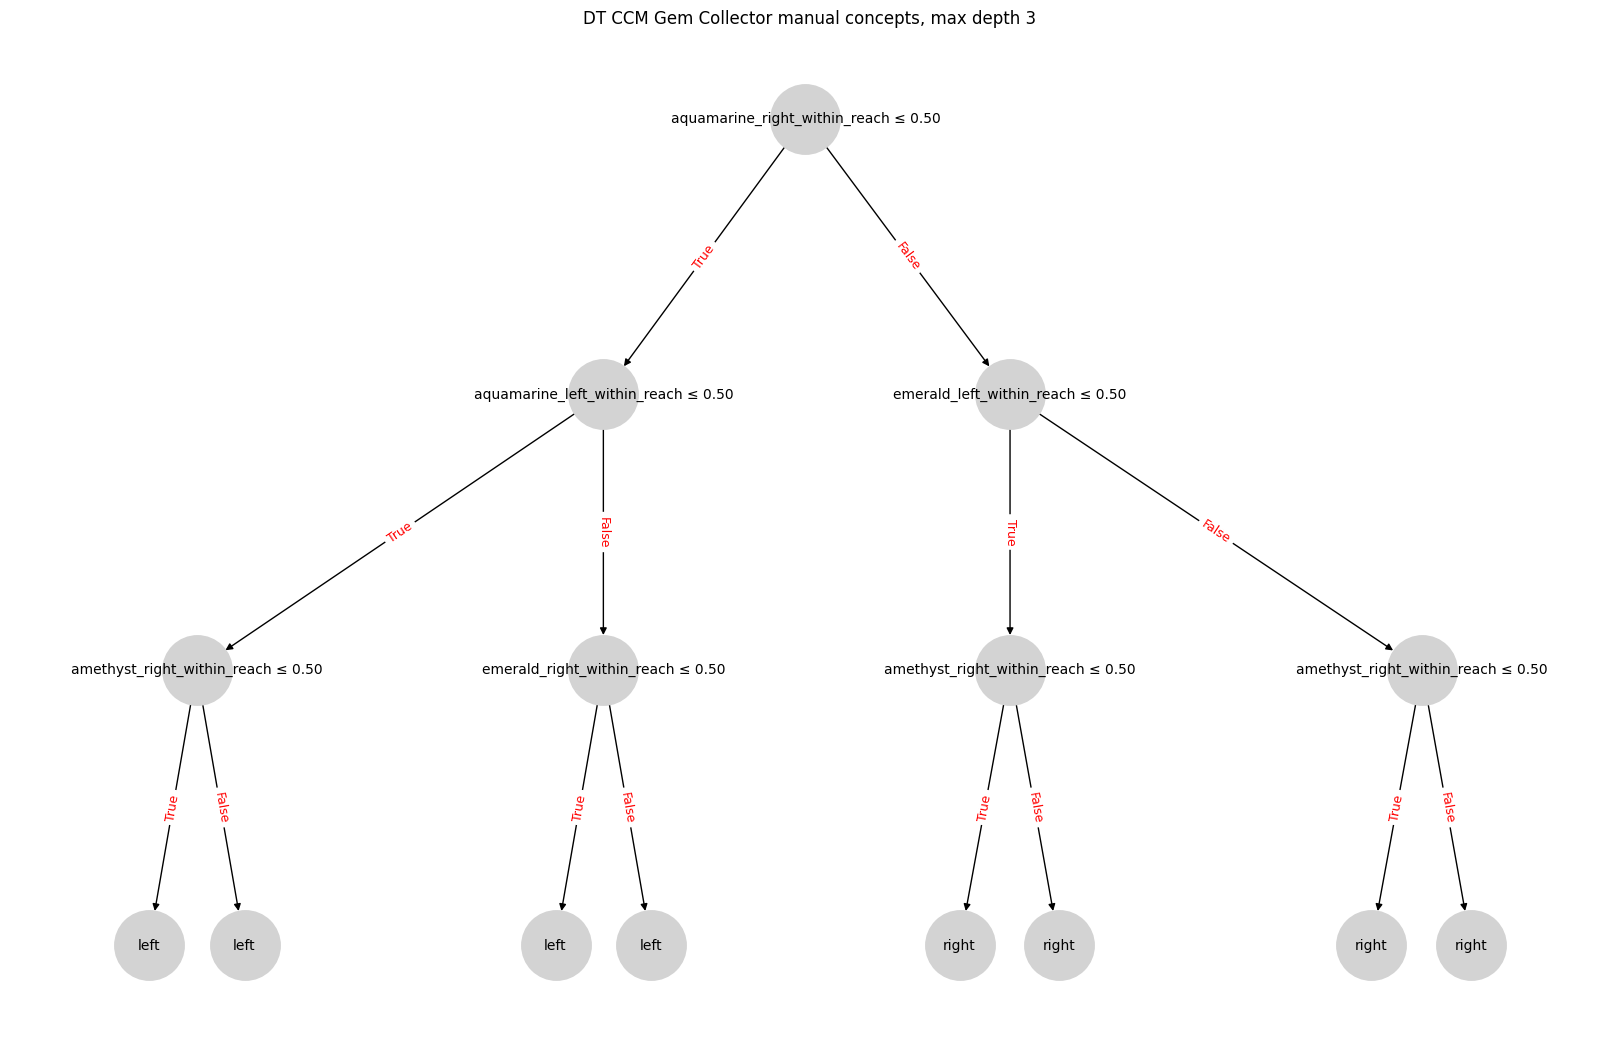

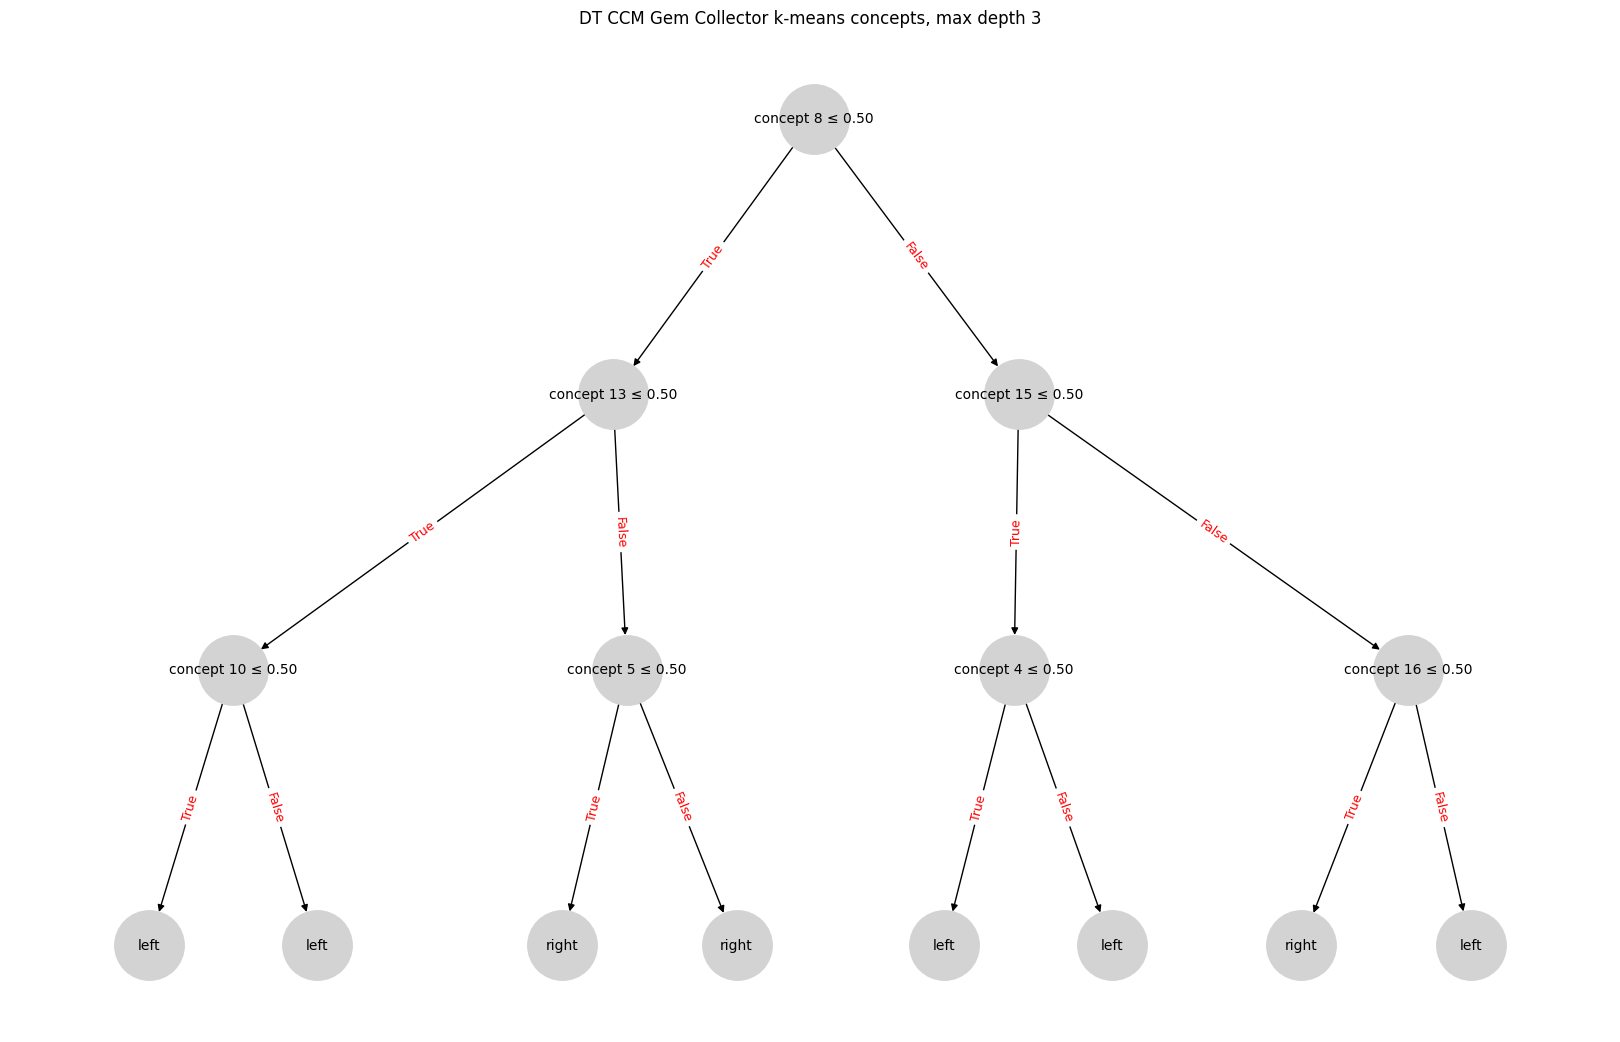

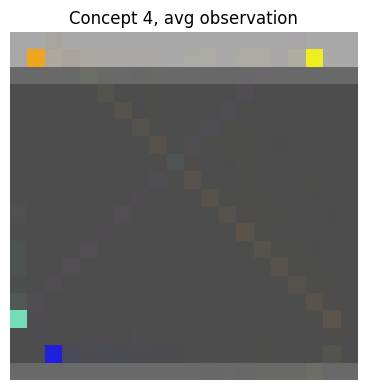

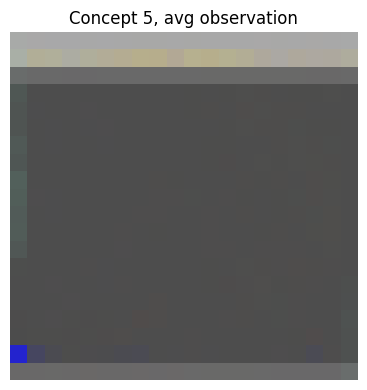

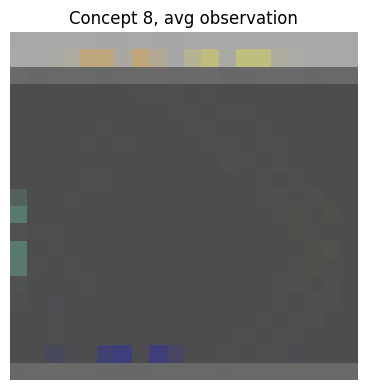

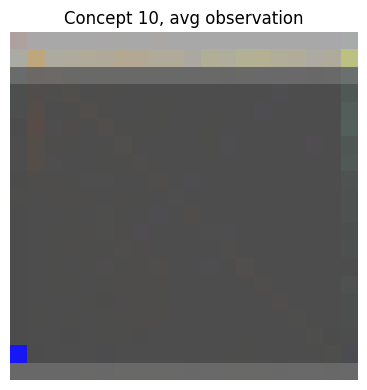

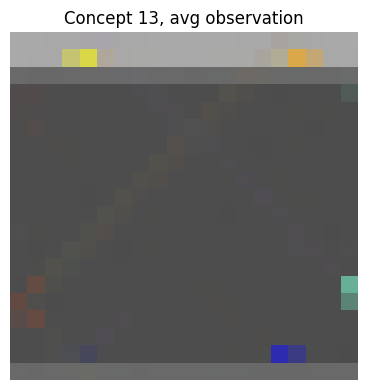

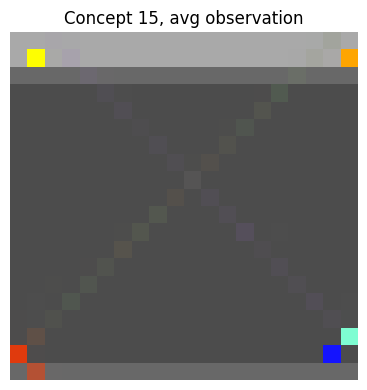

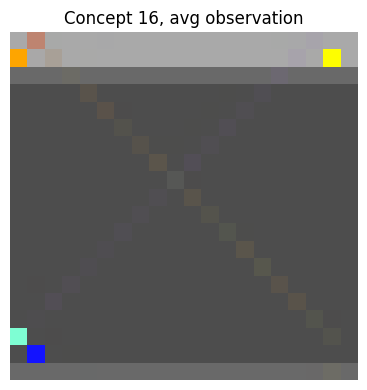

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


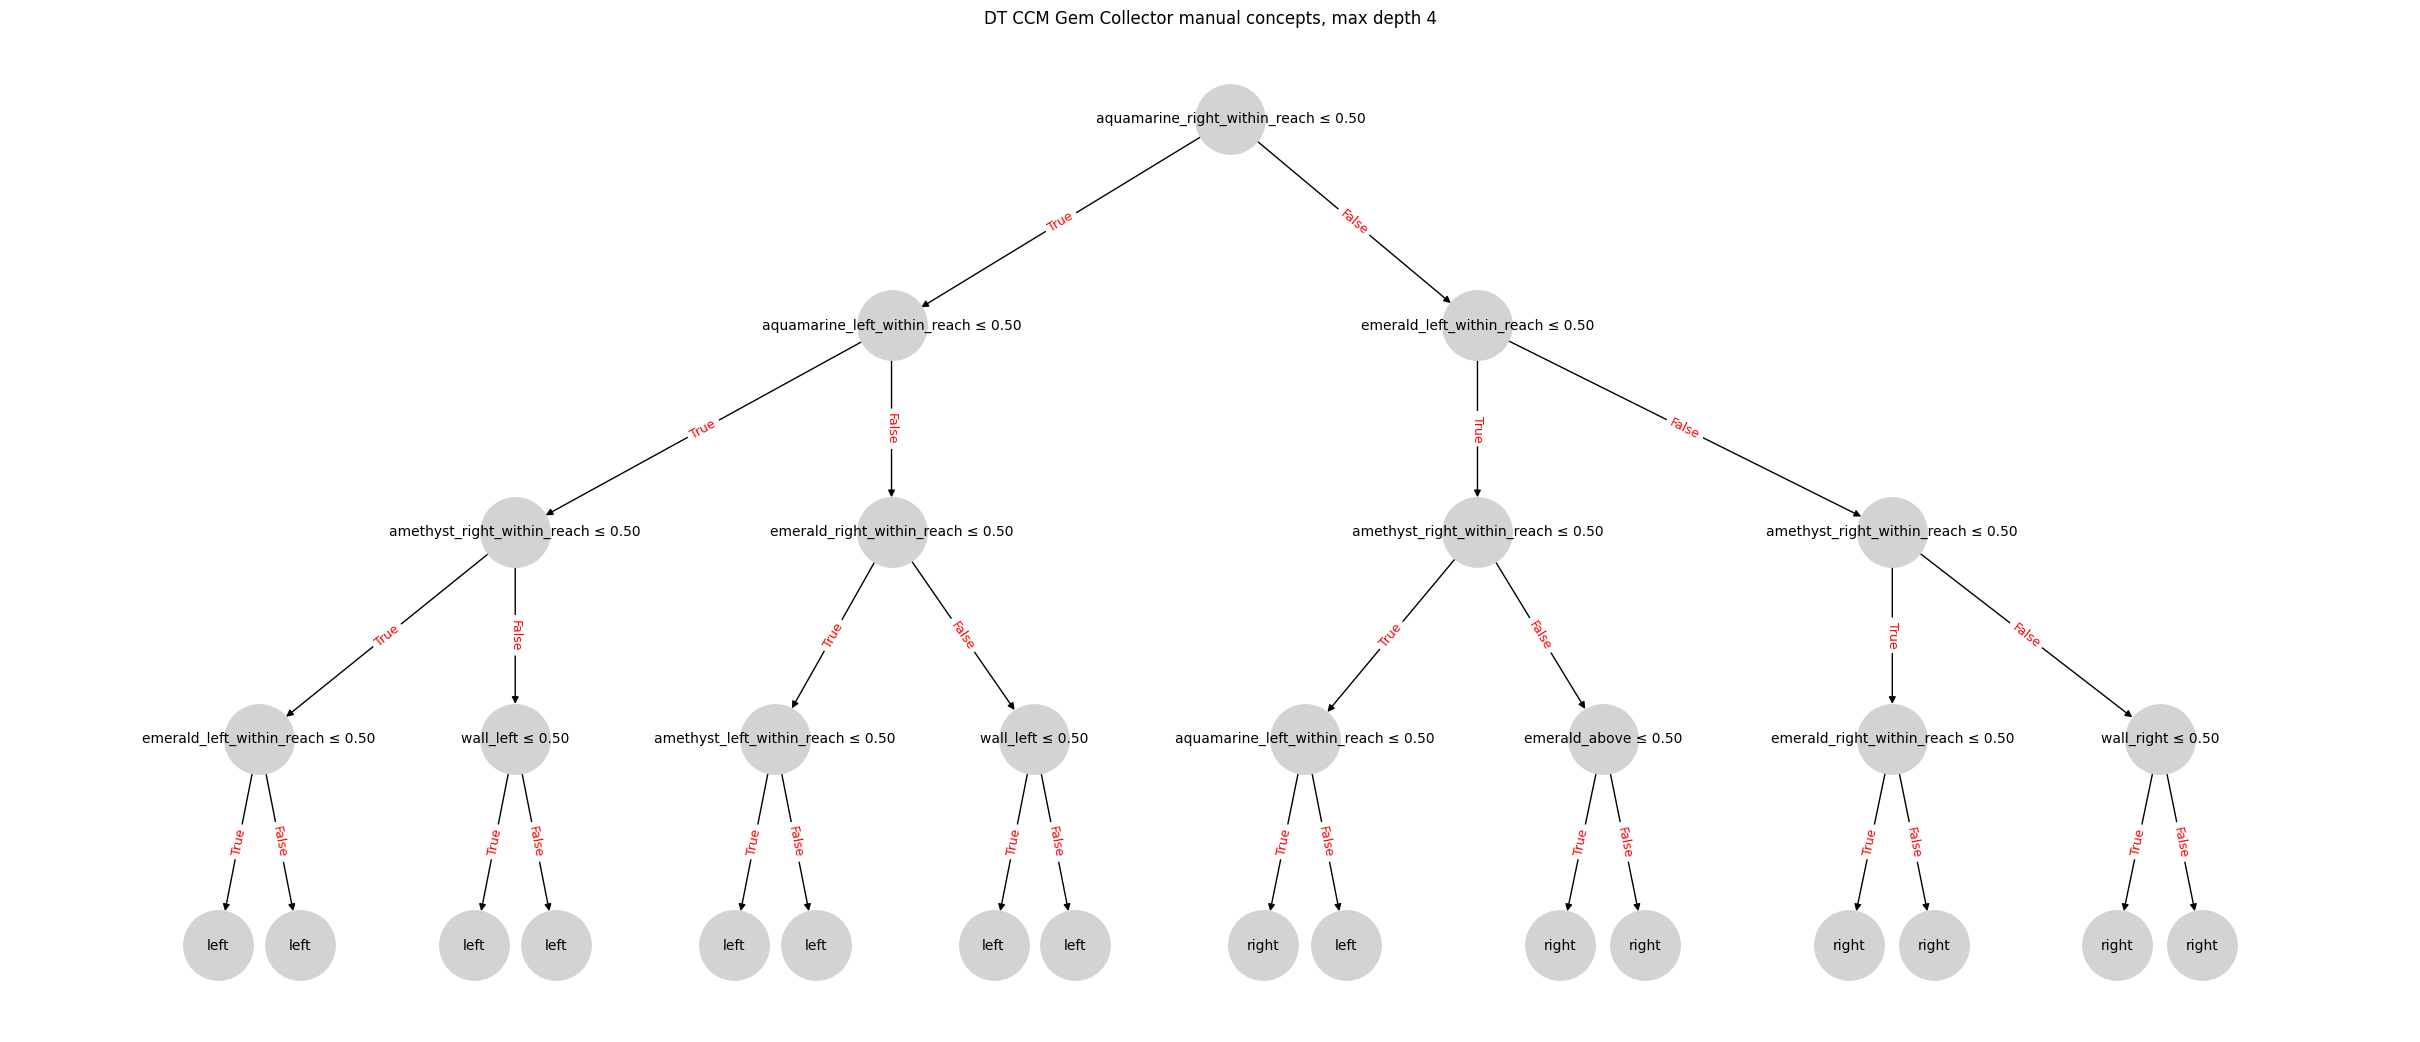

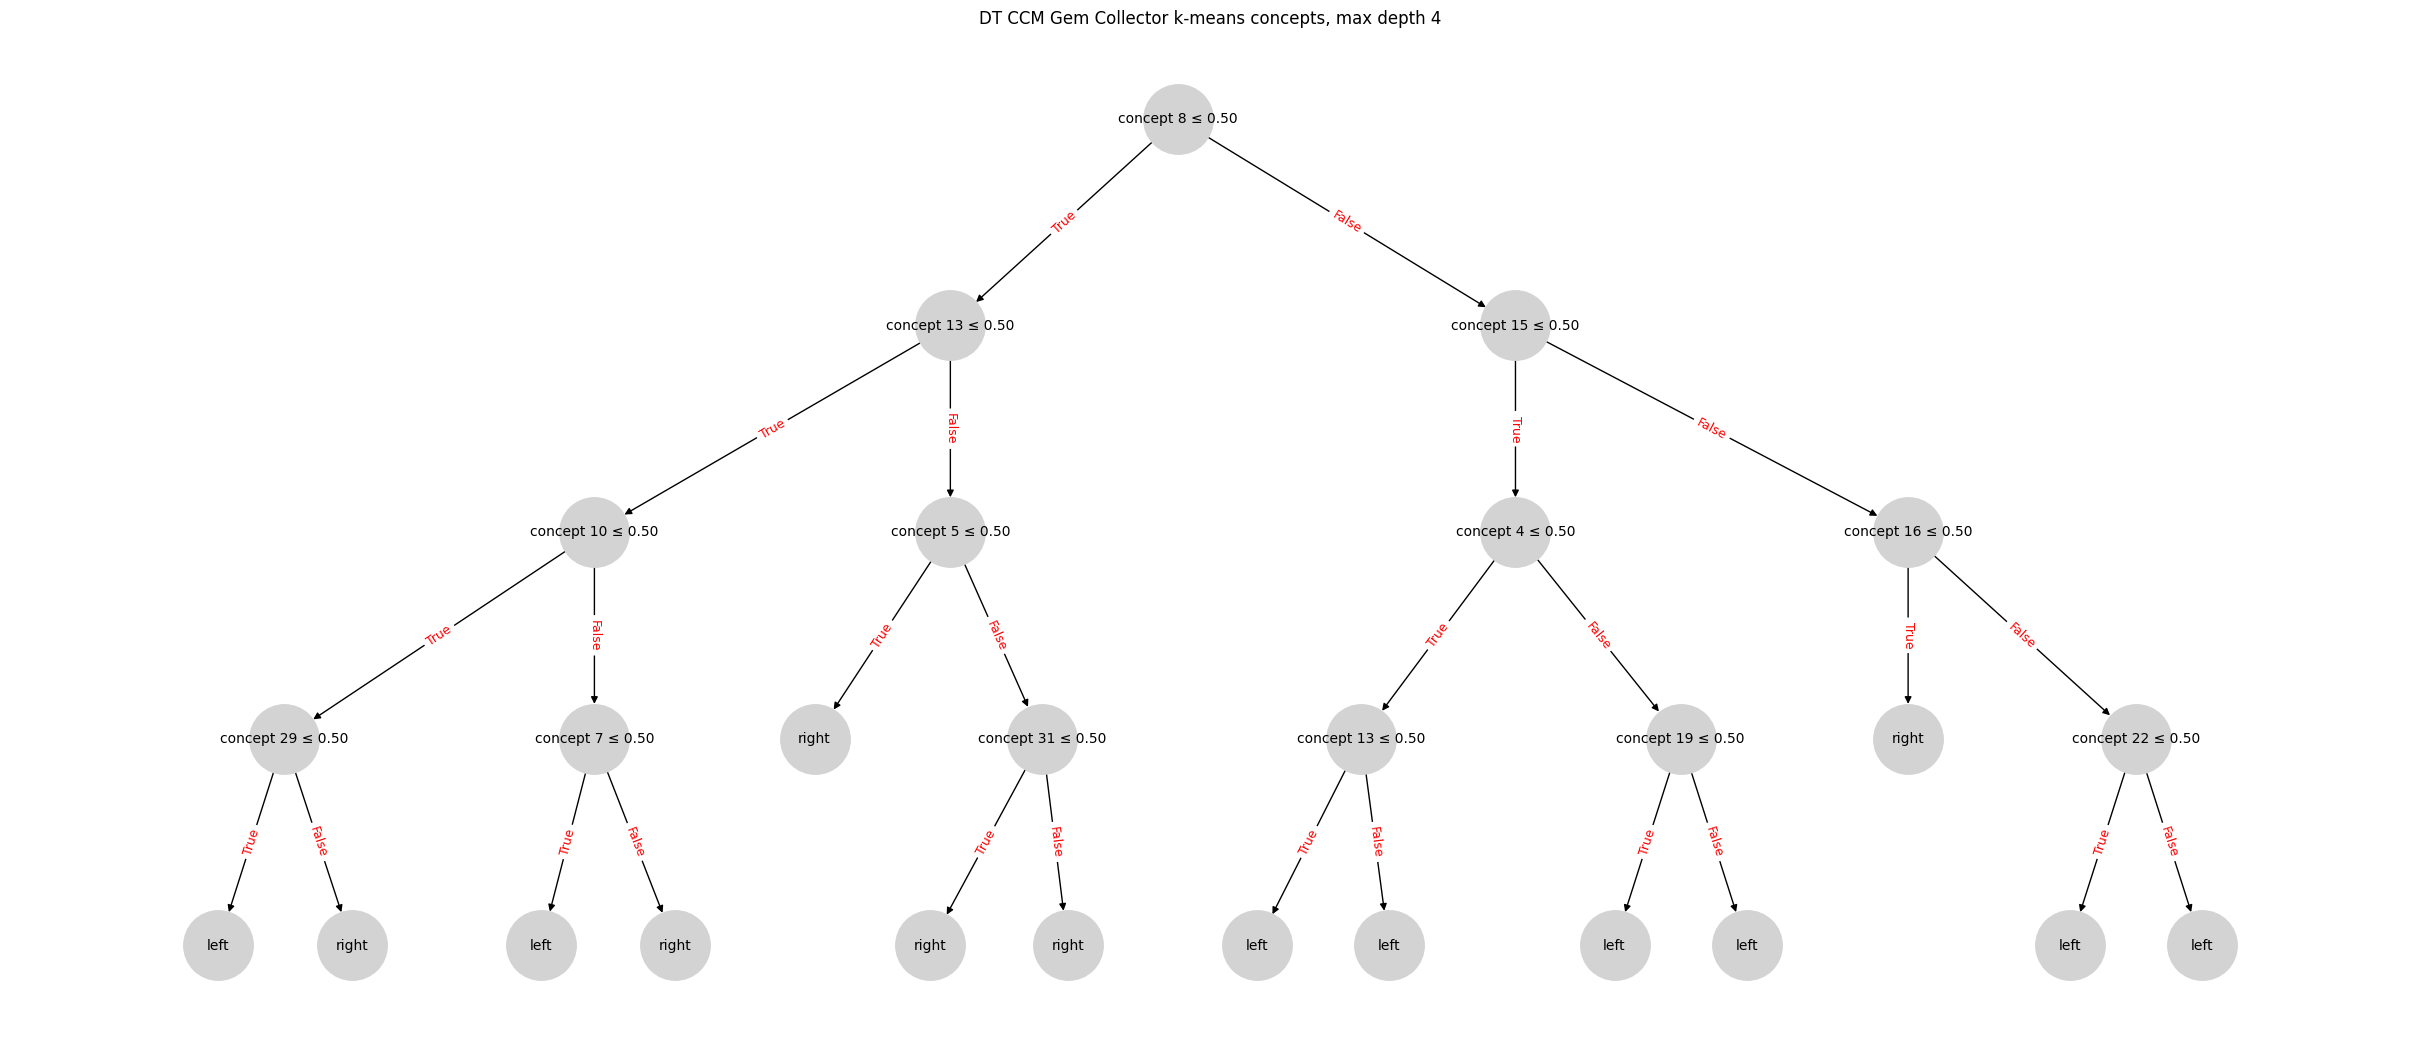

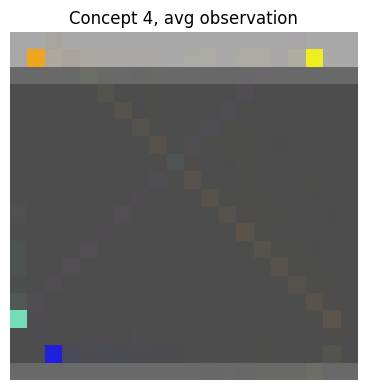

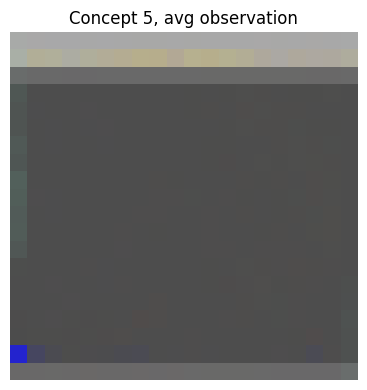

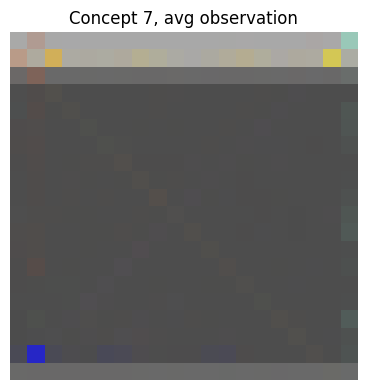

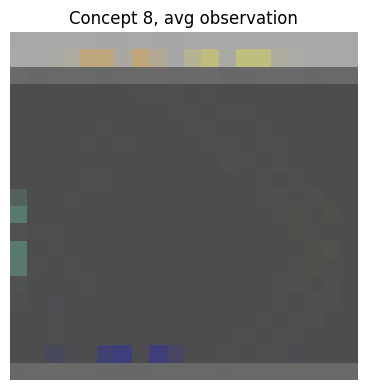

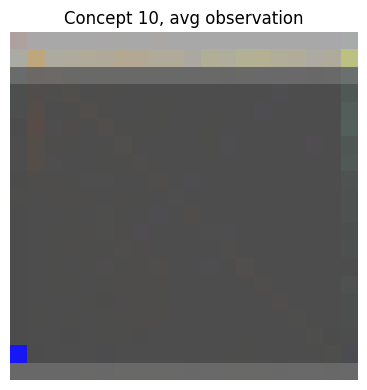

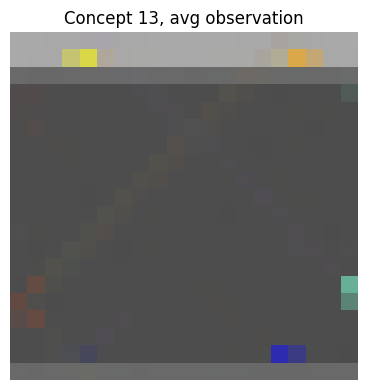

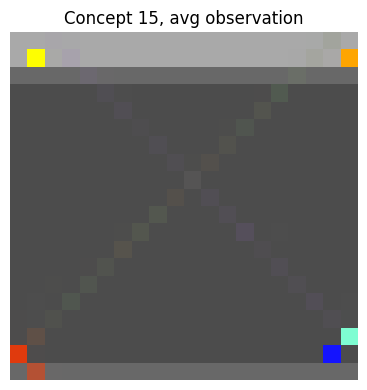

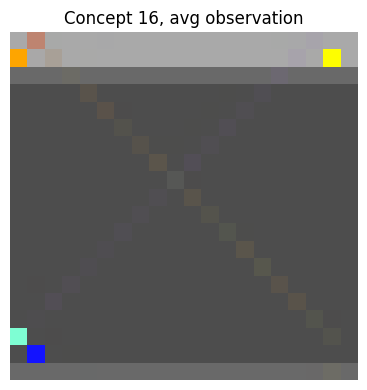

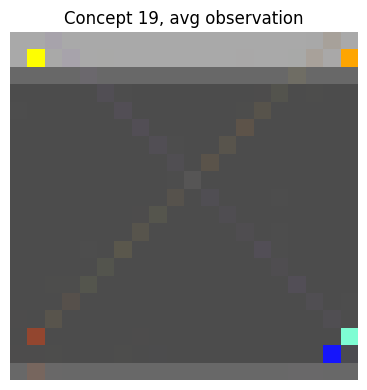

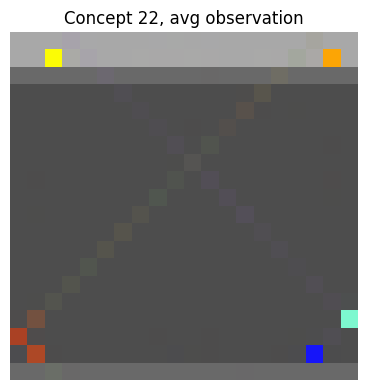

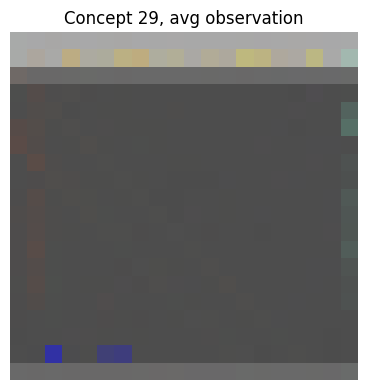

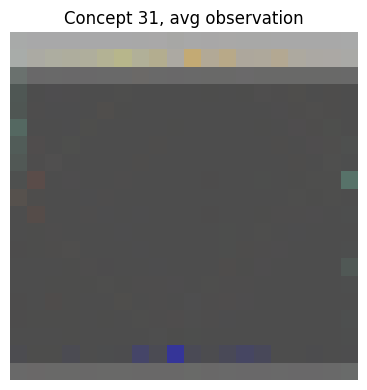

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


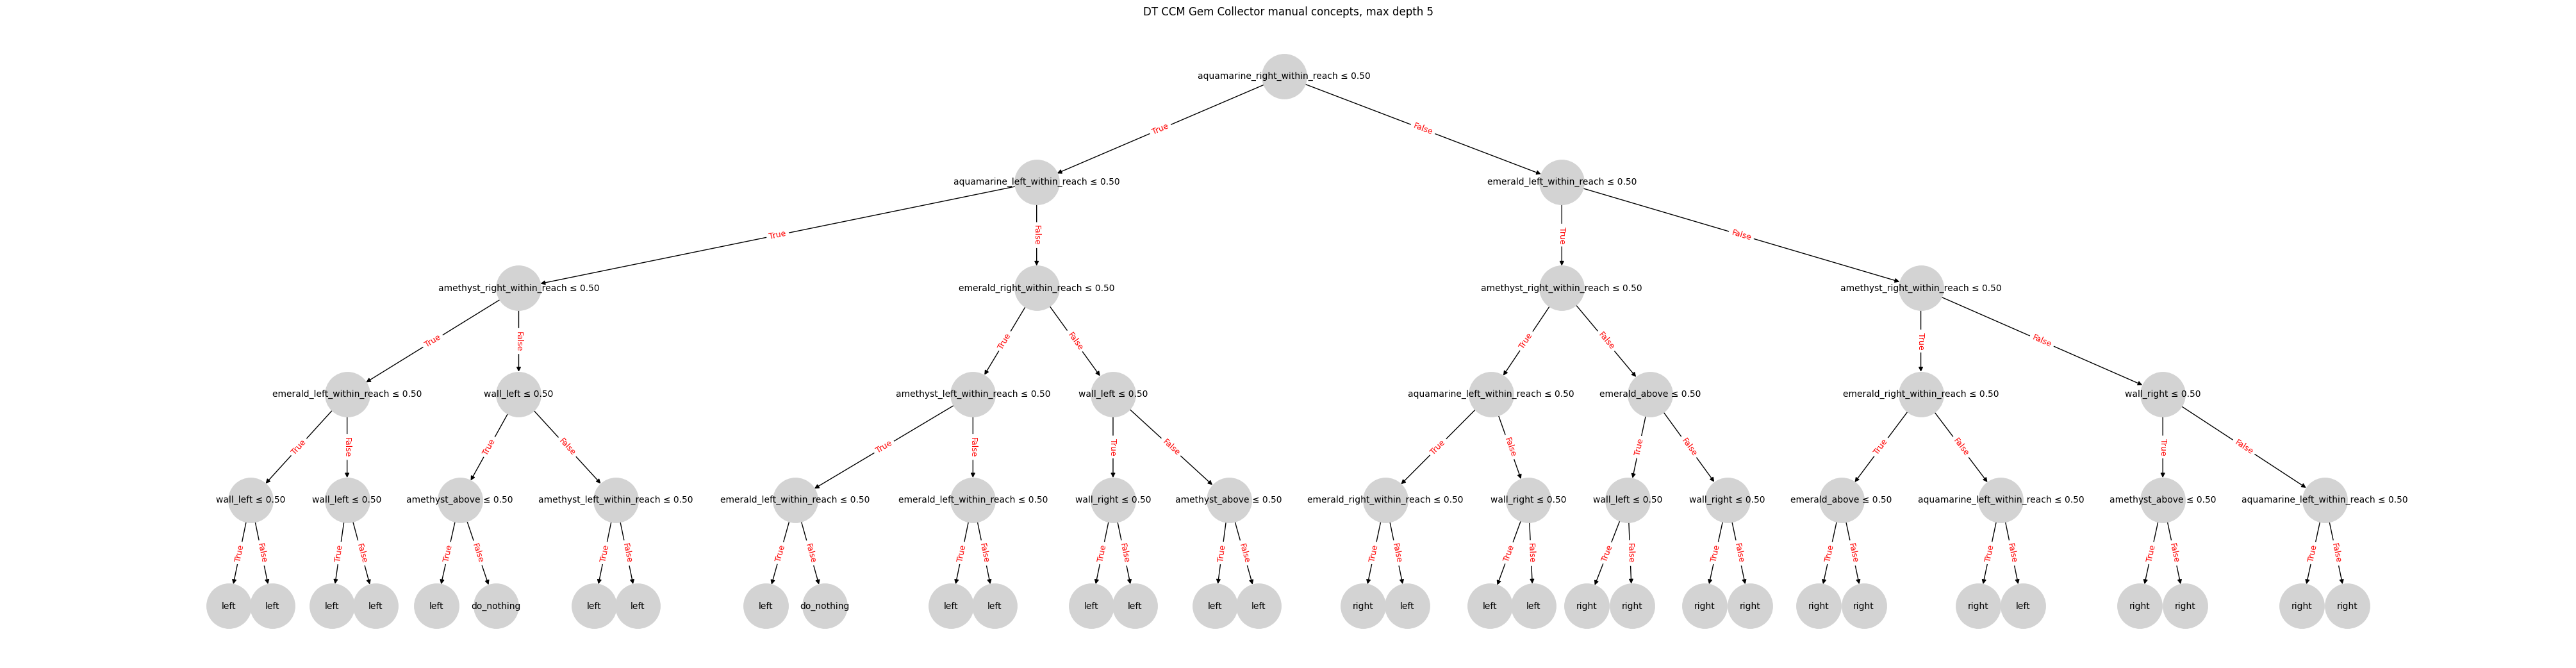

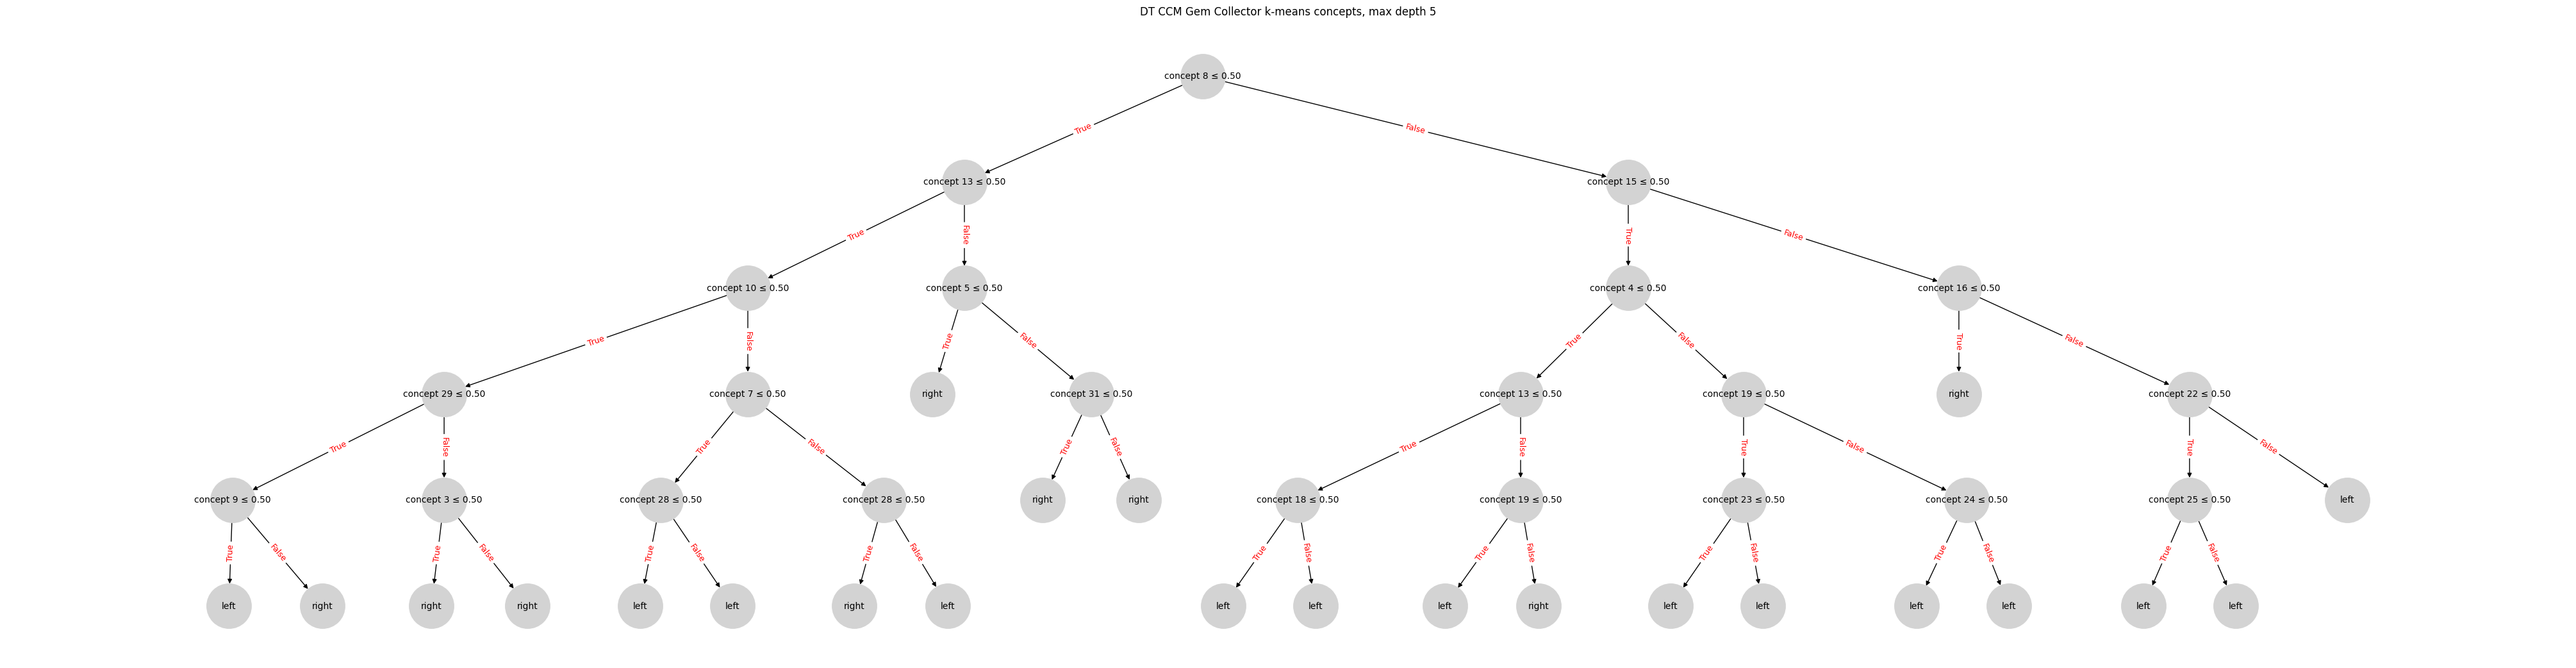

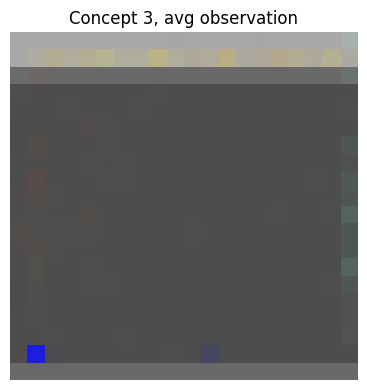

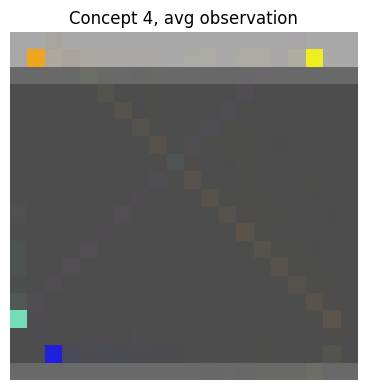

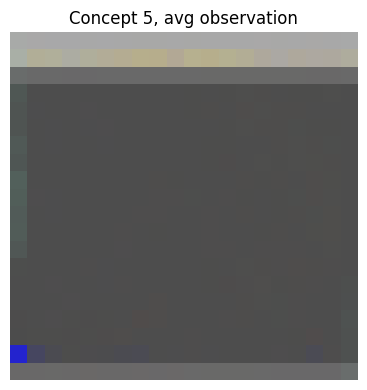

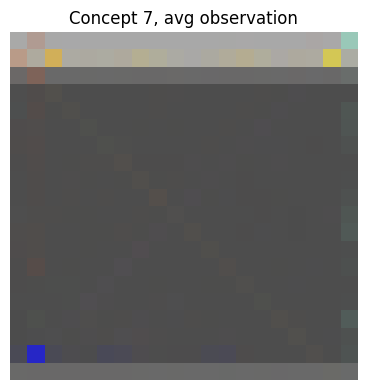

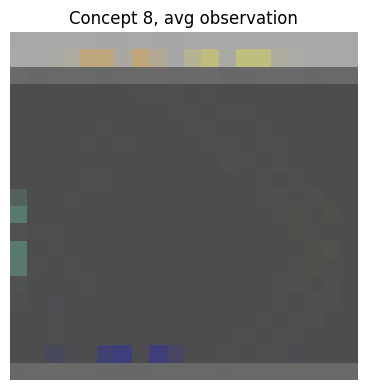

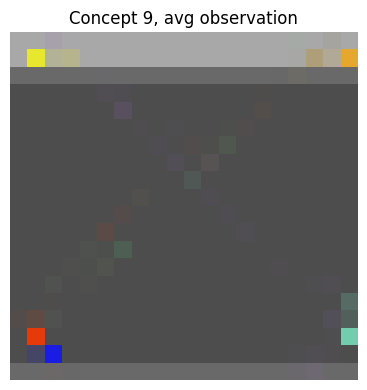

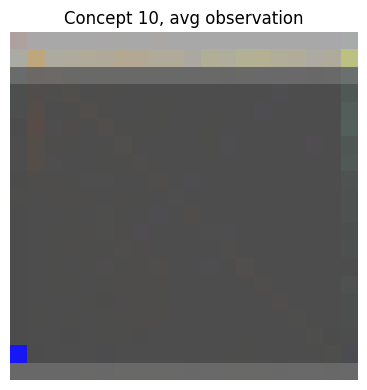

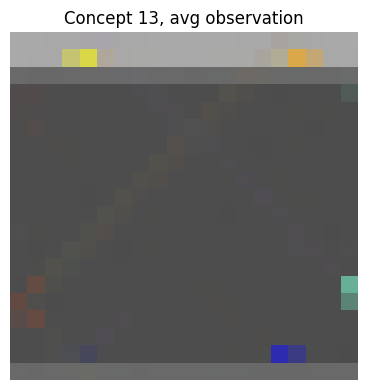

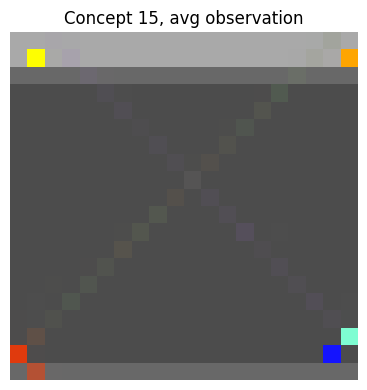

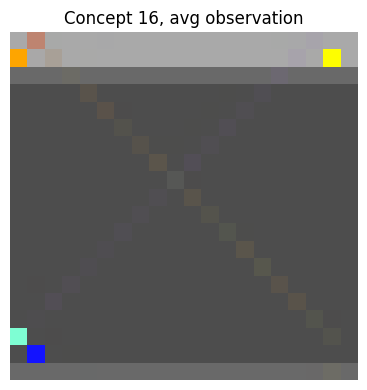

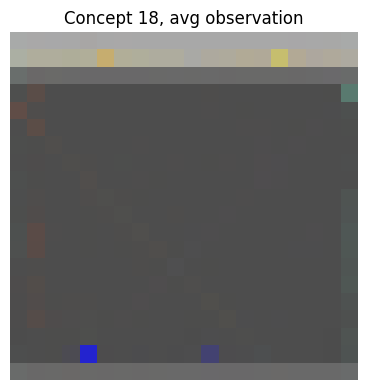

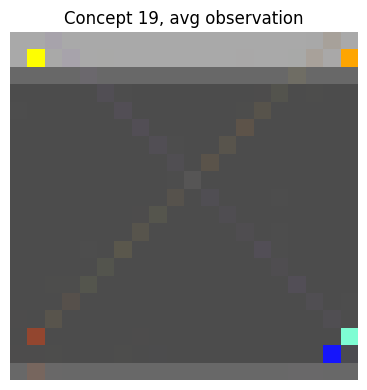

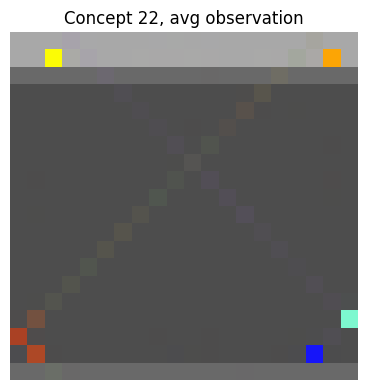

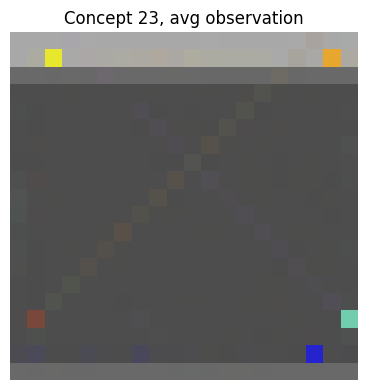

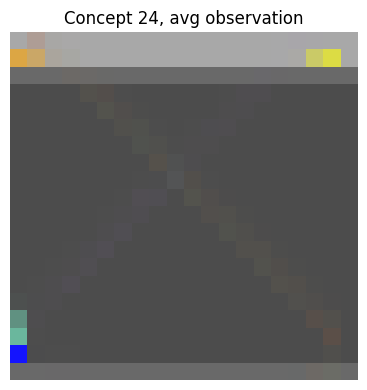

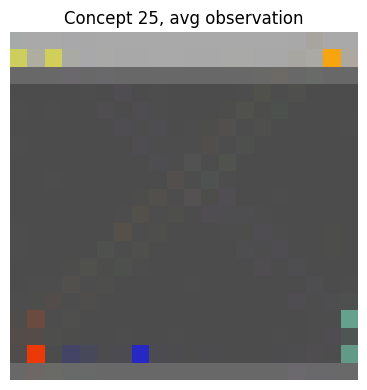

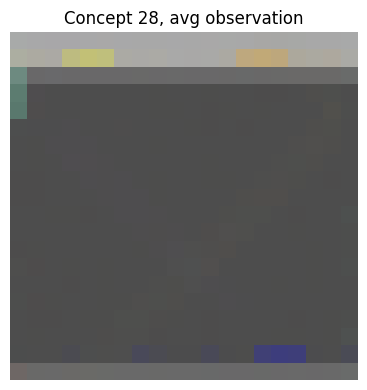

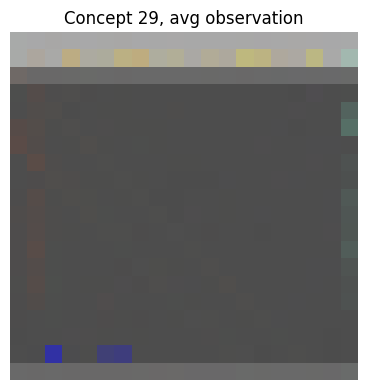

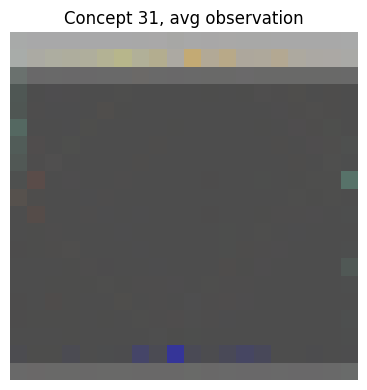

In [2]:
gc_concept_names_manual_dt = pd.read_csv("../../rl_ccm_data/completeness_scores/gem_collector/denim-sweep-56/ccm_dt/manual_concepts_used_names.csv").sort_values("feature_index")["concept_name"].tolist()

gc_action_dict = {
    0: "left",
    1: "right",
    2: "do_nothing",
}

model: Sequential = load_model("../../models/GemCollector/denim-sweep-56/1738828803_model____0.3766avg____0.6576max____0.1570min.keras") # type: ignore

mao = ModelActivationObtainer(model=model, input_normalization_type="image")

gc_clustered_obs = np.load("../../rl_concept_discovery_data/class_datasets_model_of_interest/gem_collector/target_class_balanced_30000_shuffled_examples.npy")
gc_k_means_clustered_labels = np.load("../../rl_ace_data/concept_examples/k_means/gem_collector/model_of_interest_target_class_balanced_observations/layer_5/k_32_cluster_labels.npy")

gc_clustered_obs_activations = mao.get_layer_activations(layer_index=5, model_inputs=gc_clustered_obs, flatten=True)
gc_k_means_clustered_controids = np.load("../../rl_ace_data/concept_examples/k_means/gem_collector/model_of_interest_target_class_balanced_observations/layer_5/k_32_cluster_centroids.npy")

gc_k_means_clustered_distances = np.array([
    norm(gc_clustered_obs_activations[i] - gc_k_means_clustered_controids[label])
    for i, label in enumerate(gc_k_means_clustered_labels)
])

for max_depth in range(3, 6):
    gc_manual_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gem_collector/denim-sweep-56/ccm_dt/best_ccm_manual_layer_4_c_12_max_q_max_depth_{max_depth}.joblib")
    gc_k_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gem_collector/denim-sweep-56/ccm_dt/best_ccm_k_means_layer_5_k_32_max_q_max_depth_{max_depth}.joblib")
    gc_fc_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gem_collector/denim-sweep-56/ccm_dt/best_ccm_fc_means_layer_5_c_20_max_q_max_depth_{max_depth}.joblib")

    graph = build_custom_graph(gc_manual_concepts_dt.tree_, gc_action_dict, gc_concept_names_manual_dt)
    draw_custom_tree(graph, max_depth, f"DT CCM Gem Collector manual concepts, max depth {max_depth}")

    graph = build_custom_graph(gc_k_means_concepts_dt.tree_, gc_action_dict)
    draw_custom_tree(graph, max_depth, f"DT CCM Gem Collector k-means concepts, max depth {max_depth}")

    used_clusters = np.unique(gc_k_means_concepts_dt.tree_.feature) # type: ignore
    used_clusters = used_clusters[used_clusters != -2] 

    visualize_avg_cluster_observation(clustered_observations=gc_clustered_obs,
    clustered_observations_labels=gc_k_means_clustered_labels,
    distances=gc_k_means_clustered_distances,
    clusters_to_show=used_clusters,
    show=True,
    )

    #graph = build_custom_graph(gc_fc_means_concepts_dt.tree_, gc_action_dict)
    #draw_custom_tree(graph, max_depth, f"DT CCM Gem Collector fuzzy c-means concepts, max depth {max_depth}")

### Gold Run

216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


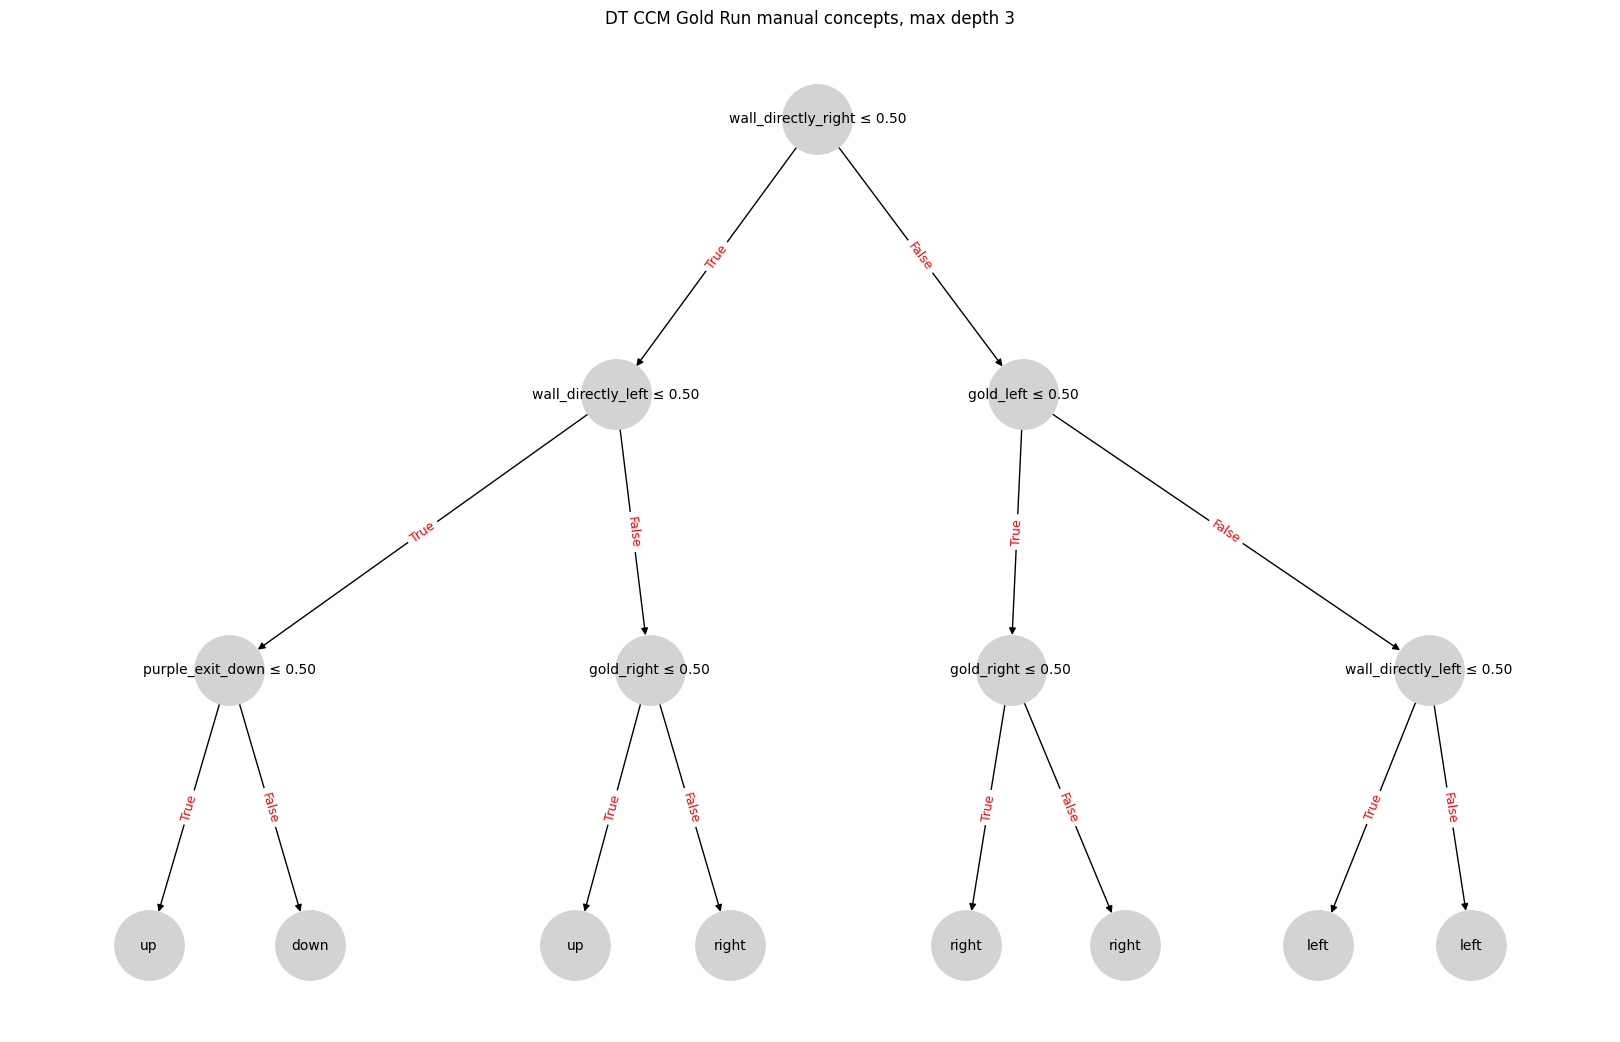

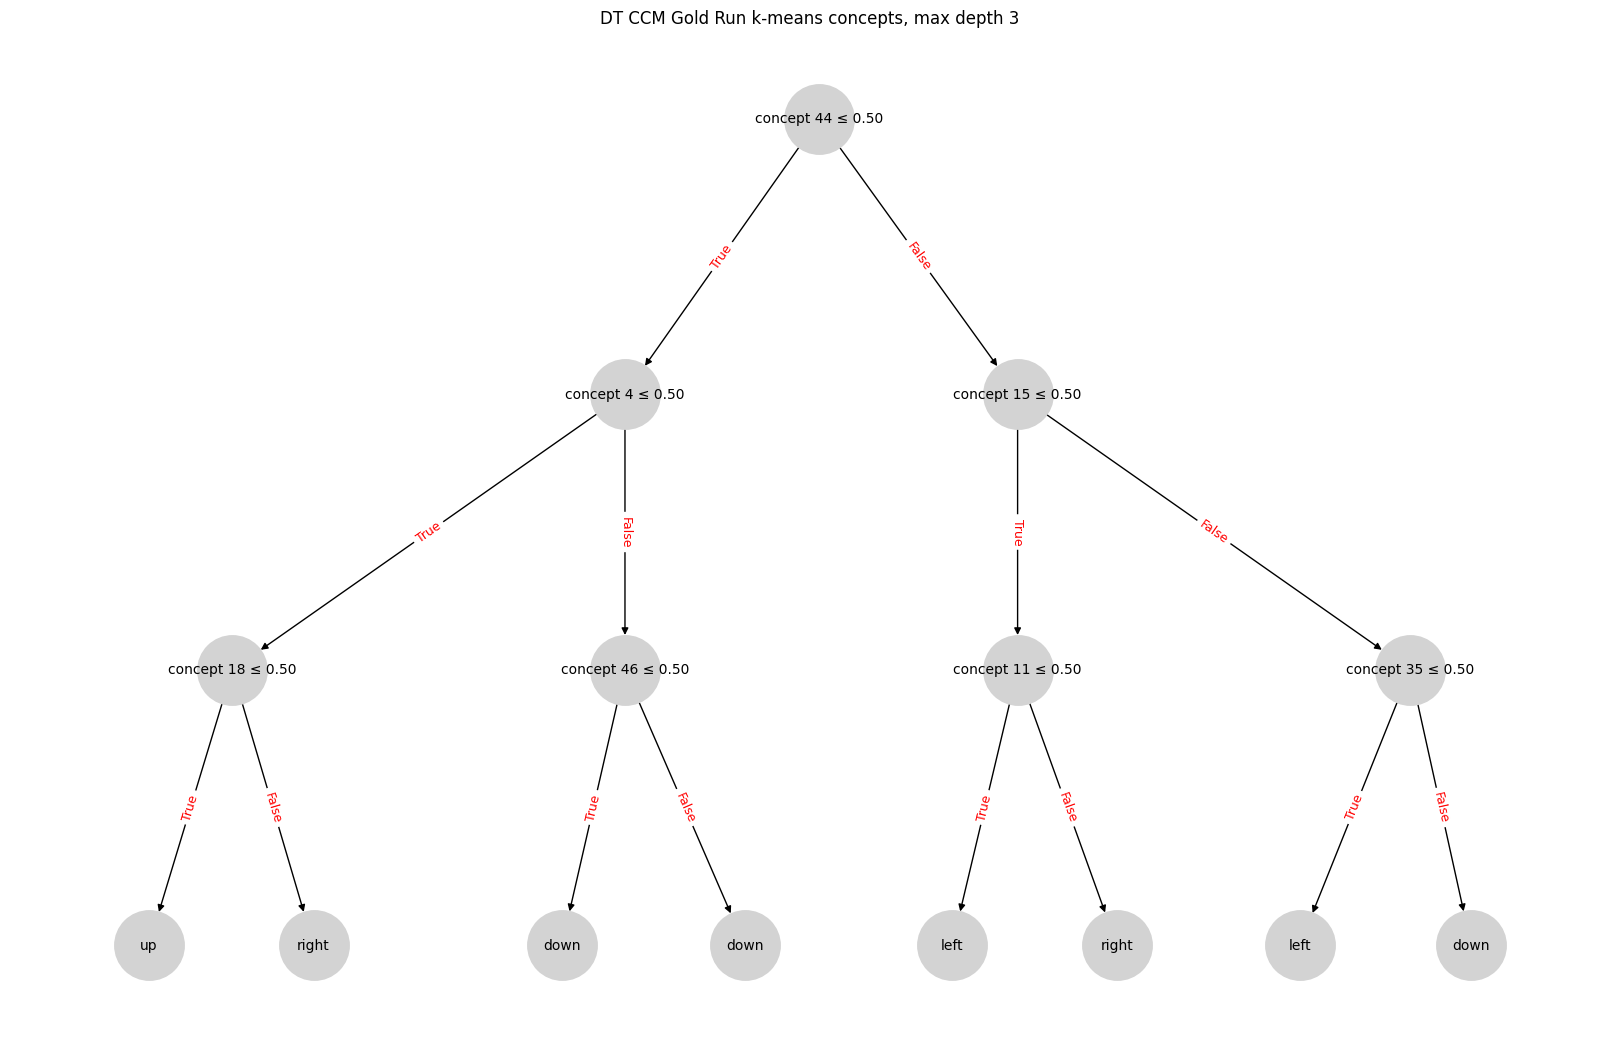

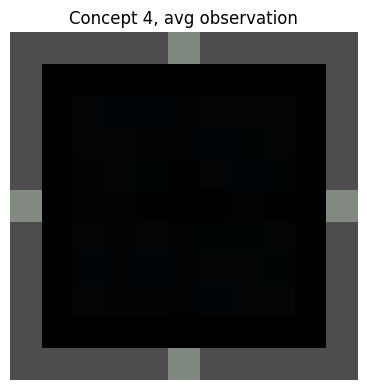

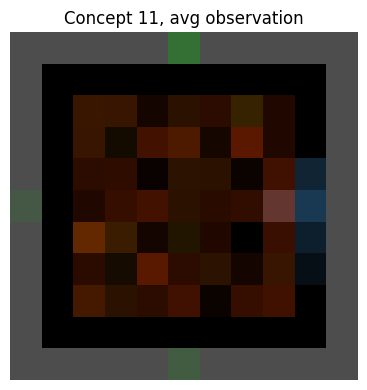

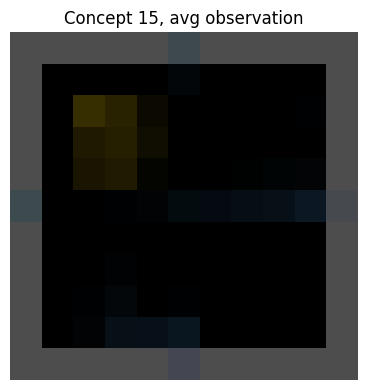

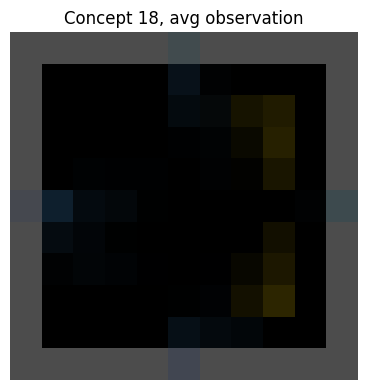

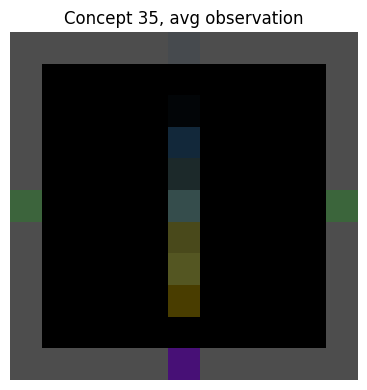

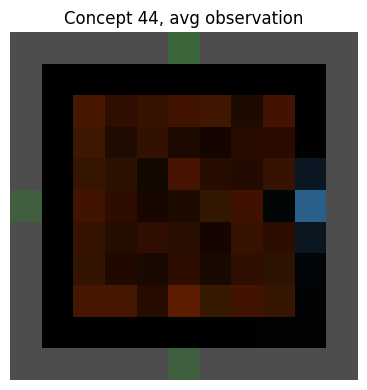

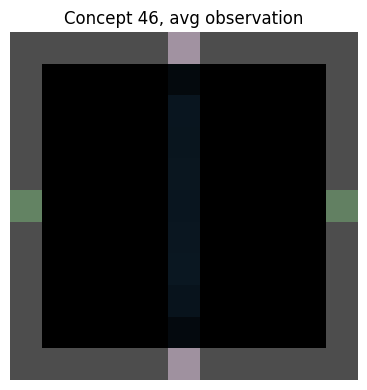

Showing random observations from cluster 4


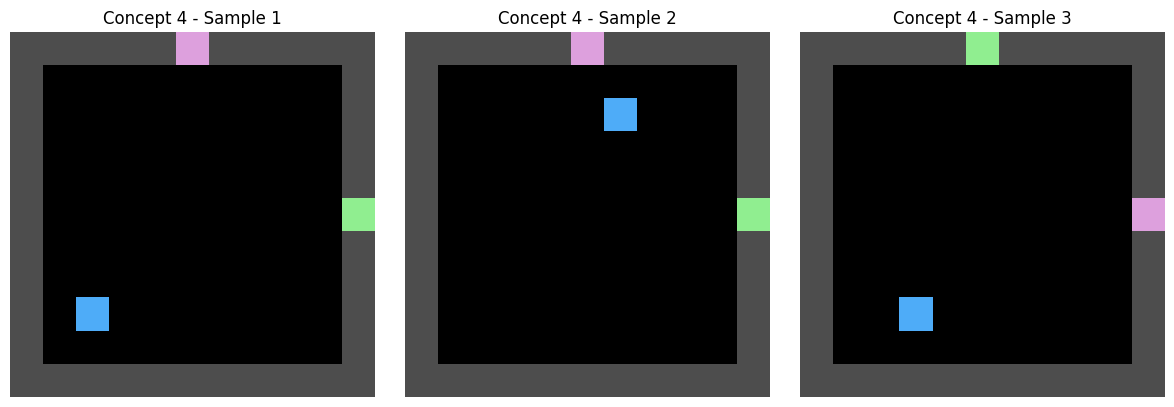

Showing random observations from cluster 11


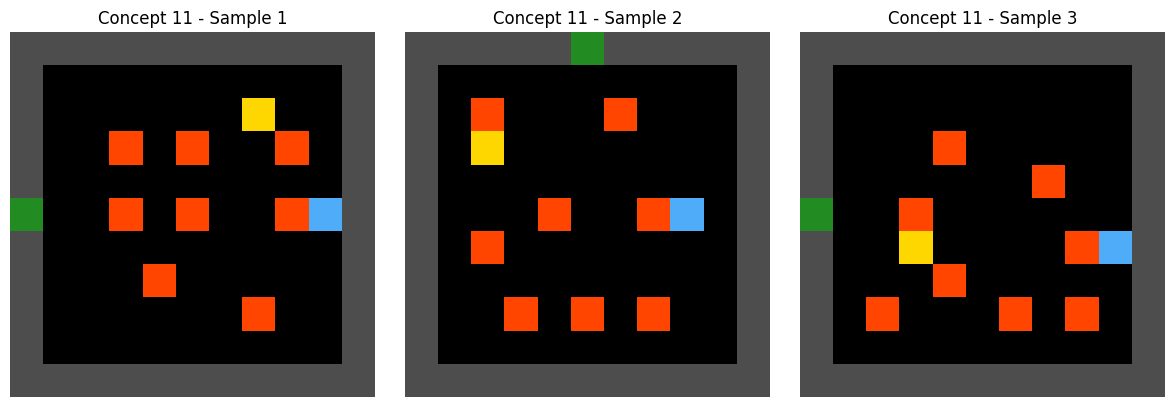

Showing random observations from cluster 15


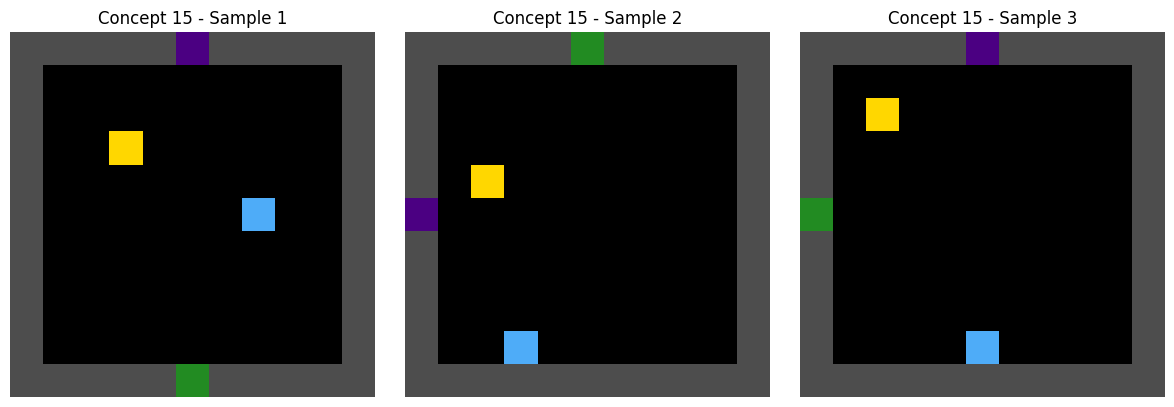

Showing random observations from cluster 18


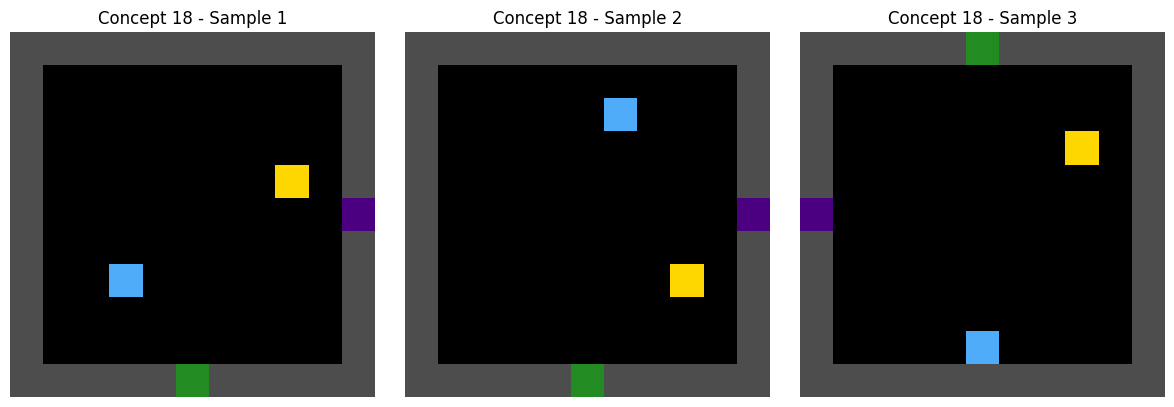

Showing random observations from cluster 35


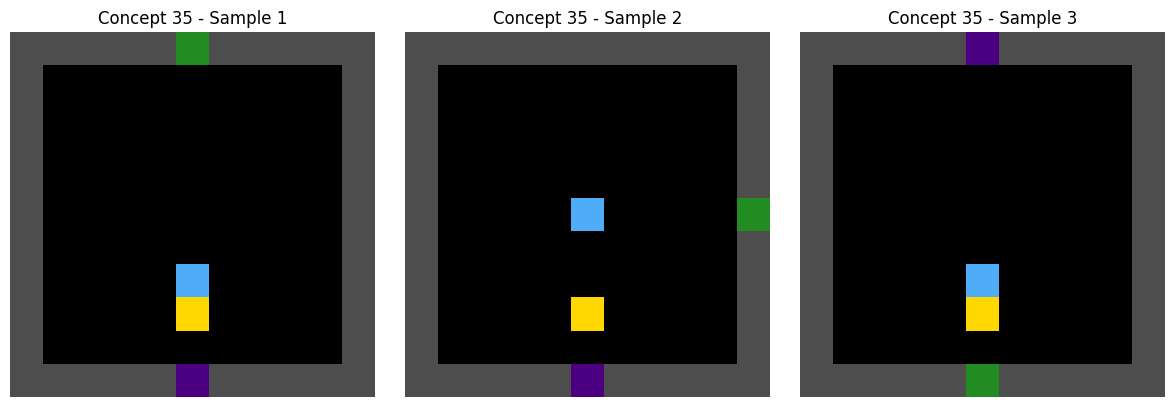

Showing random observations from cluster 44


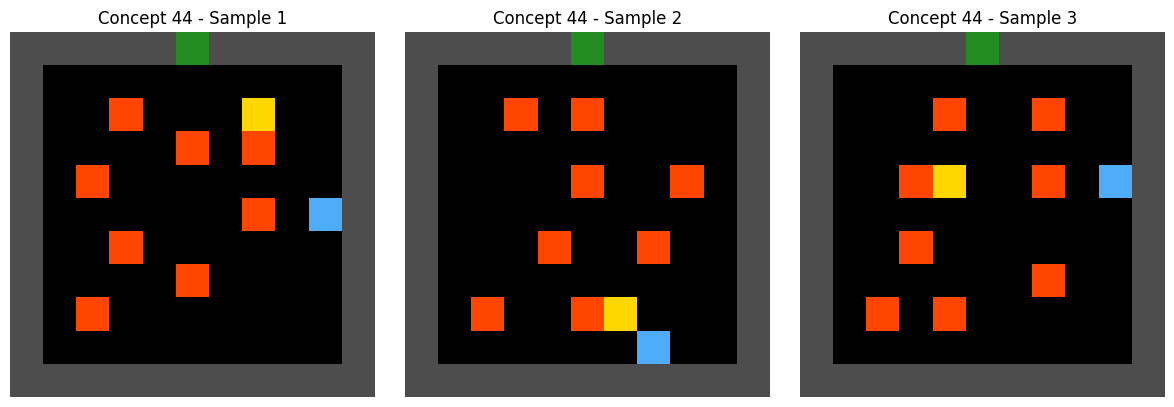

Showing random observations from cluster 46


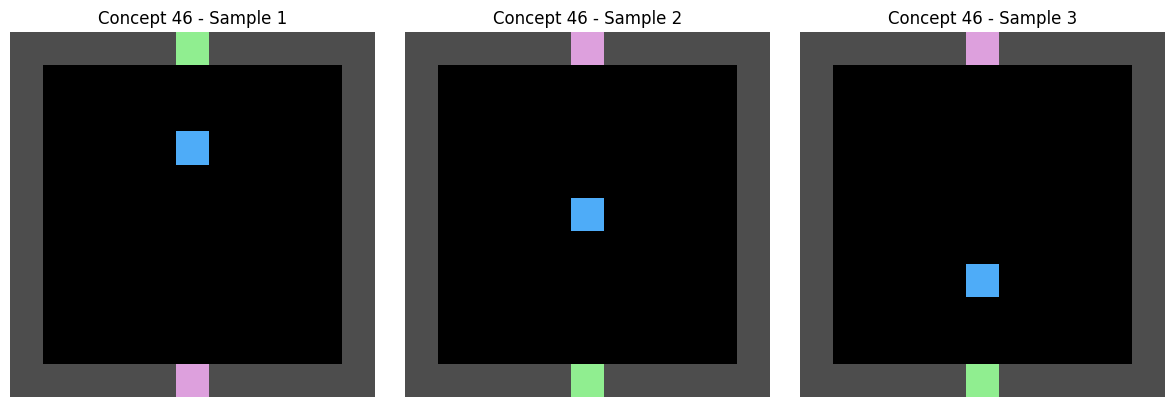

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


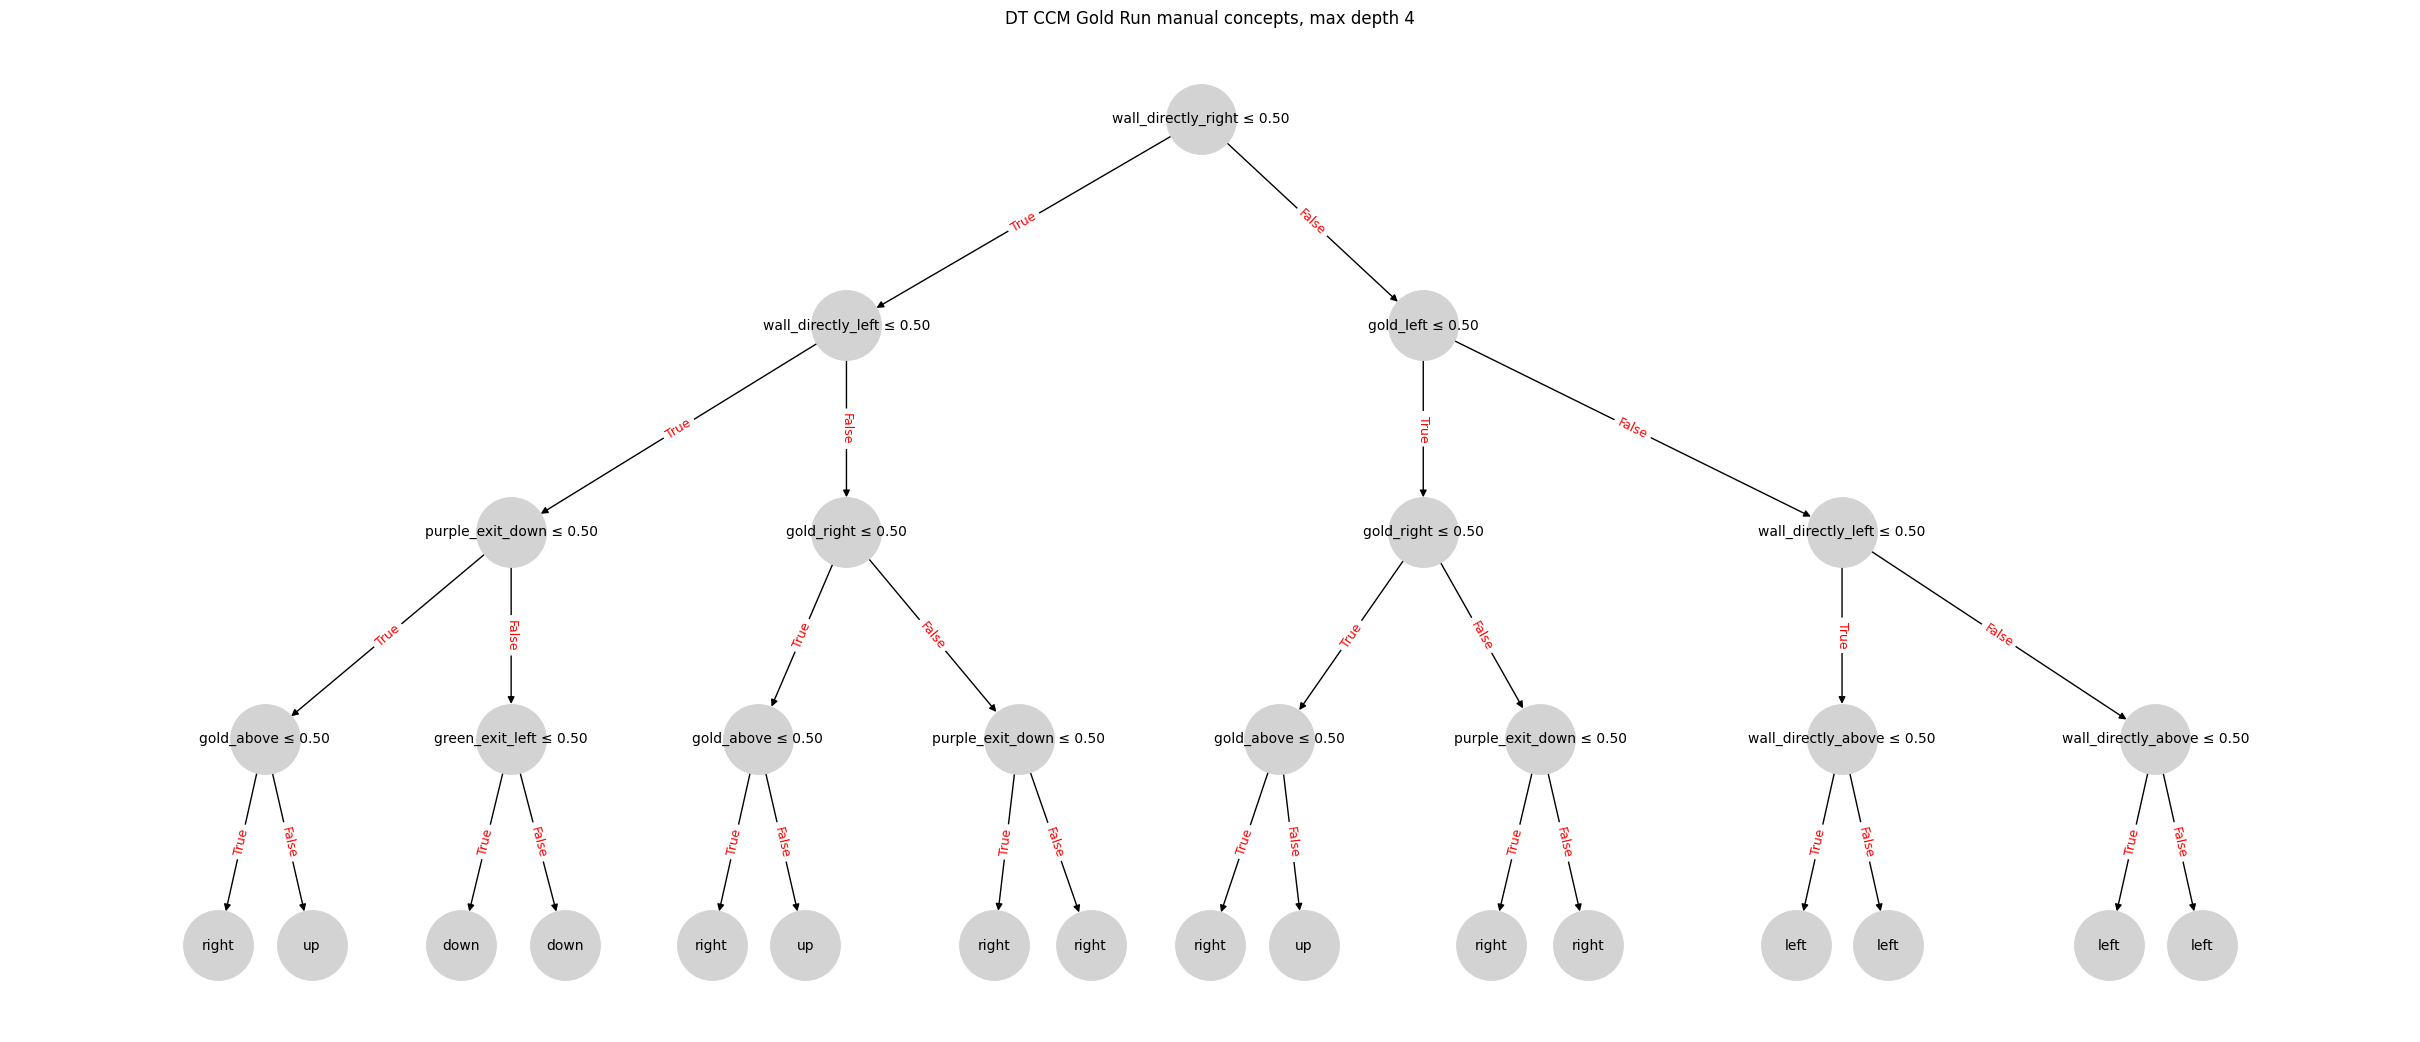

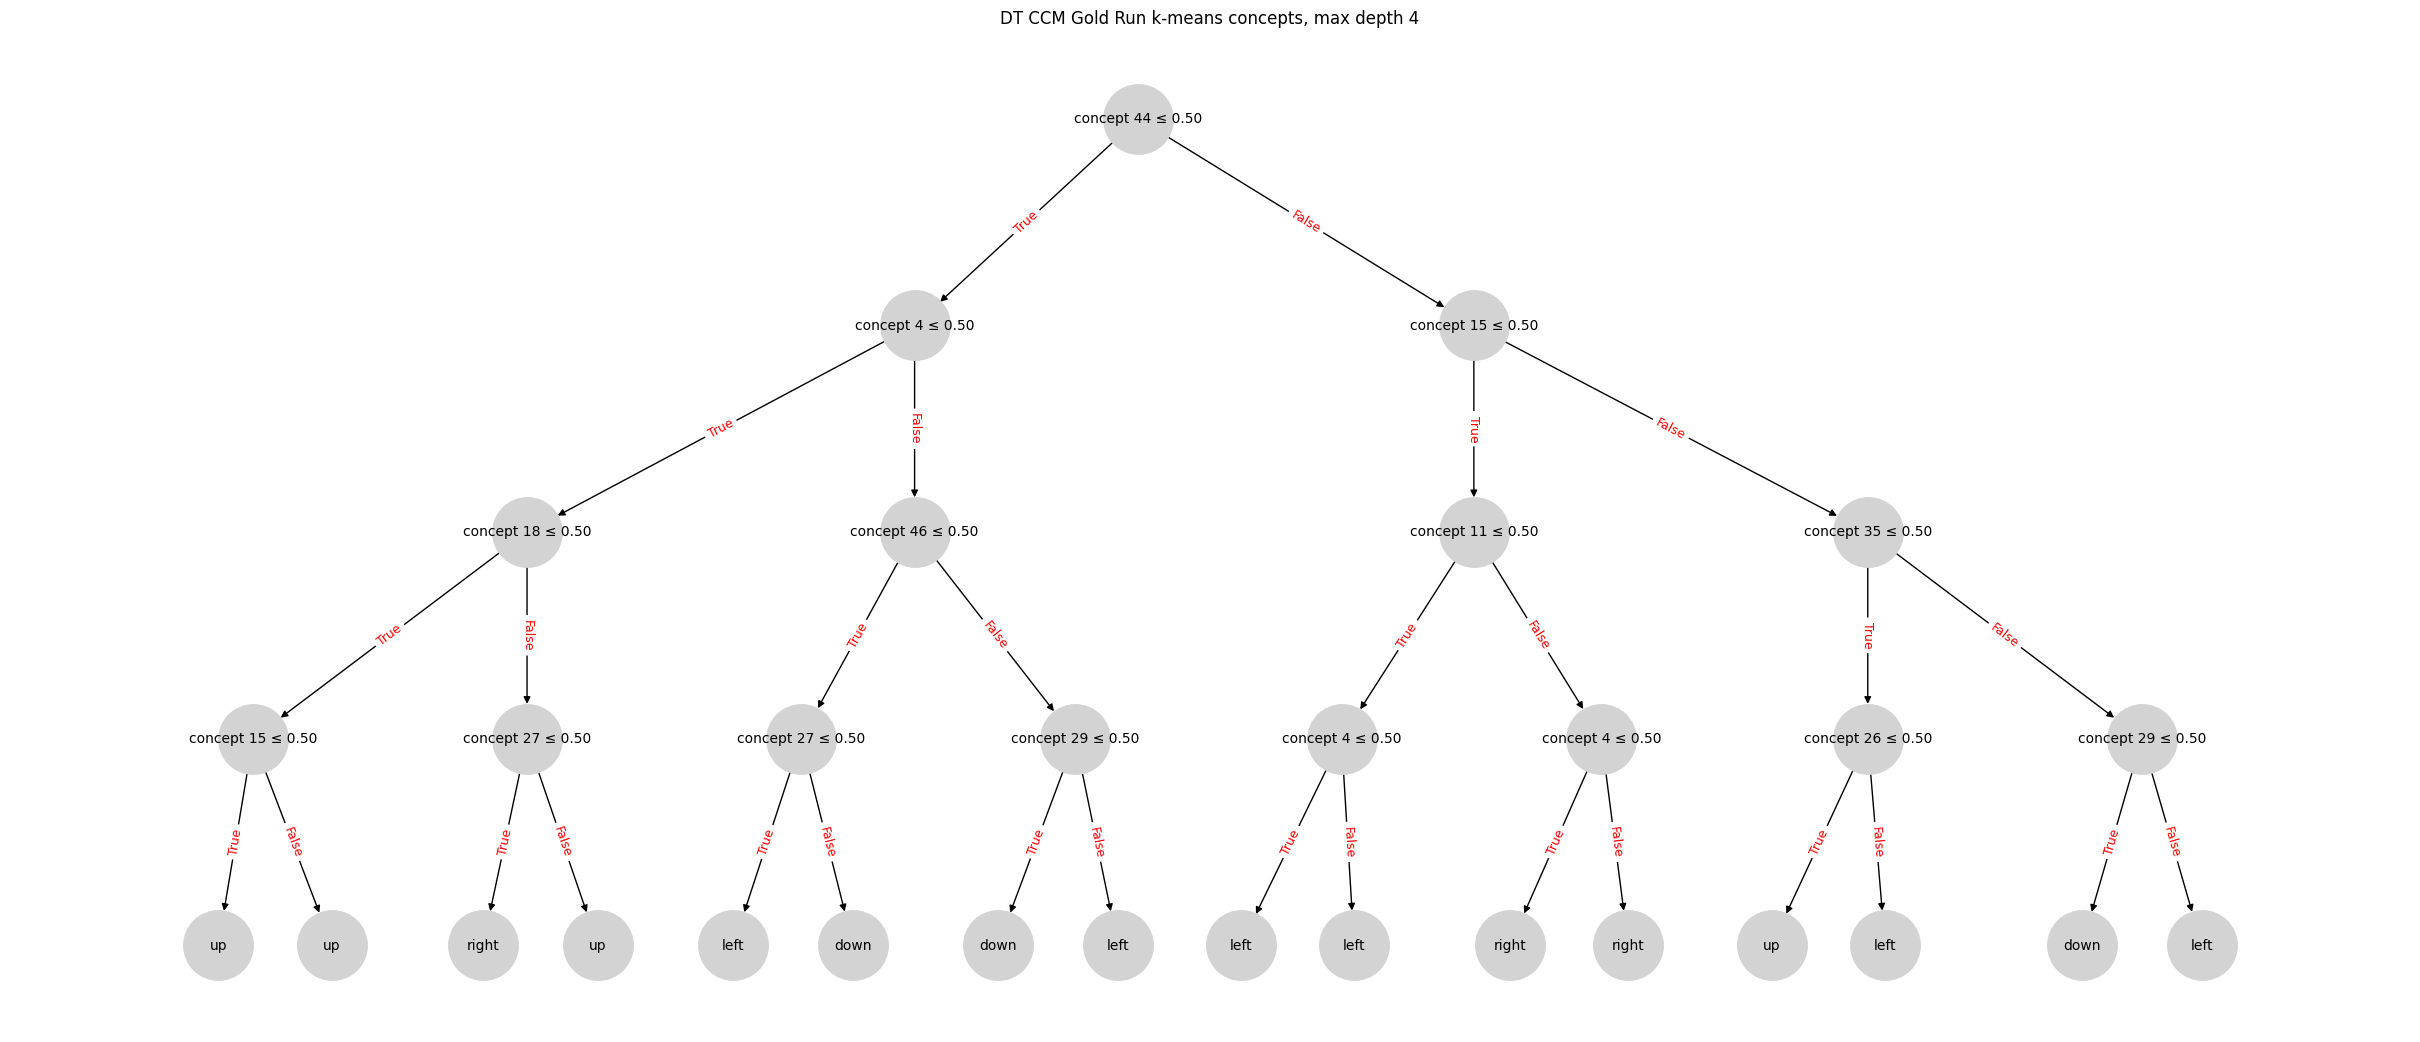

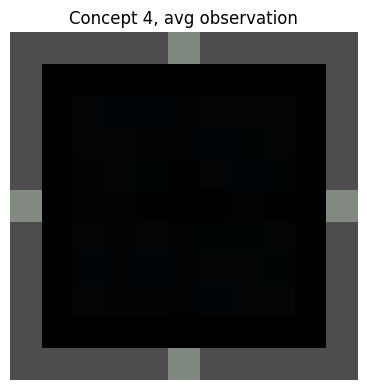

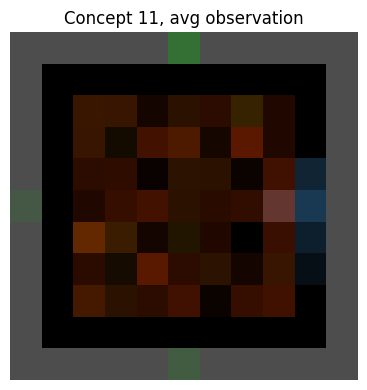

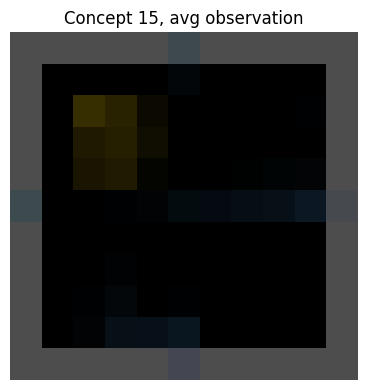

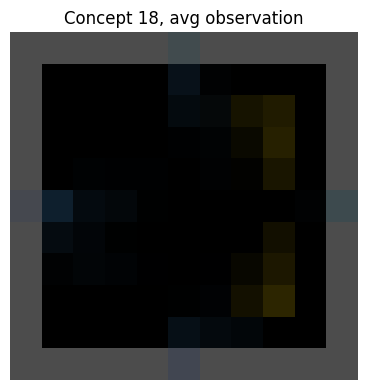

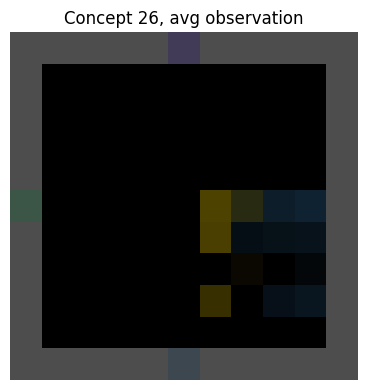

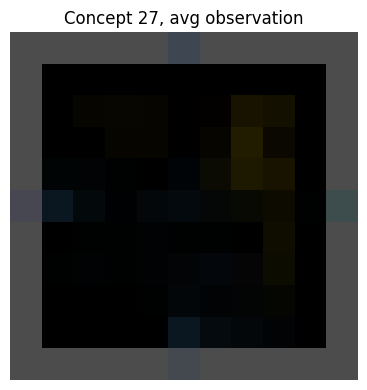

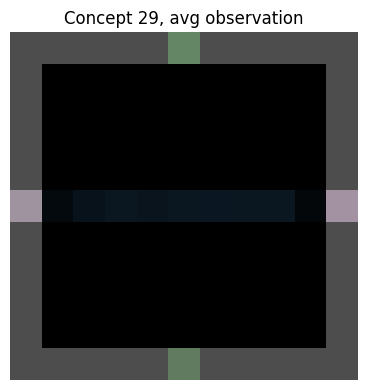

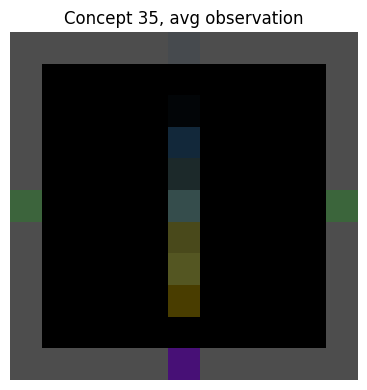

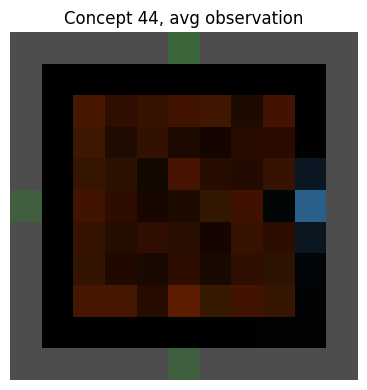

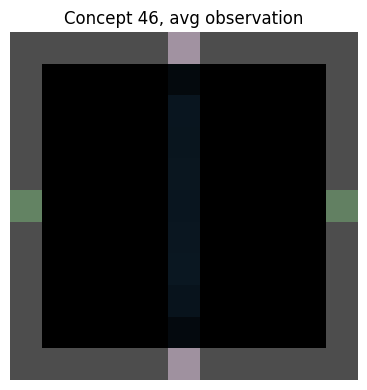

Showing random observations from cluster 4


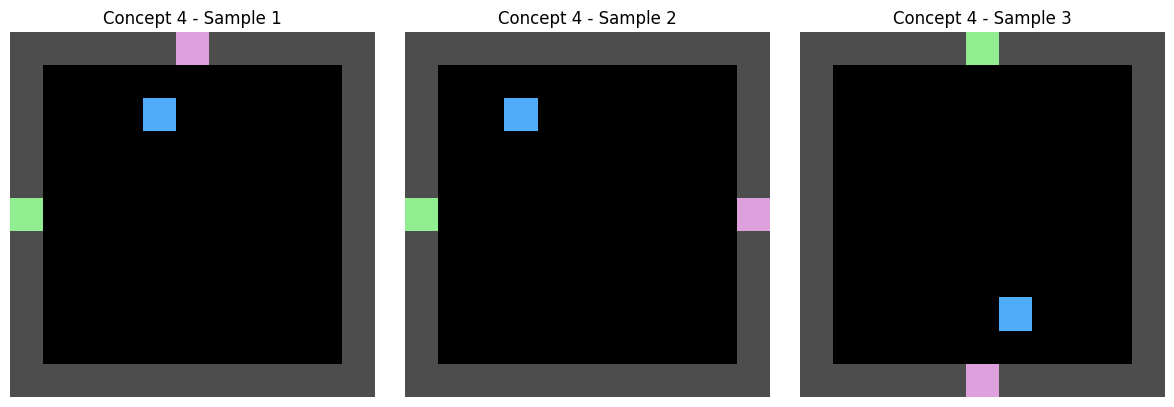

Showing random observations from cluster 11


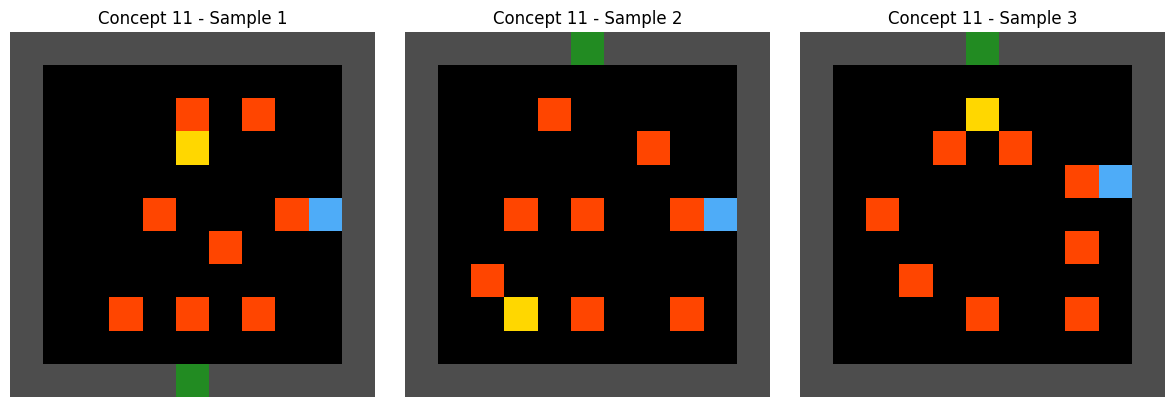

Showing random observations from cluster 15


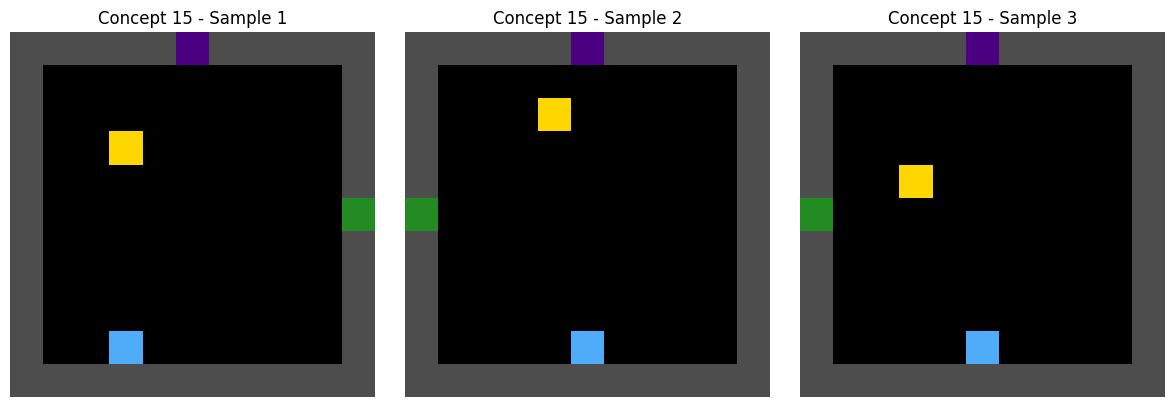

Showing random observations from cluster 18


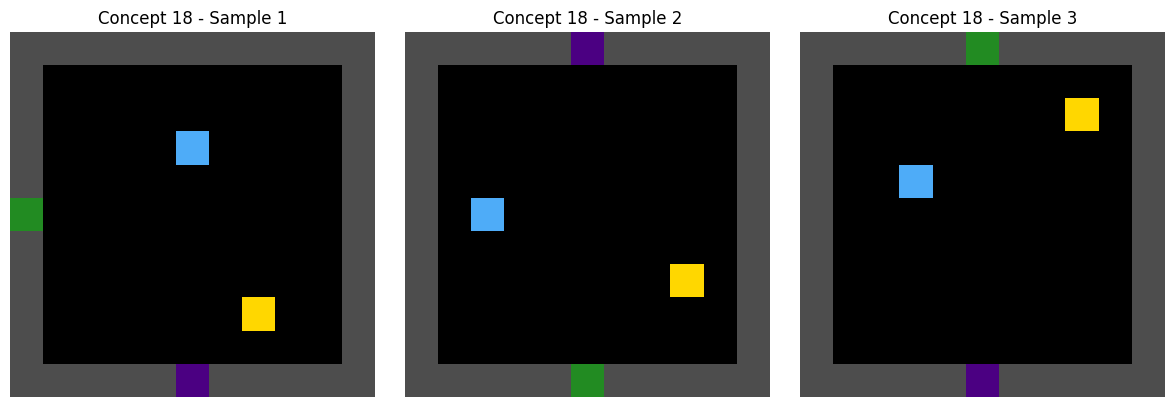

Showing random observations from cluster 26


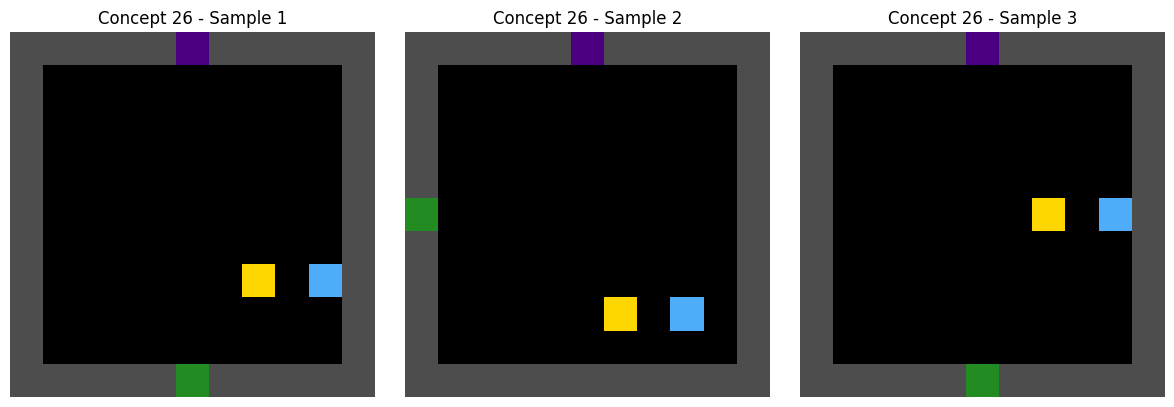

Showing random observations from cluster 27


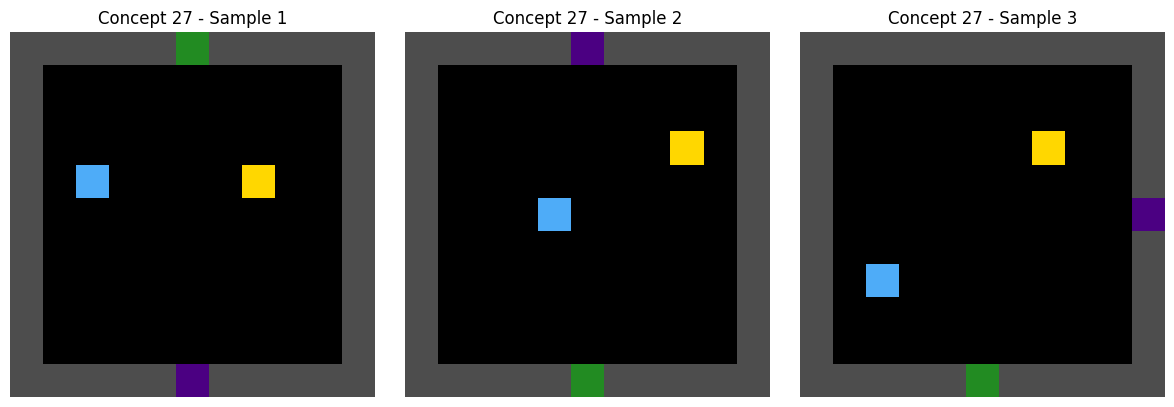

Showing random observations from cluster 29


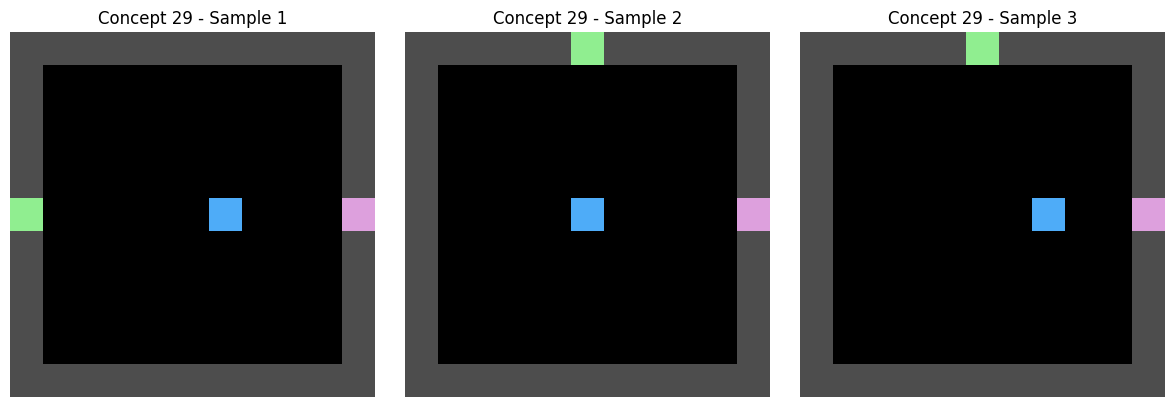

Showing random observations from cluster 35


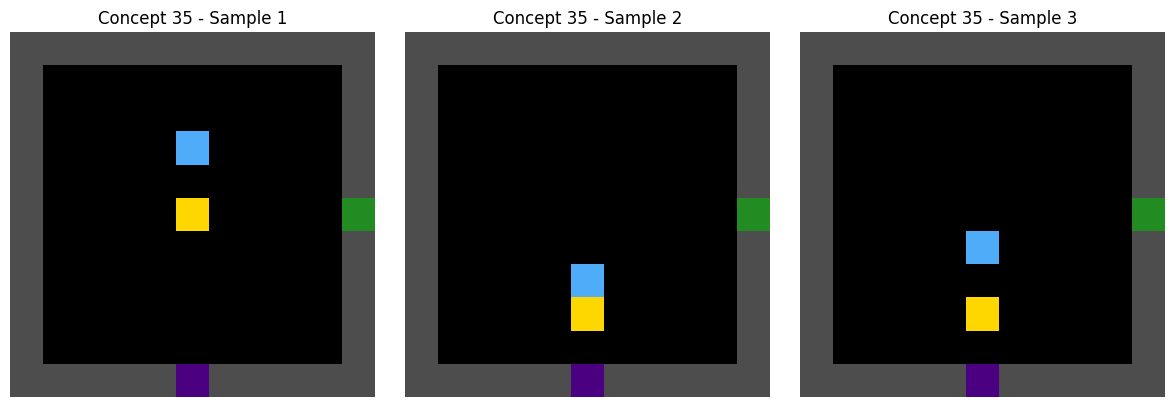

Showing random observations from cluster 44


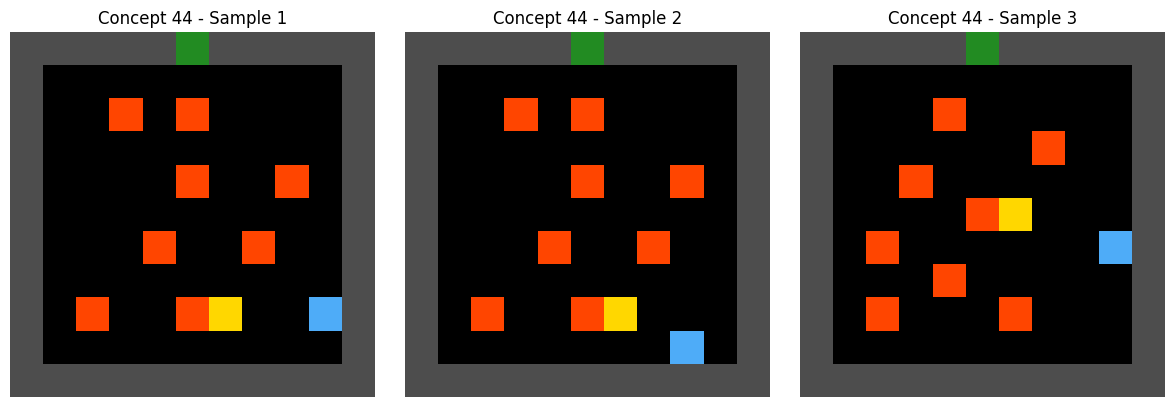

Showing random observations from cluster 46


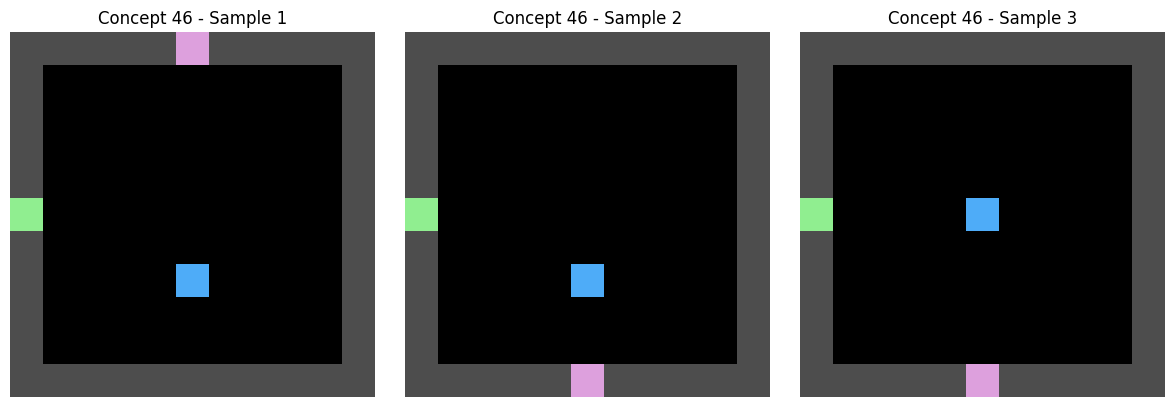

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


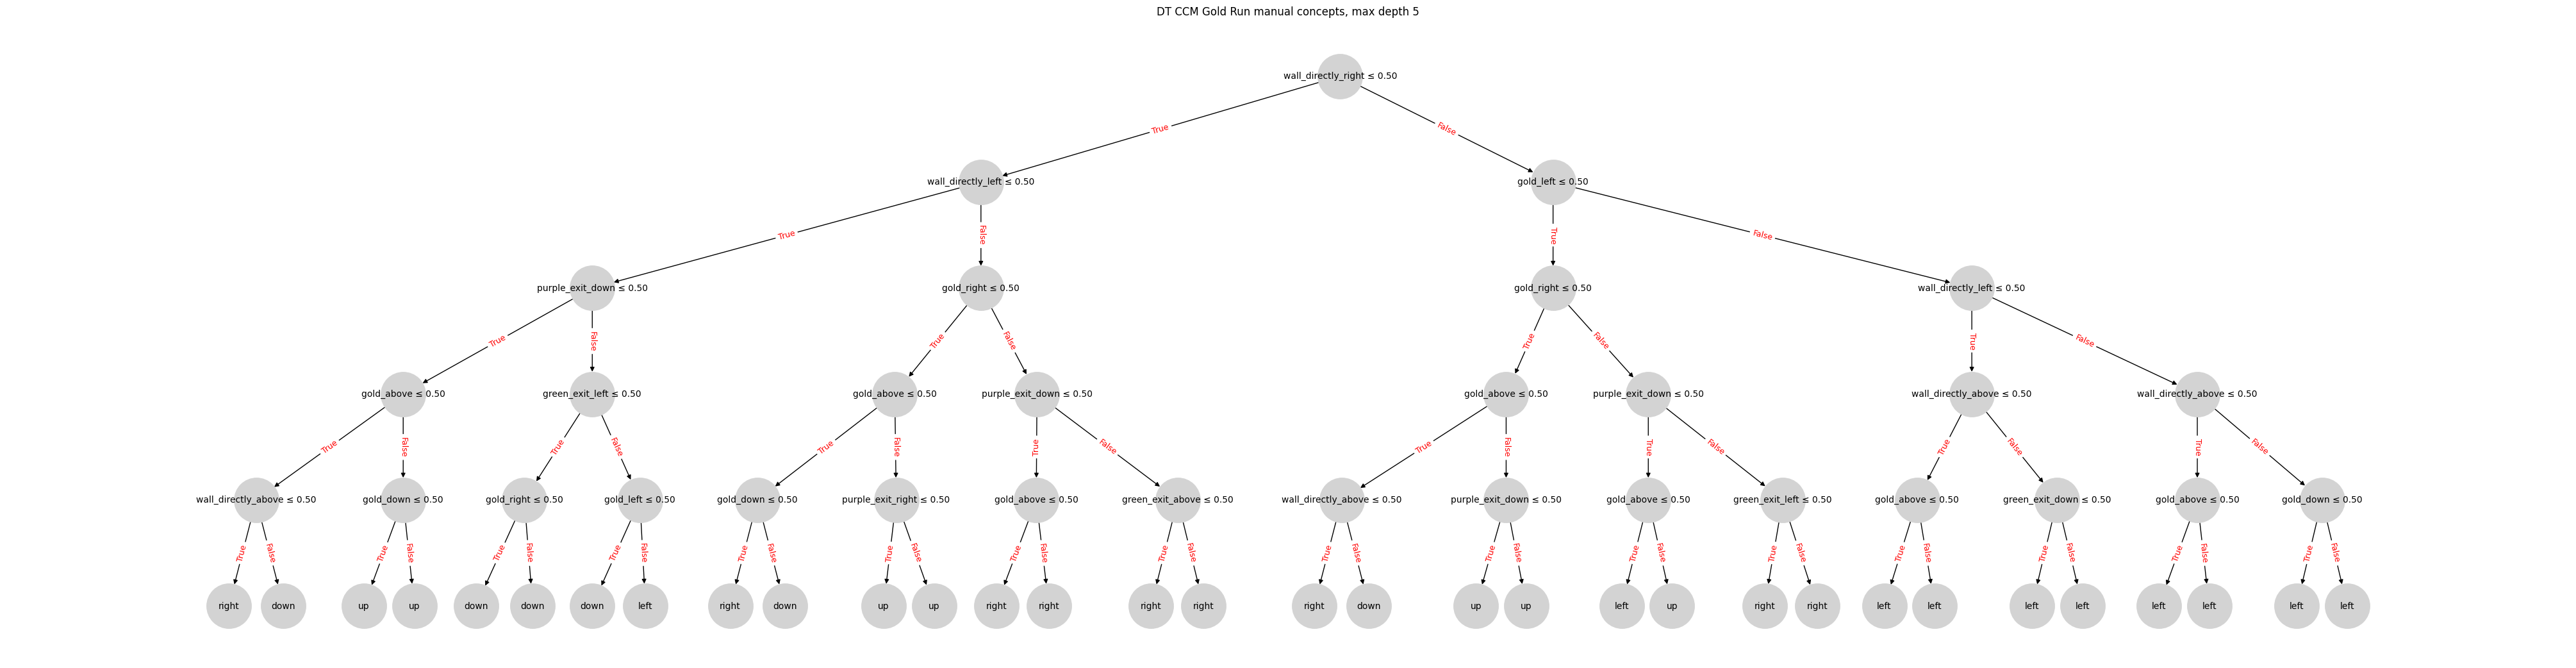

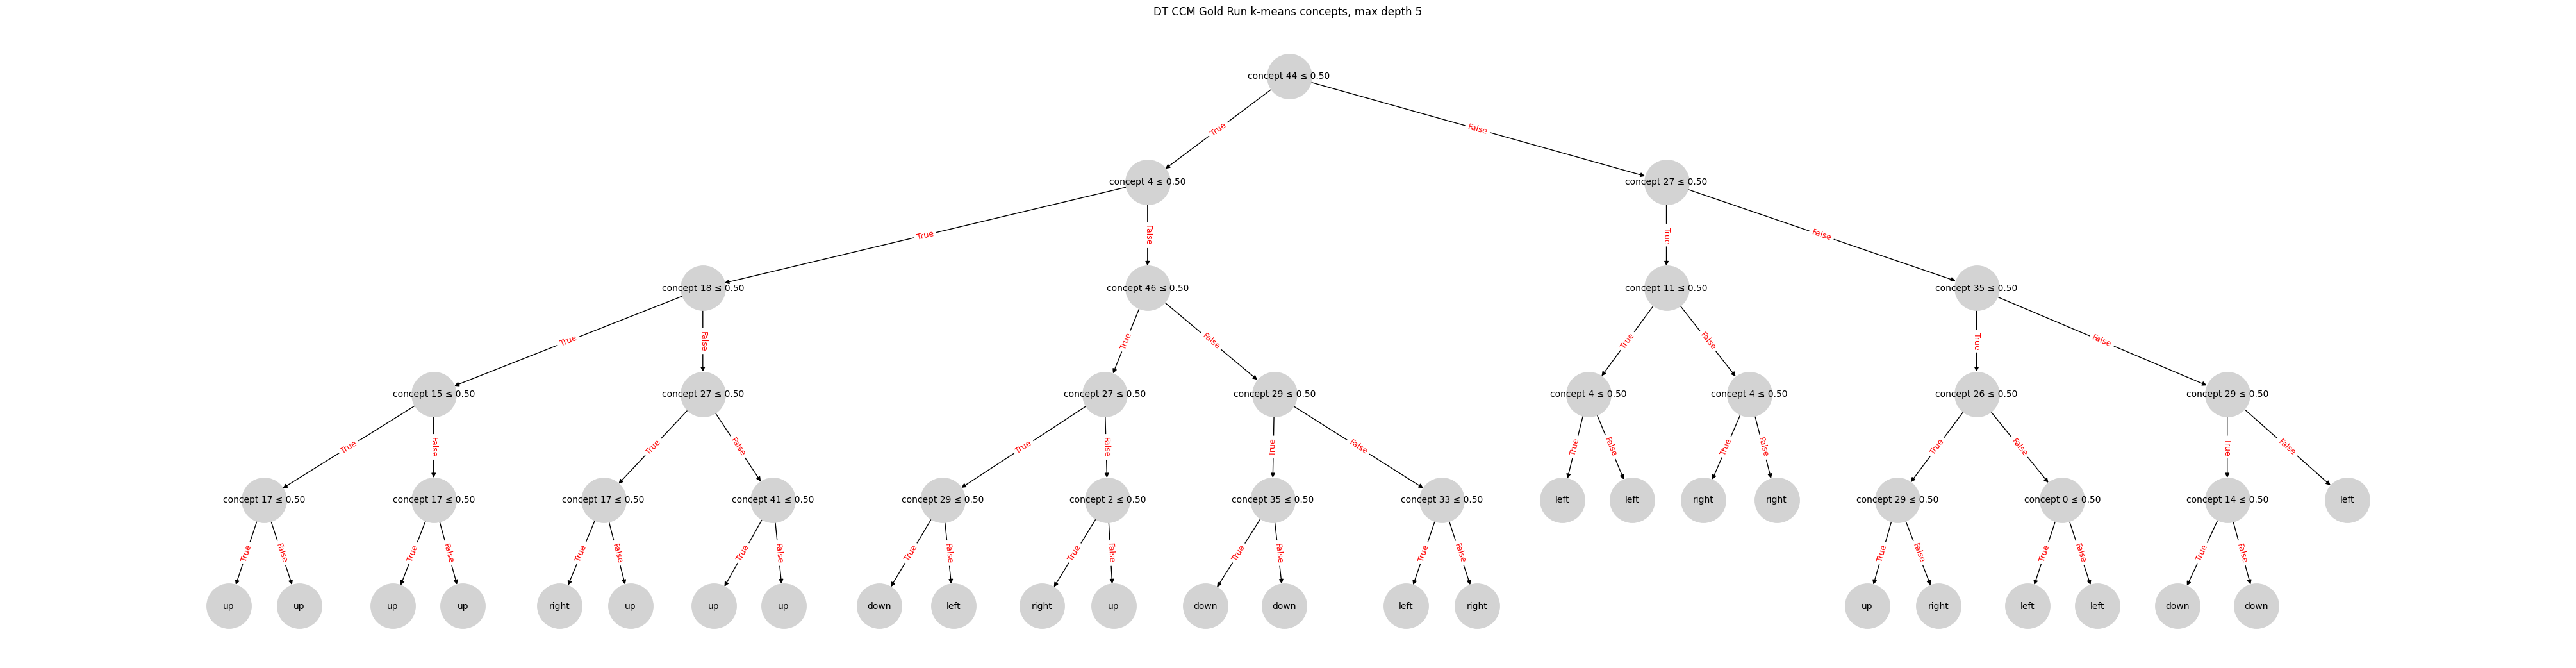

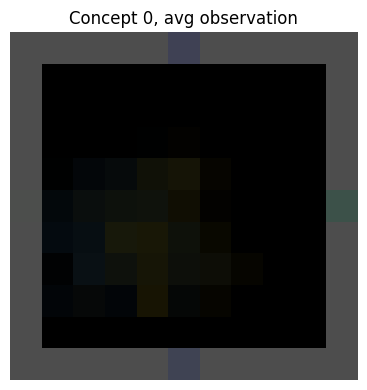

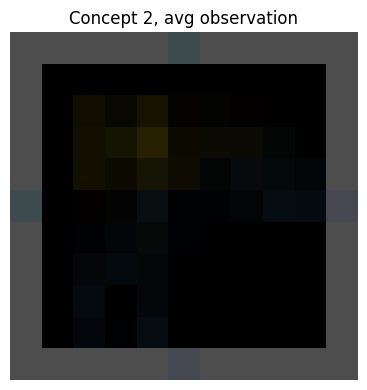

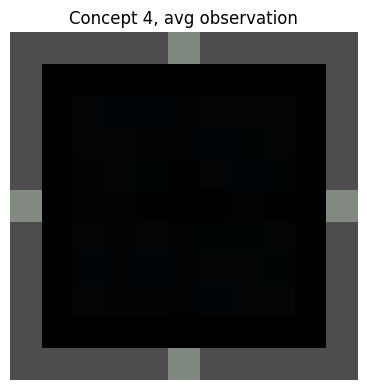

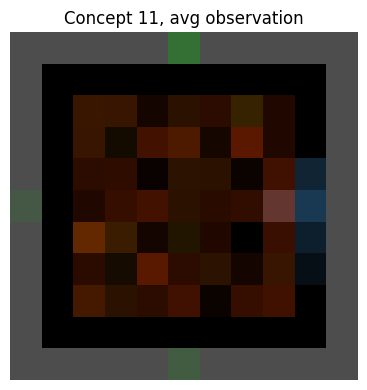

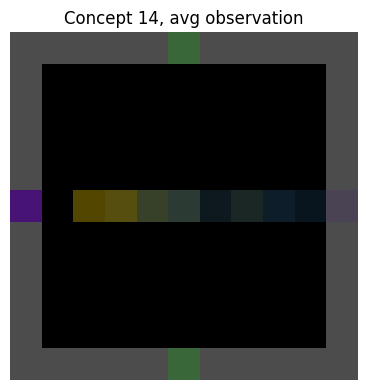

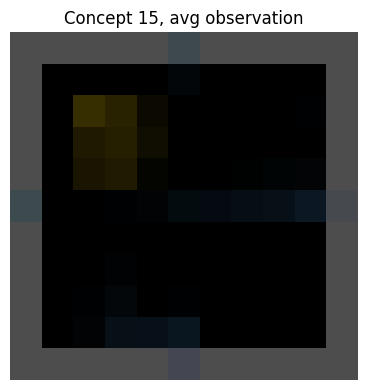

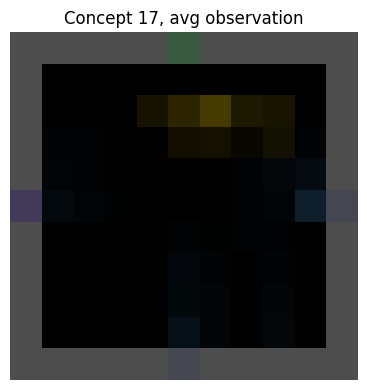

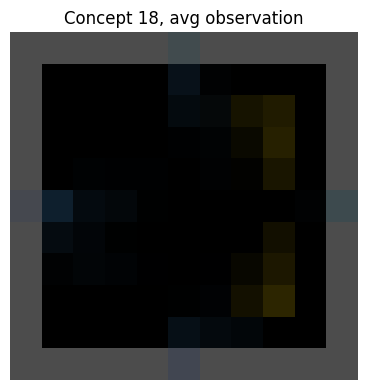

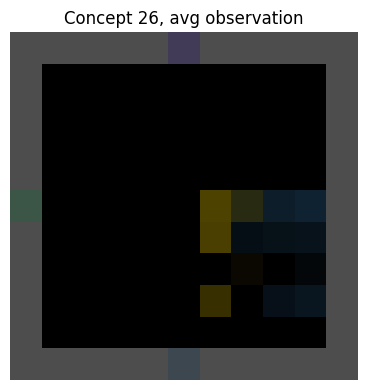

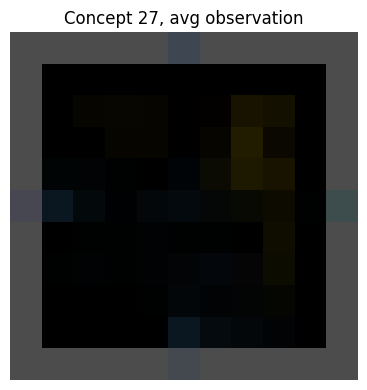

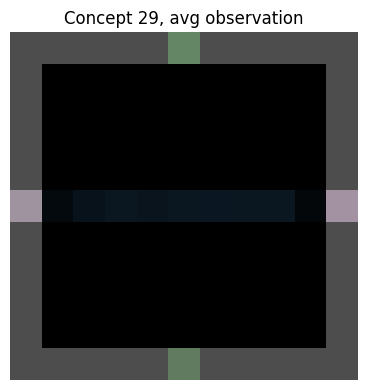

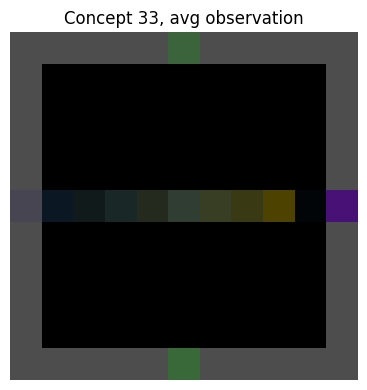

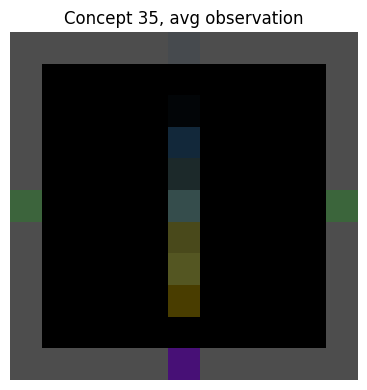

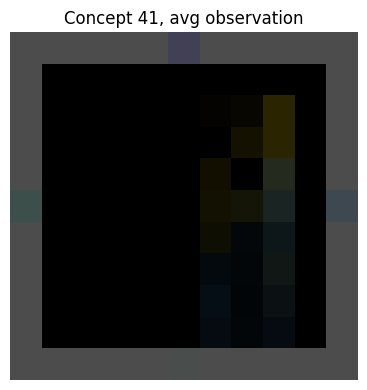

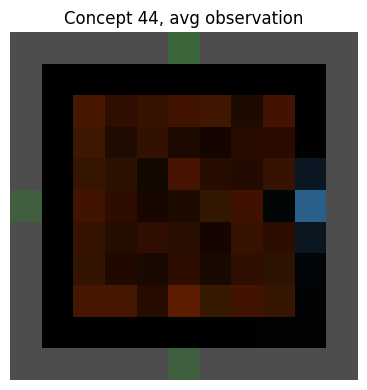

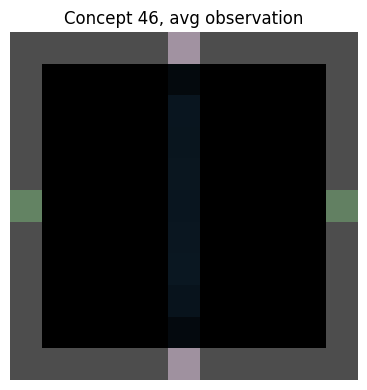

Showing random observations from cluster 0


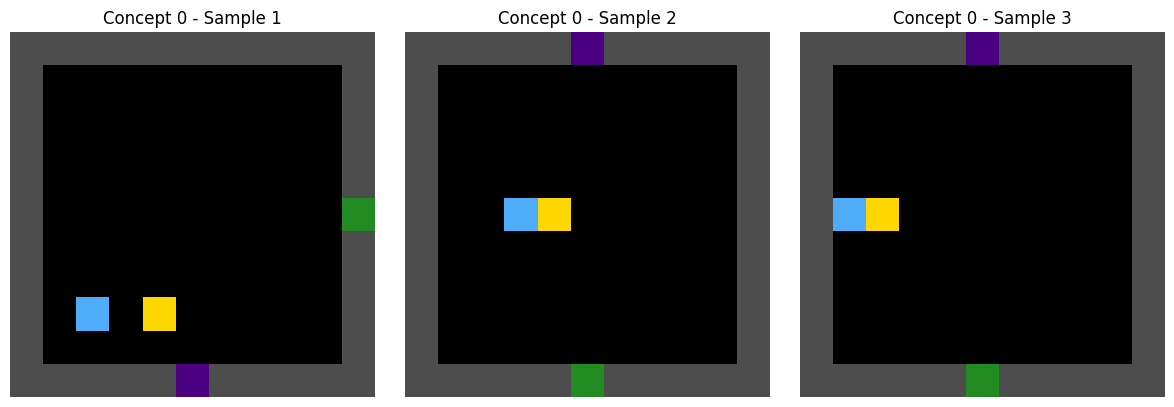

Showing random observations from cluster 2


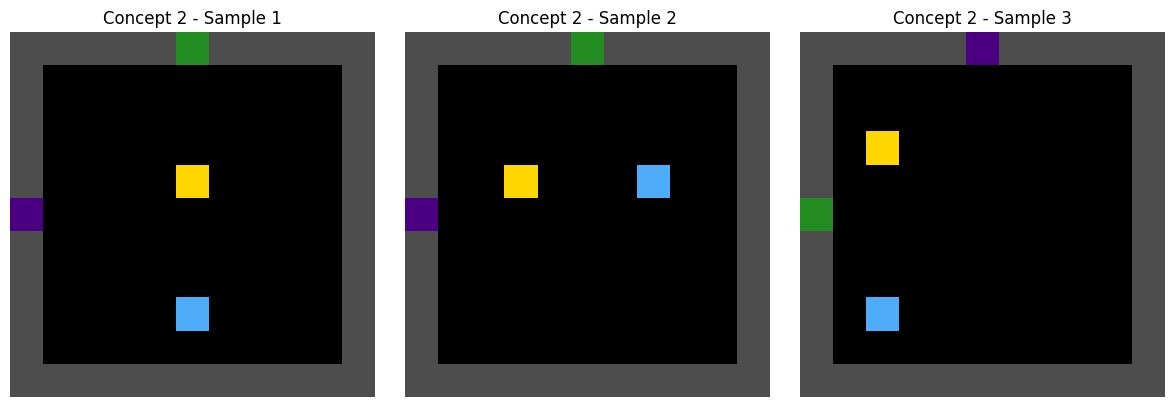

Showing random observations from cluster 4


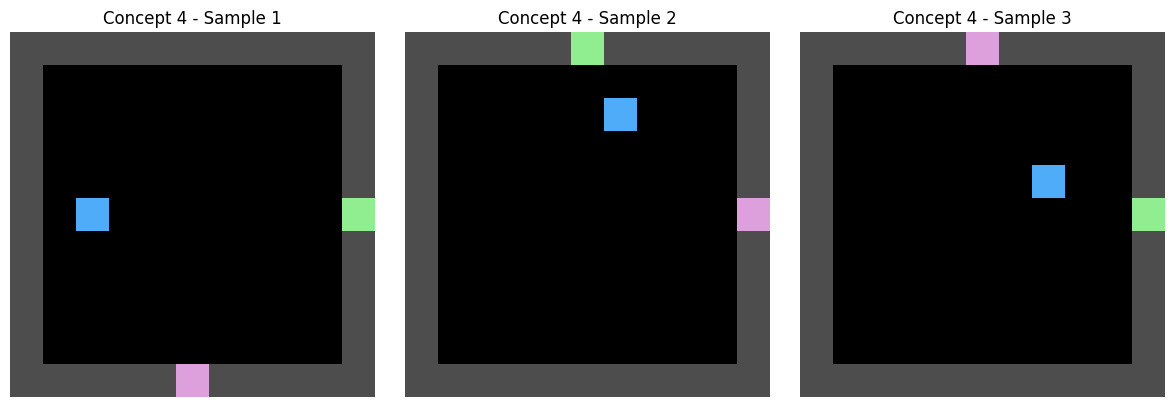

Showing random observations from cluster 11


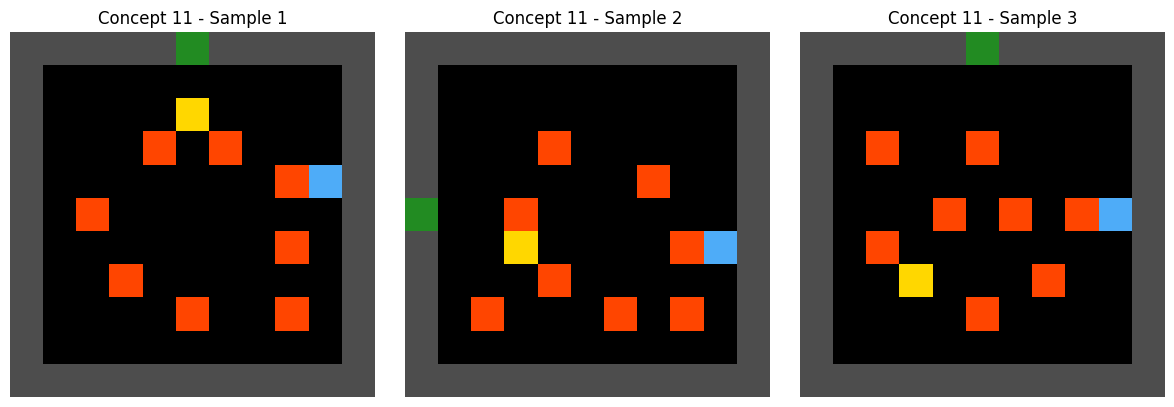

Showing random observations from cluster 14


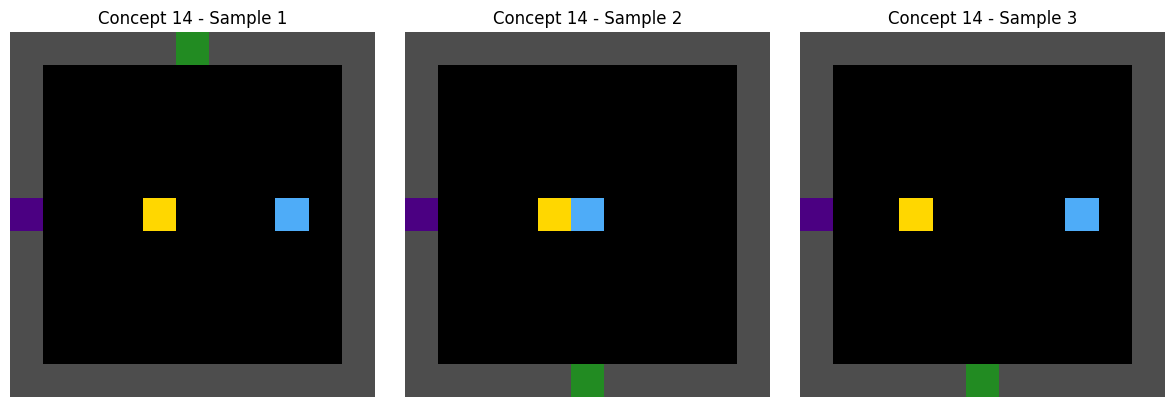

Showing random observations from cluster 15


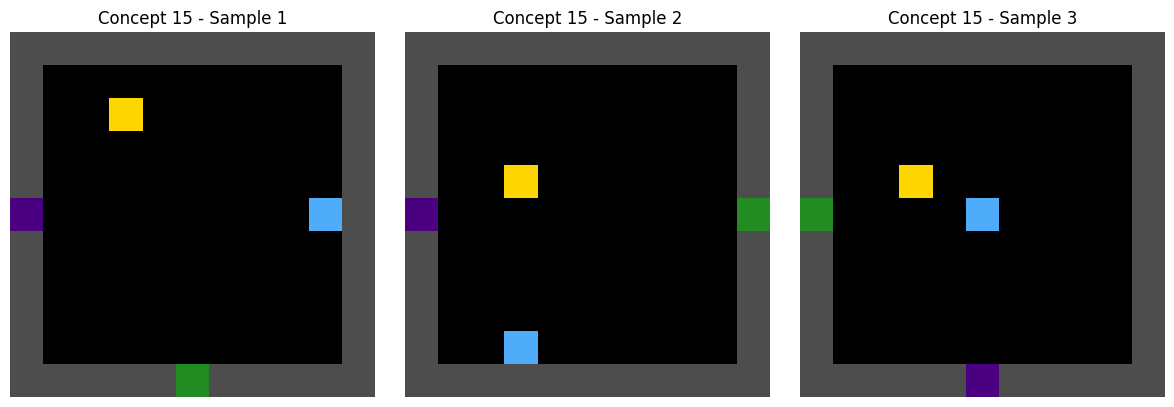

Showing random observations from cluster 17


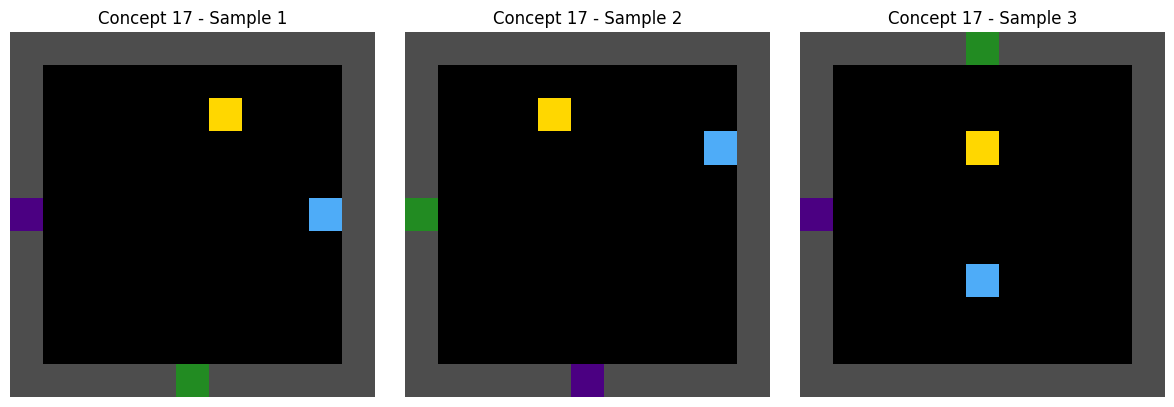

Showing random observations from cluster 18


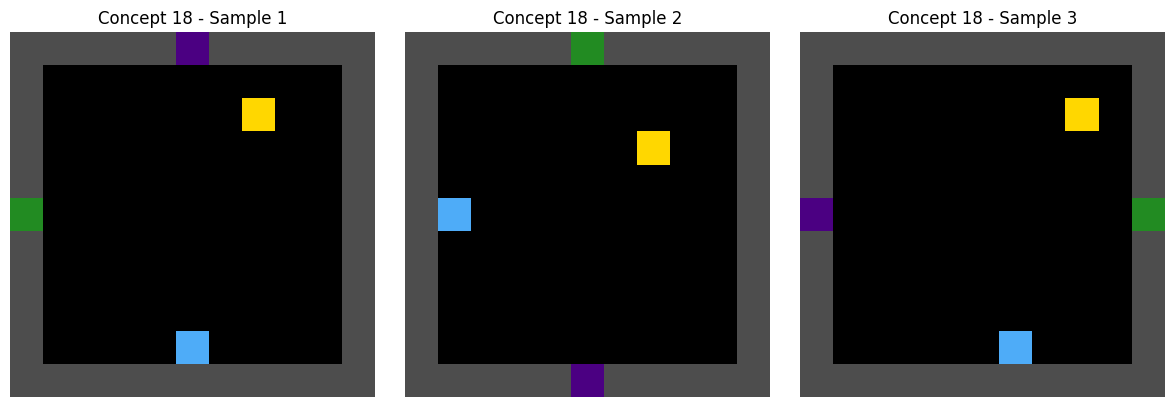

Showing random observations from cluster 26


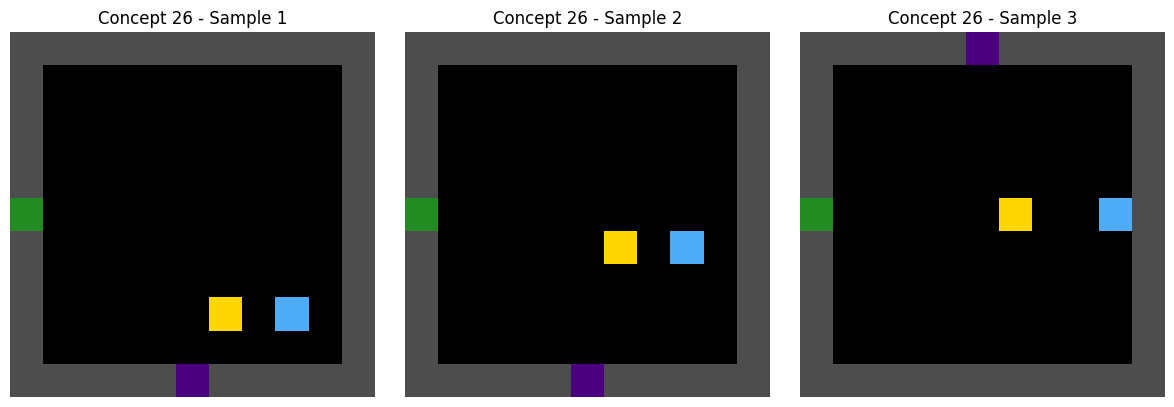

Showing random observations from cluster 27


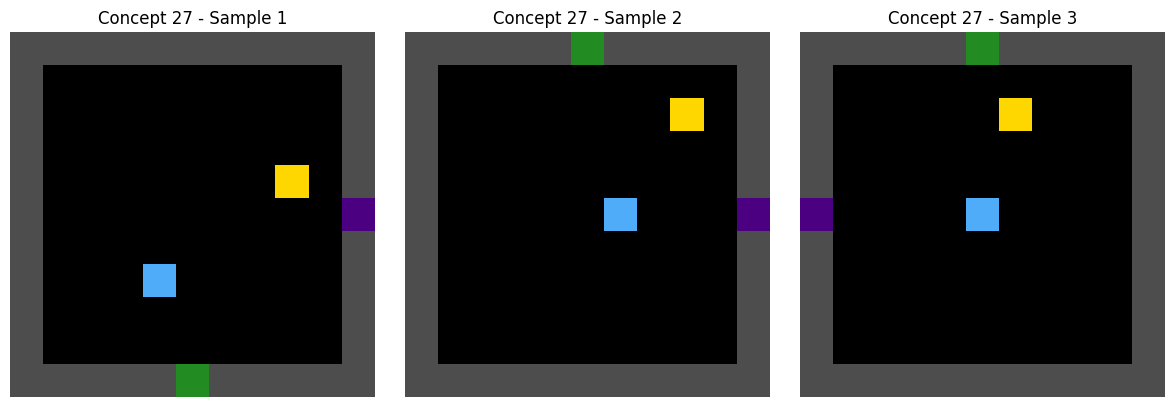

Showing random observations from cluster 29


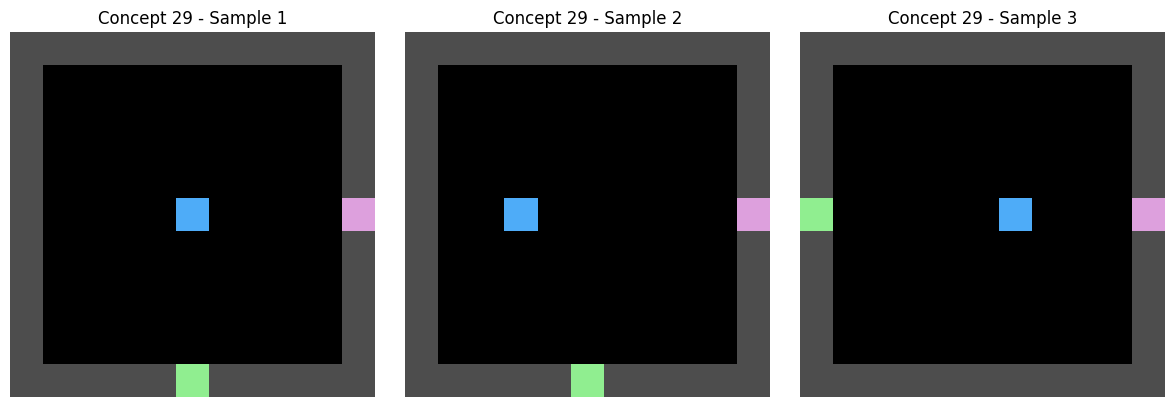

Showing random observations from cluster 33


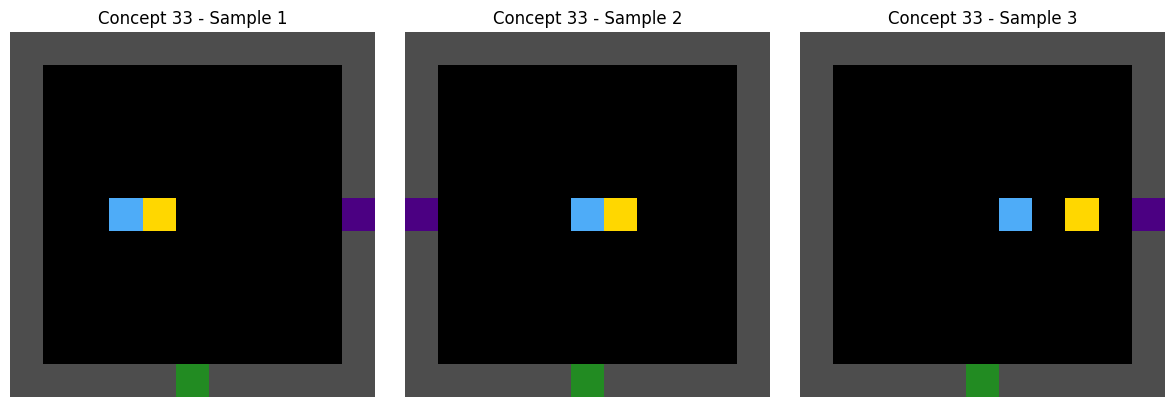

Showing random observations from cluster 35


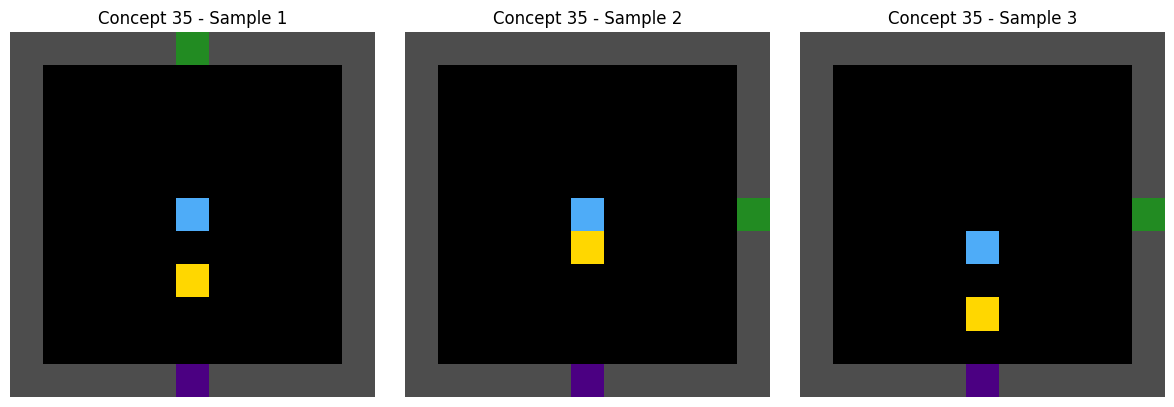

Showing random observations from cluster 41


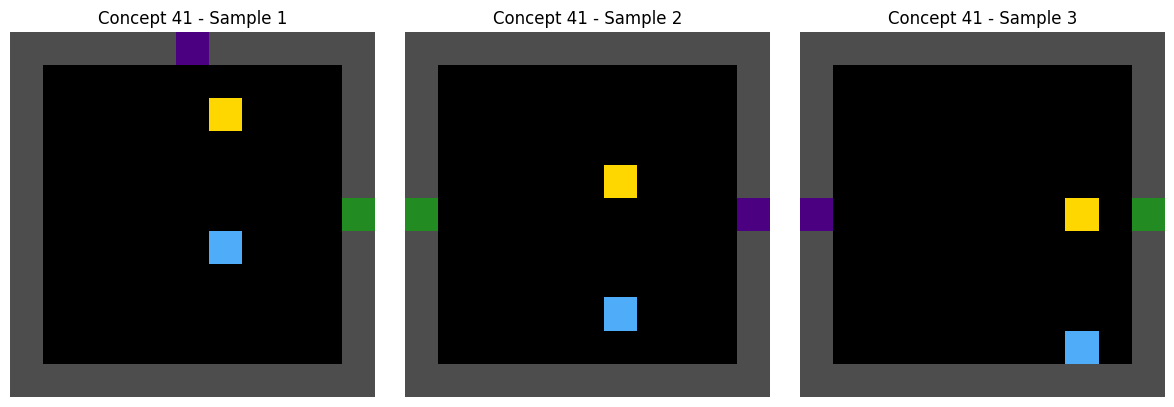

Showing random observations from cluster 44


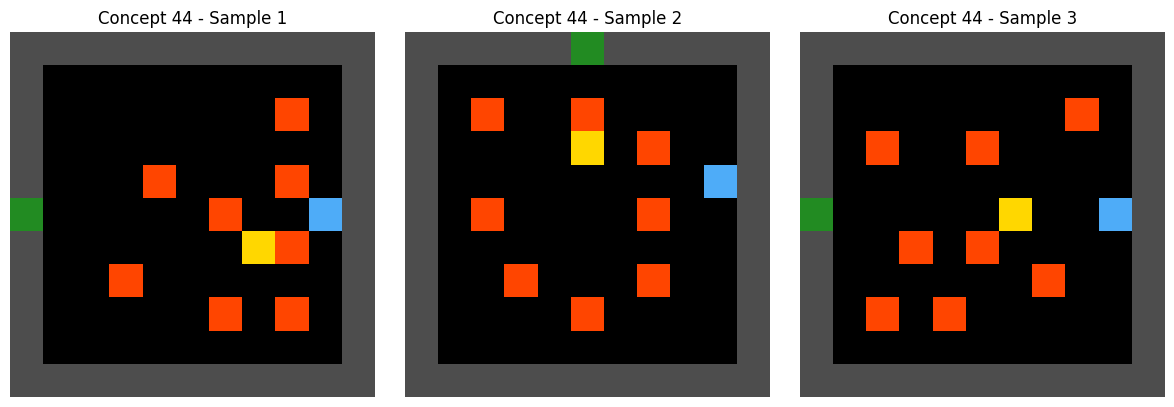

Showing random observations from cluster 46


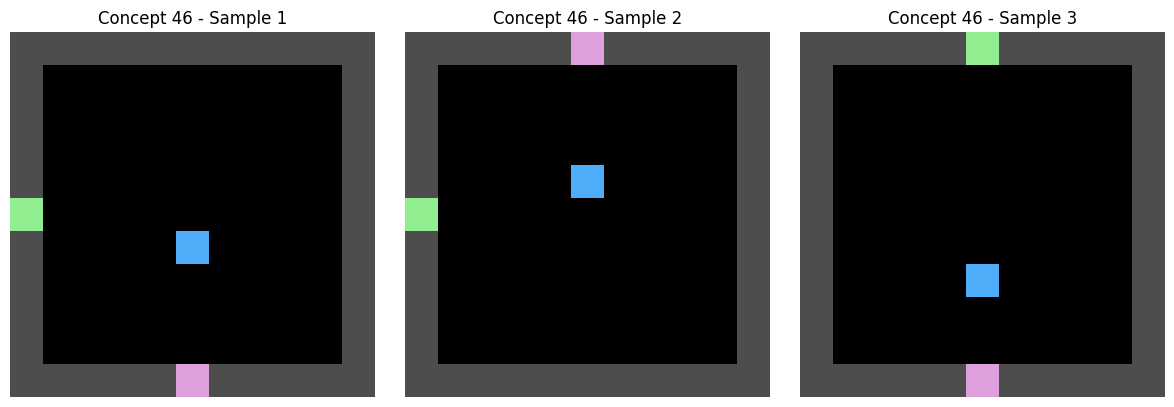

In [3]:
grm_concept_names_manual_dt = pd.read_csv("../../rl_ccm_data/completeness_scores/gold_run_mini/firm-mountain-13/ccm_dt/manual_concepts_used_names.csv").sort_values("feature_index")["concept_name"].tolist()

grm_action_dict = {
    0: "up",
    1: "right",
    2: "down",
    3: "left",
}

model: Sequential = load_model("../../models/GoldRunMini/sub-competent/firm-mountain-13/model_time_step_457199_episode_15800____0.4878avg____0.5000max____0.4532min.keras")  # type: ignore

mao = ModelActivationObtainer(model=model, input_normalization_type="image")

grm_clustered_obs = np.load("../../rl_concept_discovery_data/class_datasets_model_of_interest/gold_run_mini/target_class_balanced_6900_shuffled_examples.npy")
grm_k_means_clustered_labels = np.load("../../rl_ace_data/concept_examples/k_means/gold_run_mini/model_of_interest_target_class_balanced_observations/layer_4/k_50_cluster_labels.npy")

grm_clustered_obs_activations = mao.get_layer_activations(layer_index=5, model_inputs=grm_clustered_obs, flatten=True)
grm_k_means_clustered_controids = np.load("../../rl_ace_data/concept_examples/k_means/gold_run_mini/model_of_interest_target_class_balanced_observations/layer_4/k_50_cluster_centroids.npy")

grm_k_means_clustered_distances = np.array([
    norm(grm_clustered_obs_activations[i] - grm_k_means_clustered_controids[label])
    for i, label in enumerate(grm_k_means_clustered_labels)
])

for max_depth in range(3,6):
    grm_manual_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gold_run_mini/firm-mountain-13/ccm_dt/best_ccm_manual_layer_5_c_15_all_q_max_depth_{max_depth}.joblib")
    grm_k_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gold_run_mini/firm-mountain-13/ccm_dt/best_ccm_k_means_layer_4_k_50_all_q_max_depth_{max_depth}.joblib")
    grm_fc_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/gold_run_mini/firm-mountain-13/ccm_dt/best_ccm_fc_means_layer_5_c_39_all_q_max_depth_{max_depth}.joblib")

    graph = build_custom_graph(grm_manual_concepts_dt.tree_, grm_action_dict, grm_concept_names_manual_dt)
    draw_custom_tree(graph, max_depth, f"DT CCM Gold Run manual concepts, max depth {max_depth}")

    graph = build_custom_graph(grm_k_means_concepts_dt.tree_, grm_action_dict)
    draw_custom_tree(graph, max_depth, f"DT CCM Gold Run k-means concepts, max depth {max_depth}")

    used_clusters = np.unique(grm_k_means_concepts_dt.tree_.feature) # type: ignore
    used_clusters = used_clusters[used_clusters != -2] 

    visualize_avg_cluster_observation(clustered_observations=grm_clustered_obs,
    clustered_observations_labels=grm_k_means_clustered_labels,
    distances=grm_k_means_clustered_distances,
    clusters_to_show=used_clusters,
    show=True,
    )

    for cluster_id in used_clusters:
        print(f"Showing random observations from cluster {cluster_id}")
        cluster_indices = np.where(grm_k_means_clustered_labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            continue  # skip if no examples (just in case)

        # Select up to 3 random indices
        selected_indices = random.sample(list(cluster_indices), min(3, len(cluster_indices)))
        selected_images = grm_clustered_obs[selected_indices]

        fig, axes = plt.subplots(1, len(selected_images), figsize=(4 * len(selected_images), 4))
        if len(selected_images) == 1:
            axes = [axes]

        for i, img in enumerate(selected_images):
            axes[i].imshow(img.astype(np.uint8))
            axes[i].set_title(f"Concept {cluster_id} - Sample {i+1}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

    #graph = build_custom_graph(grm_fc_means_concepts_dt.tree_, grm_action_dict)
    #draw_custom_tree(graph, max_depth, f"DT CCM Gold Run fuzzy c-means concepts, max depth {max_depth}")

### Minecart Counter

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


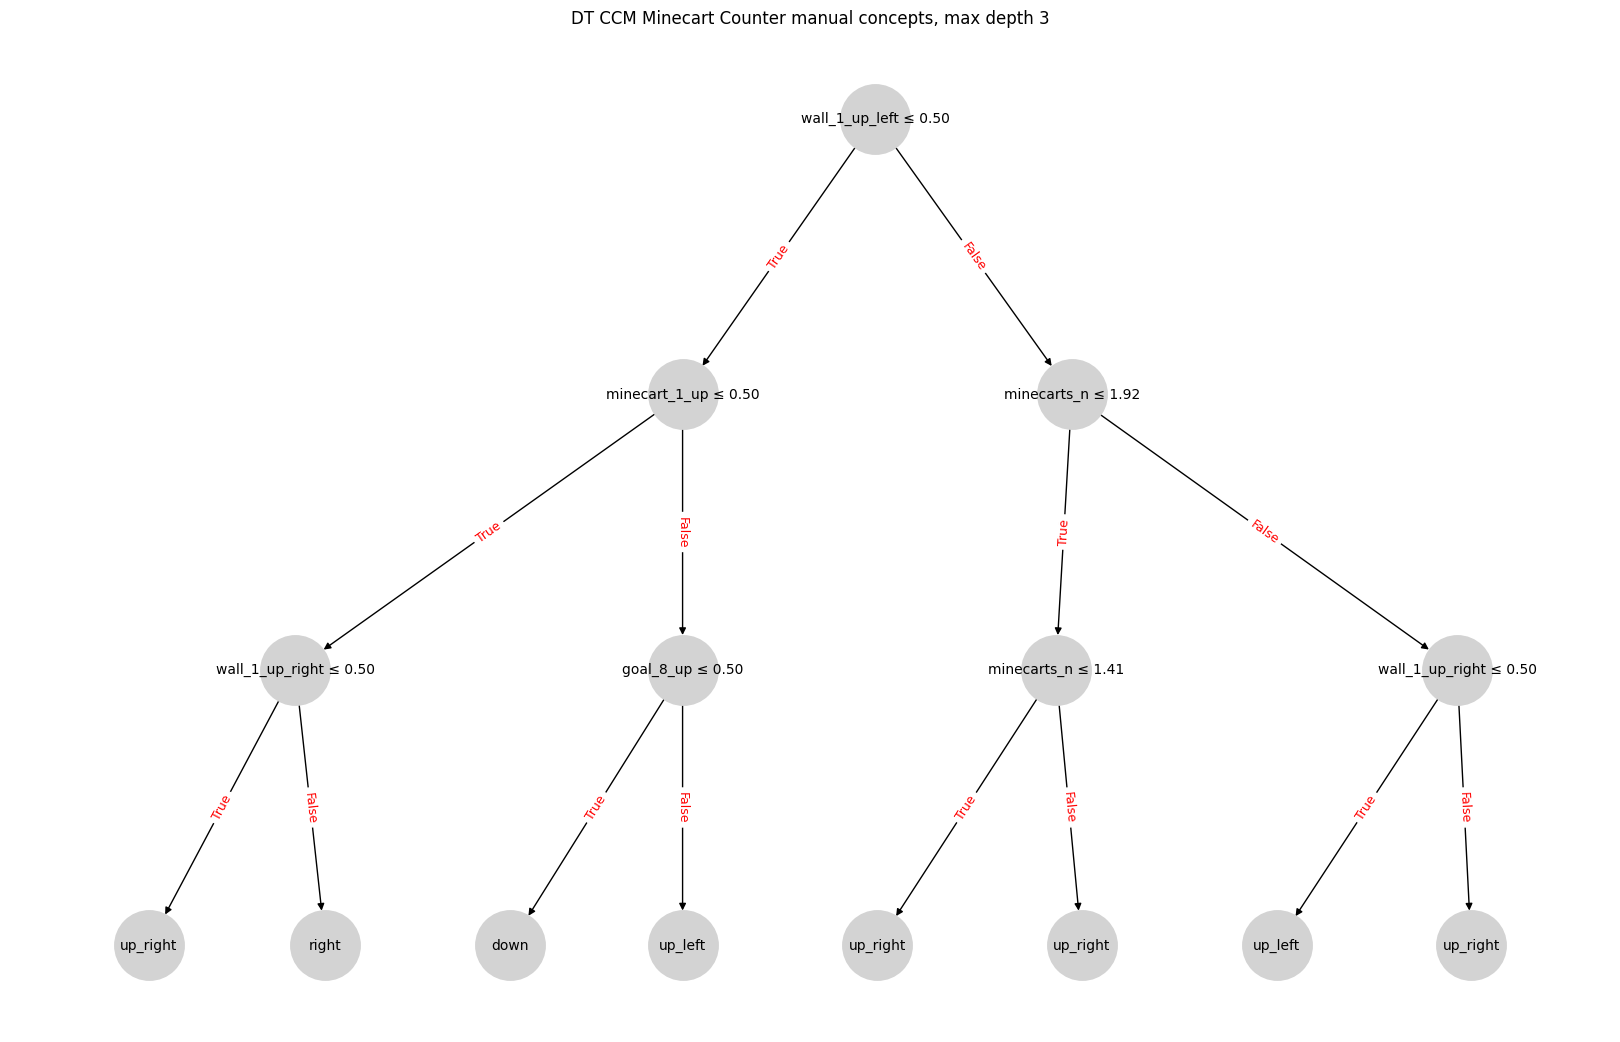

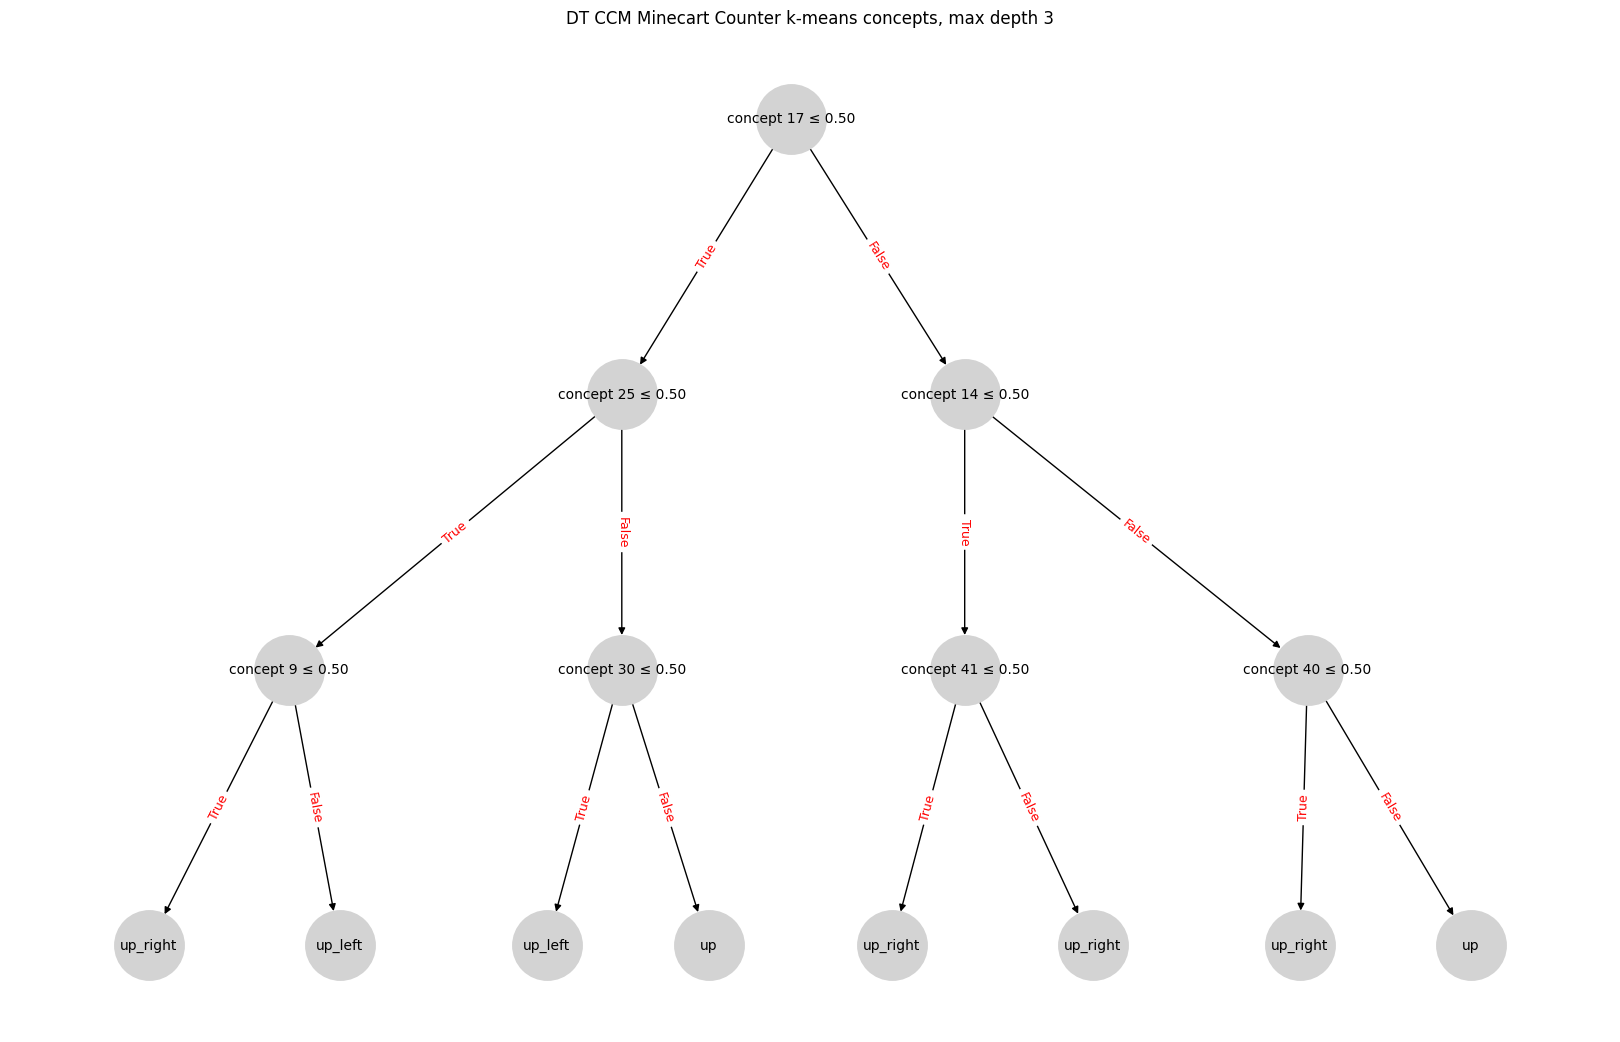

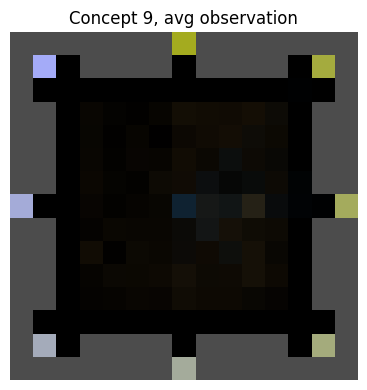

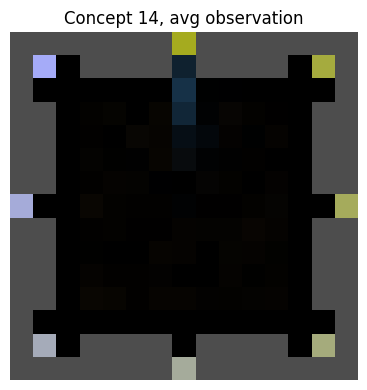

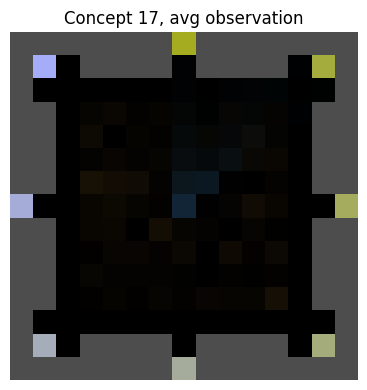

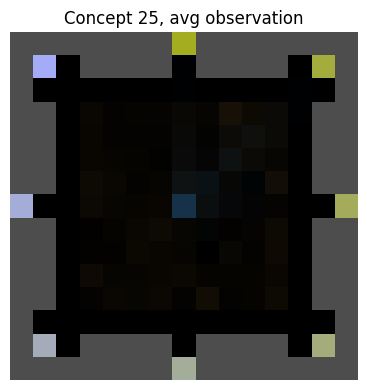

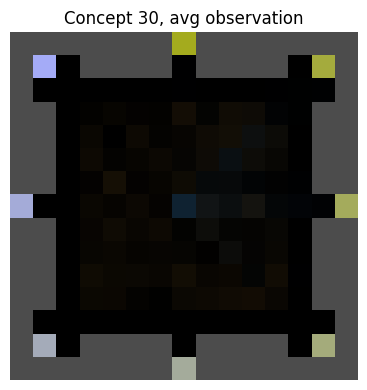

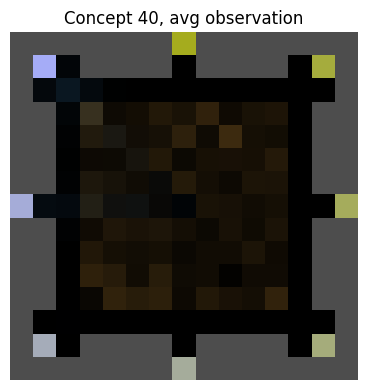

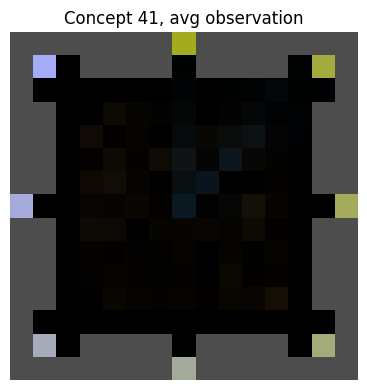

Showing random observations from cluster 9


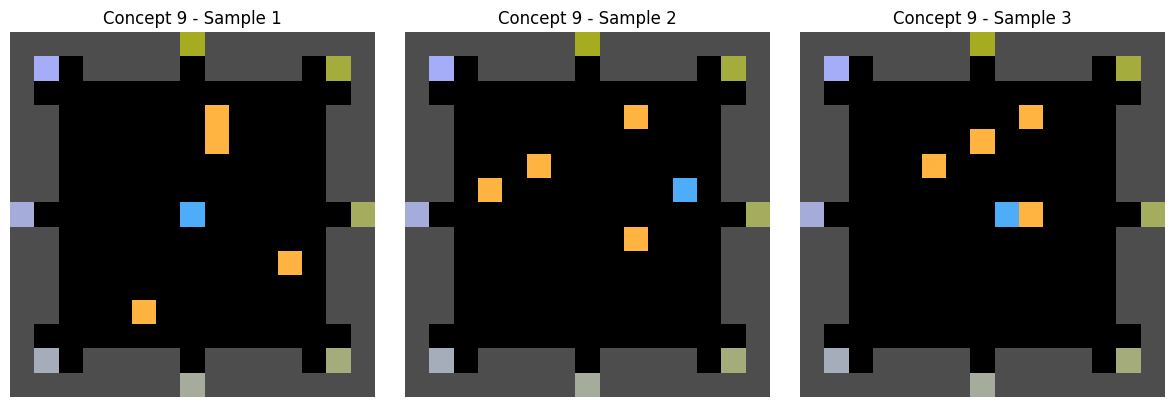

Showing random observations from cluster 14


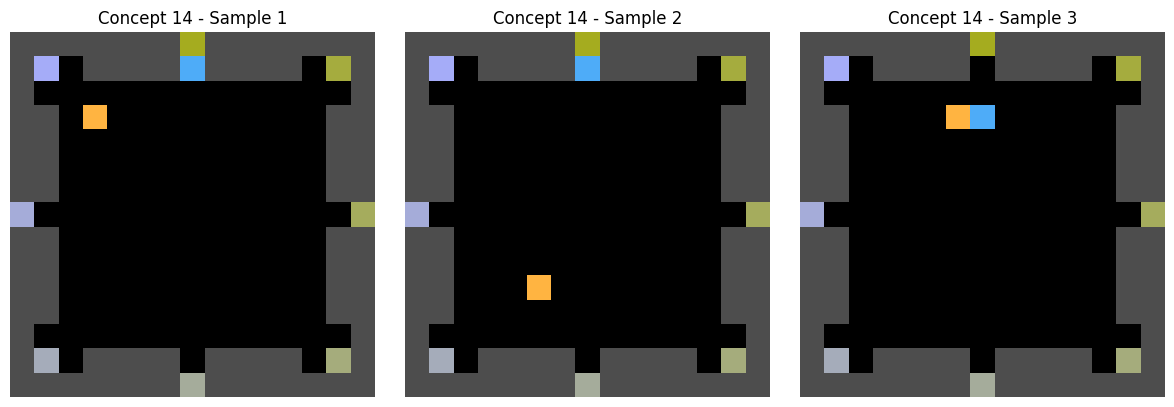

Showing random observations from cluster 17


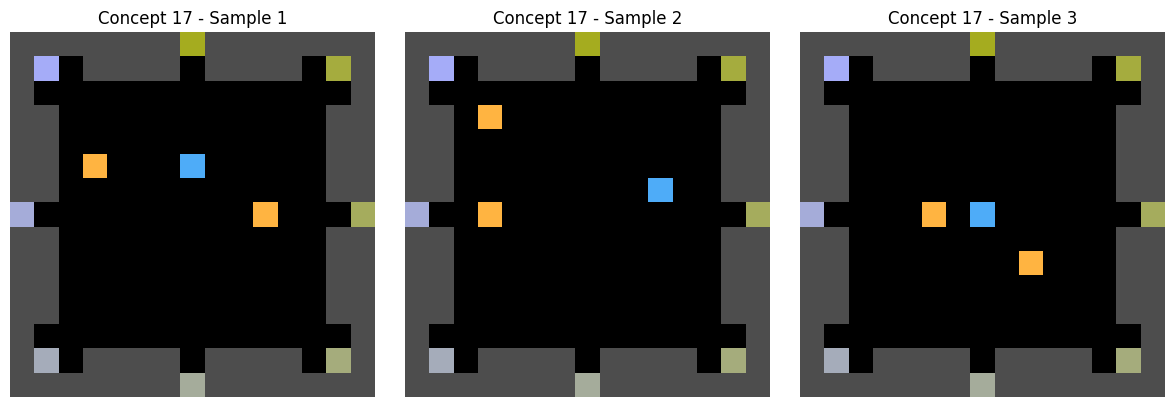

Showing random observations from cluster 25


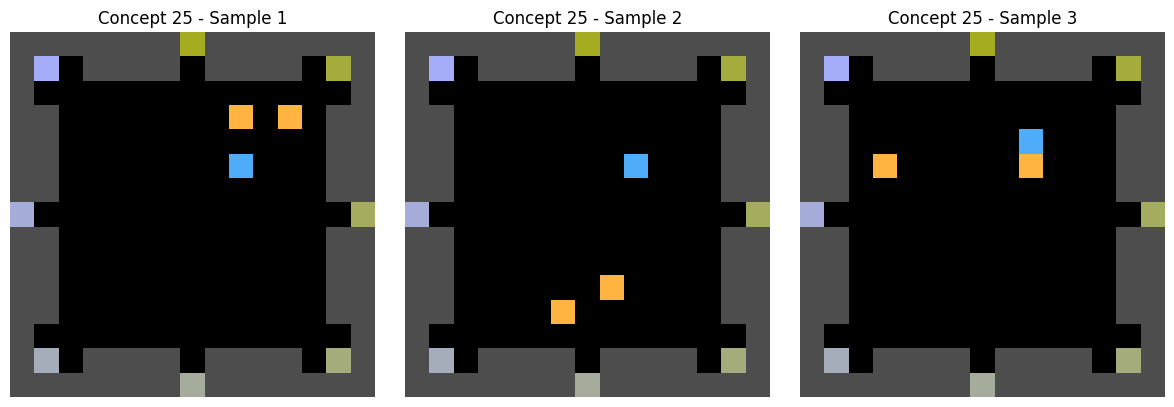

Showing random observations from cluster 30


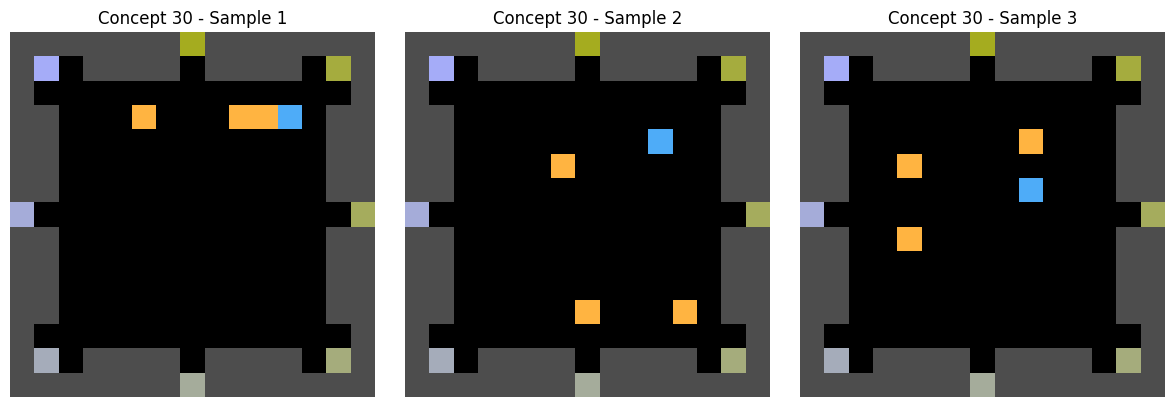

Showing random observations from cluster 40


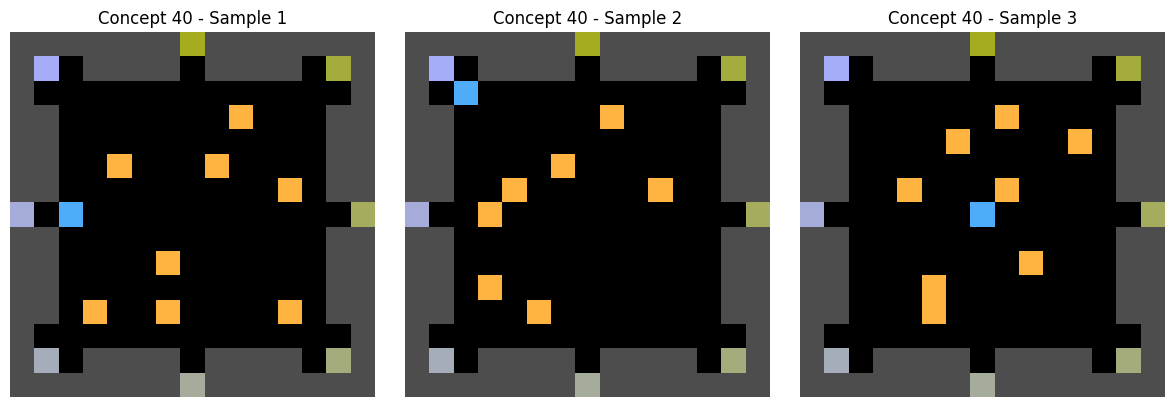

Showing random observations from cluster 41


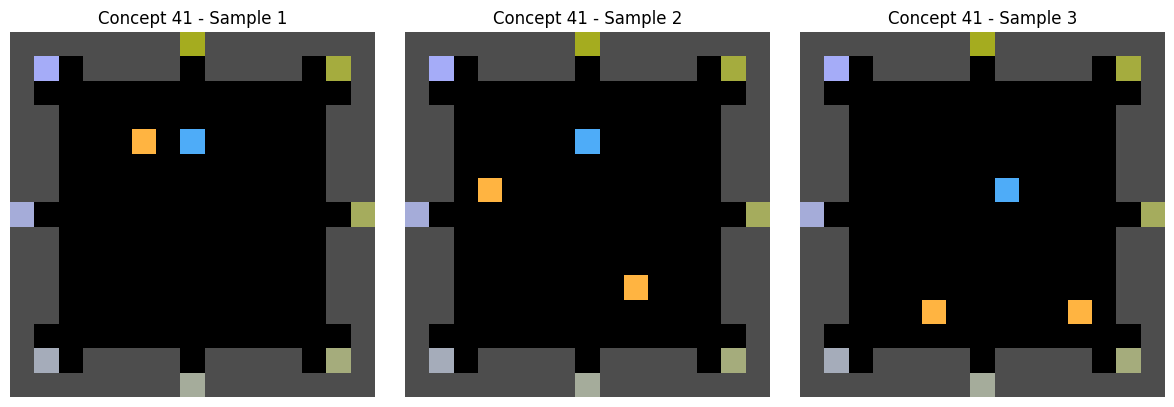

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


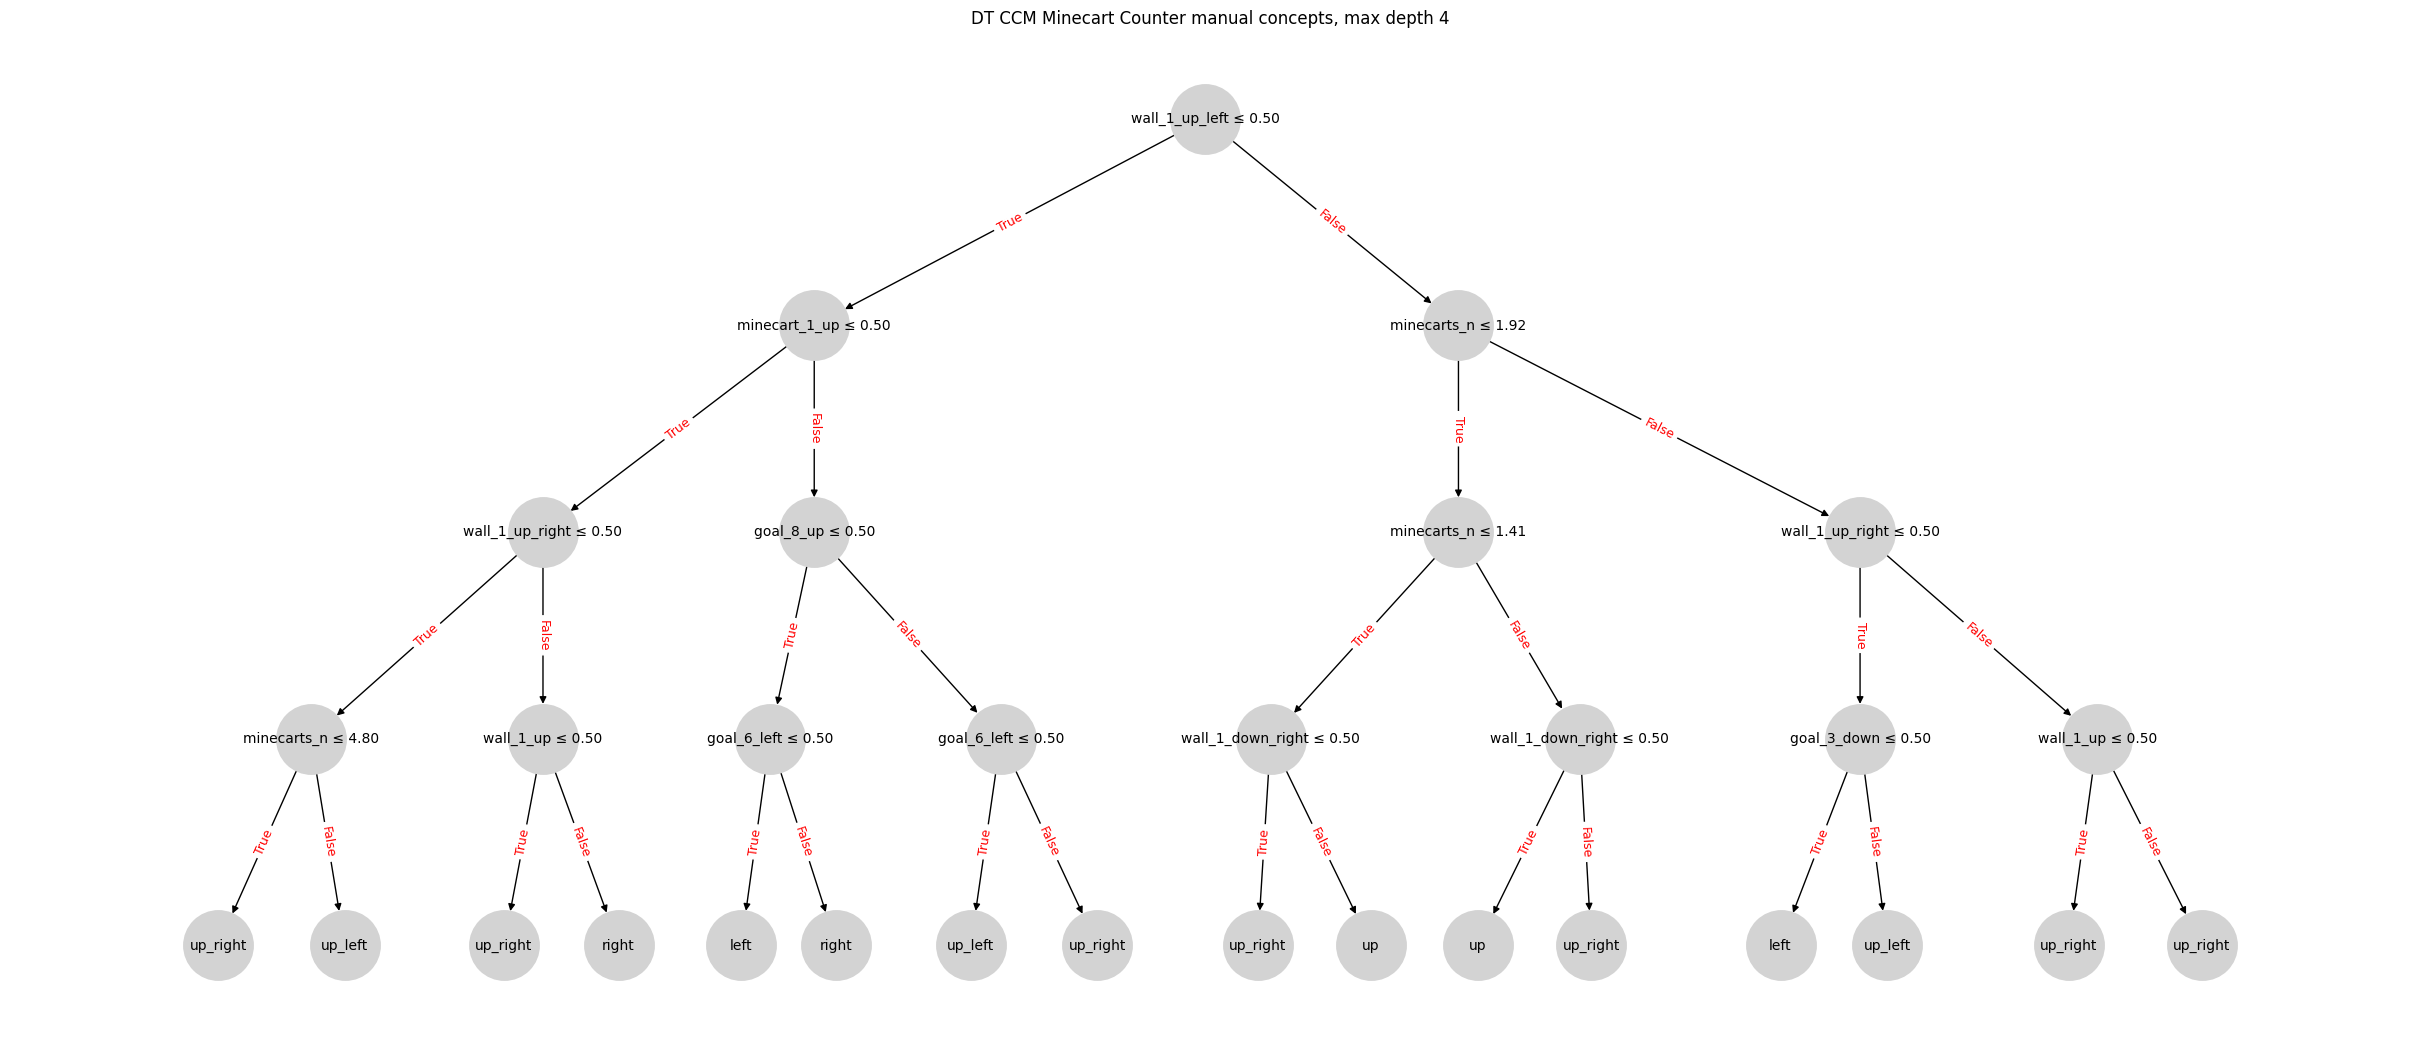

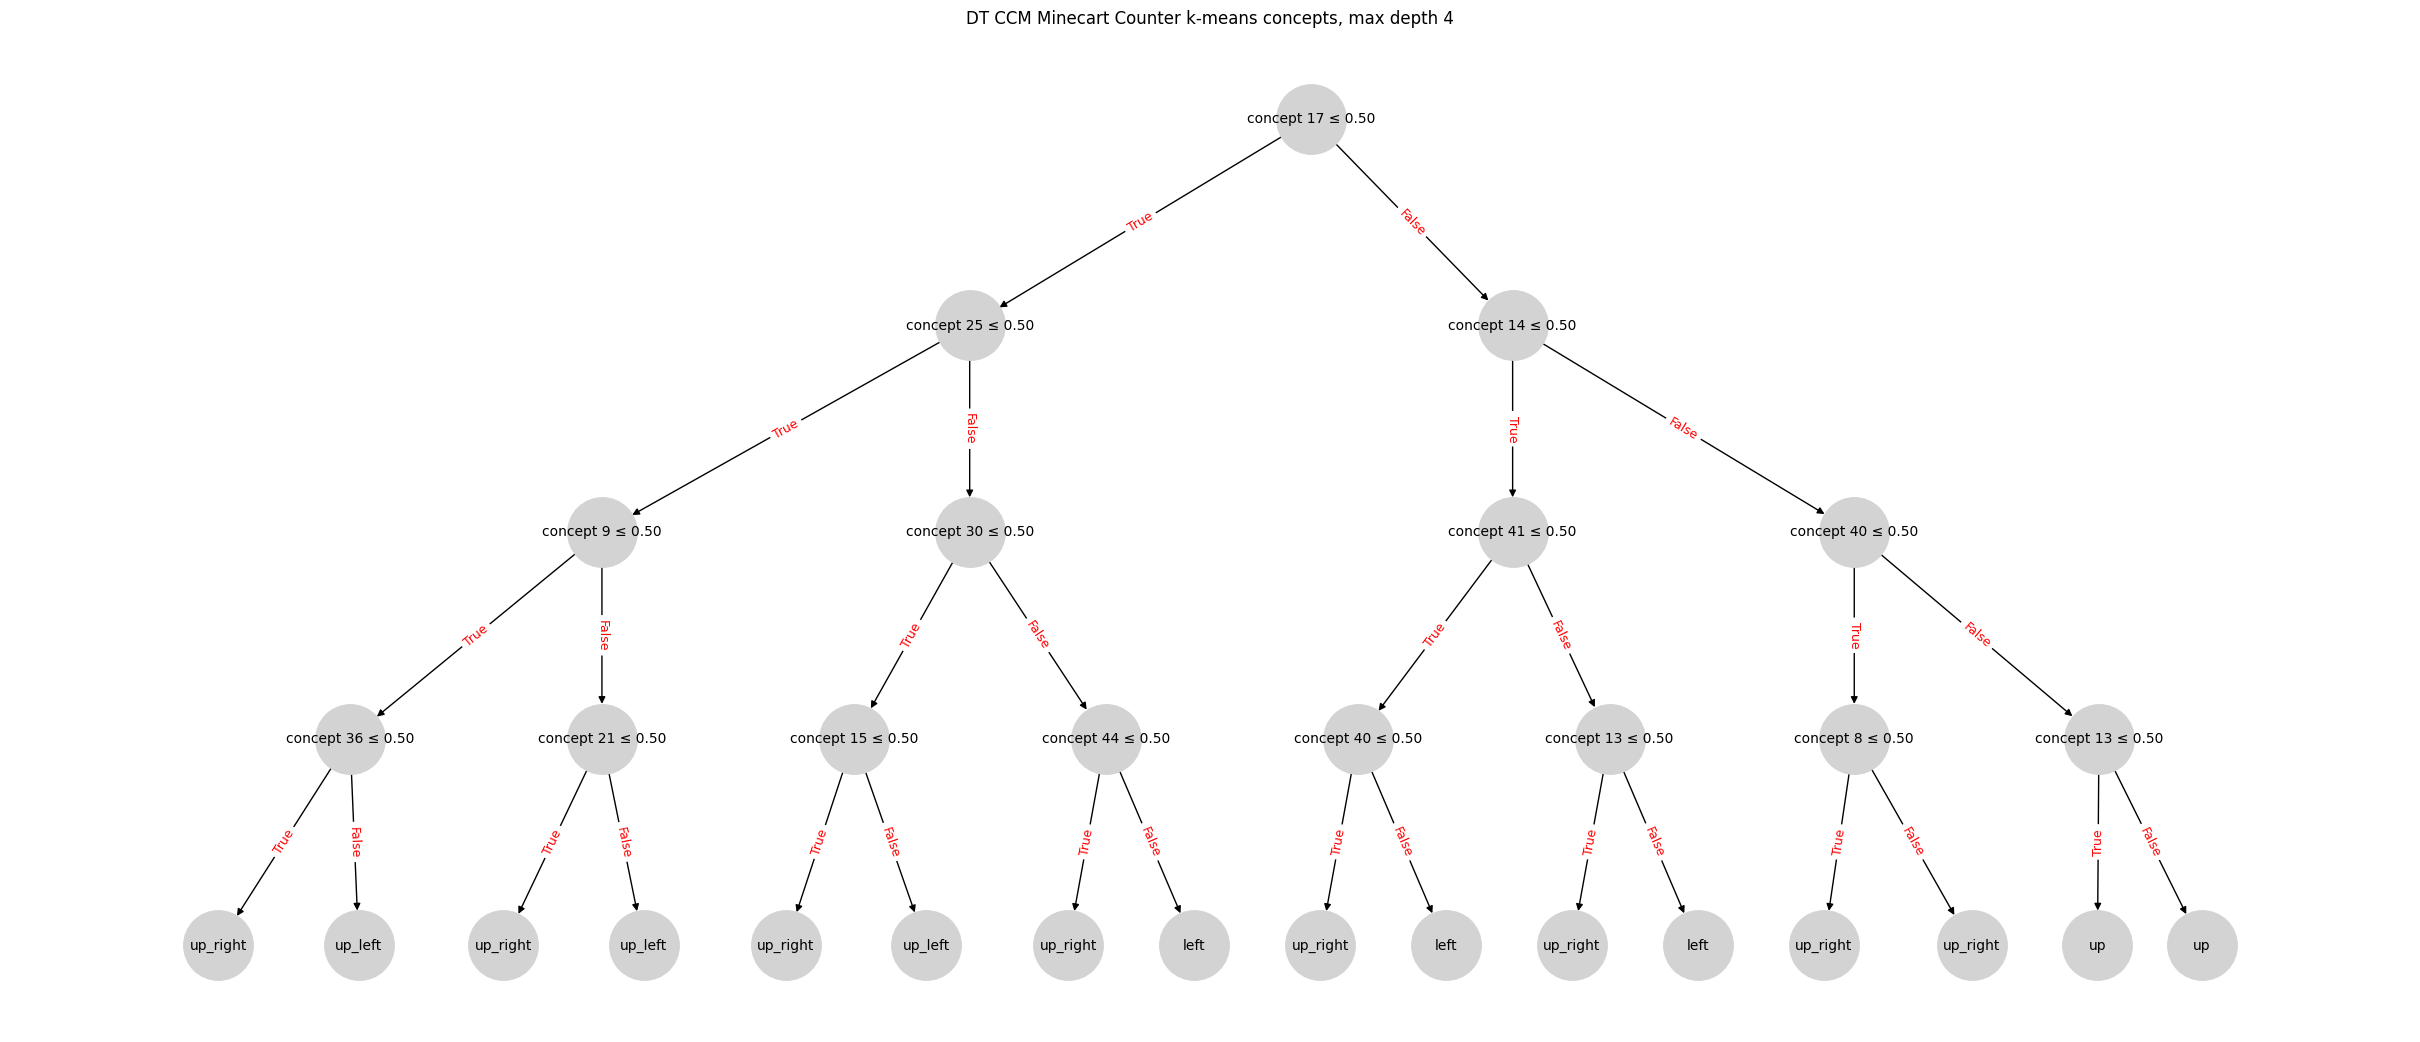

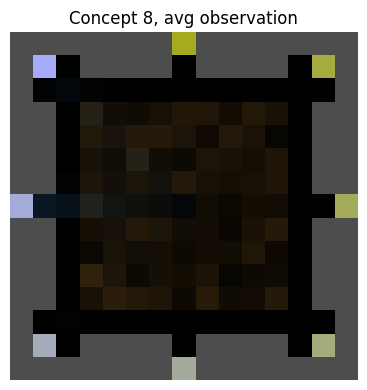

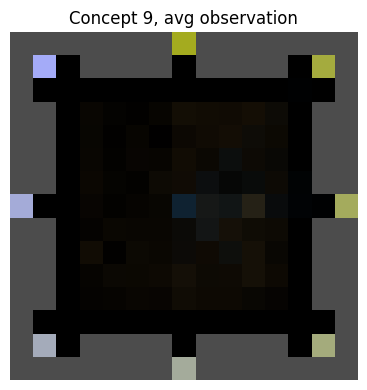

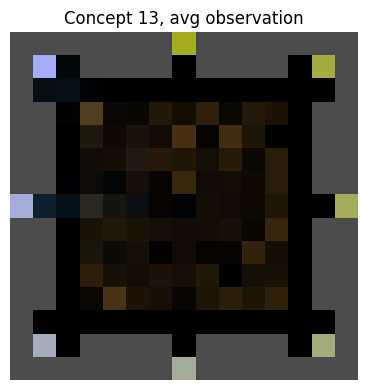

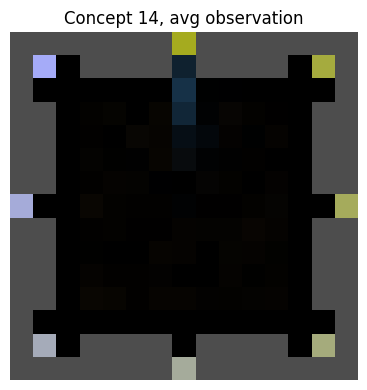

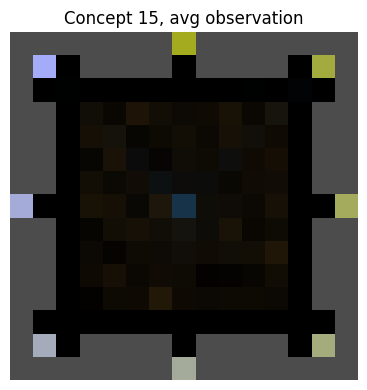

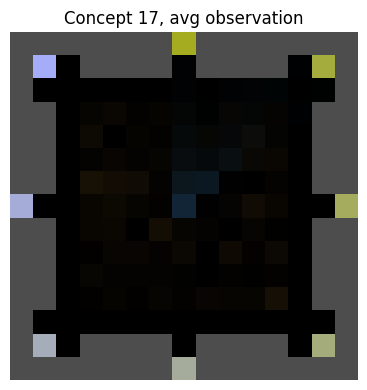

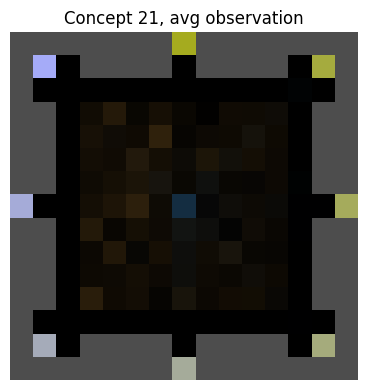

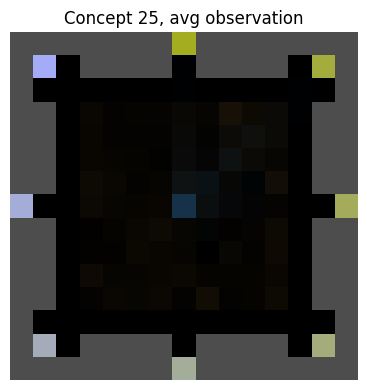

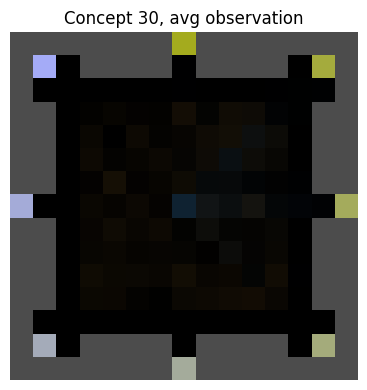

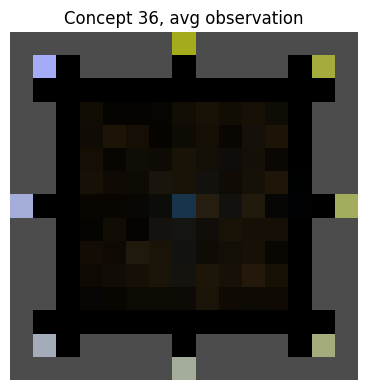

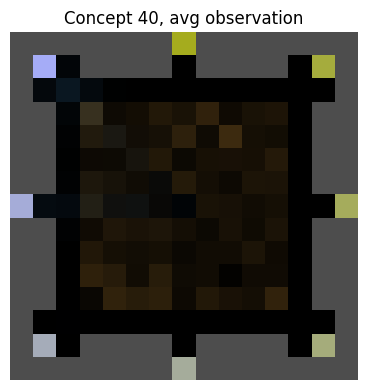

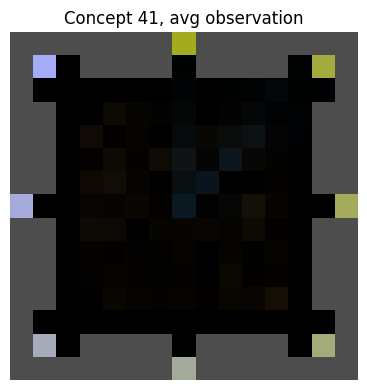

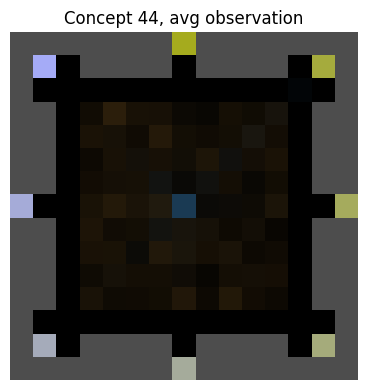

Showing random observations from cluster 8


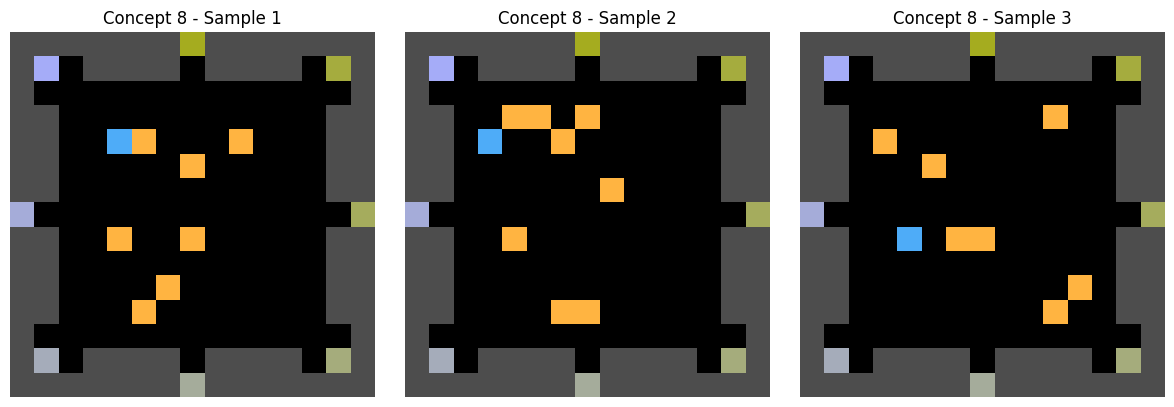

Showing random observations from cluster 9


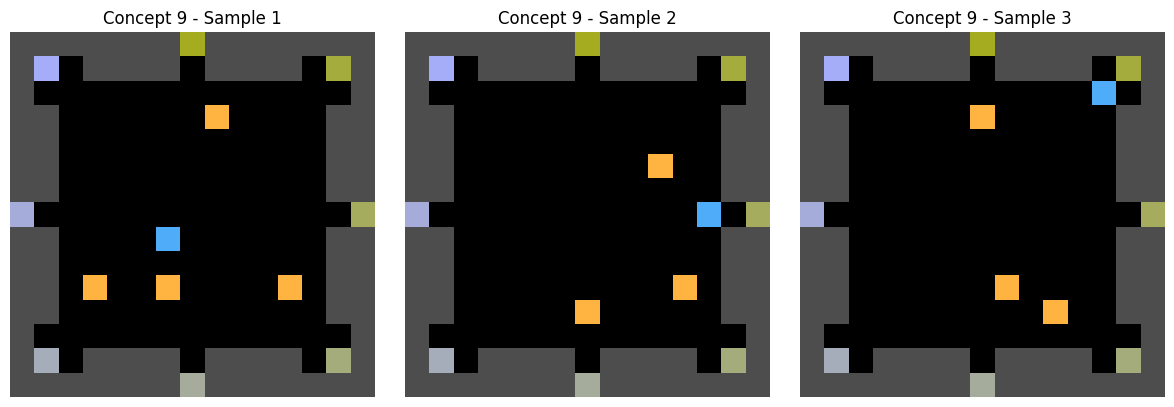

Showing random observations from cluster 13


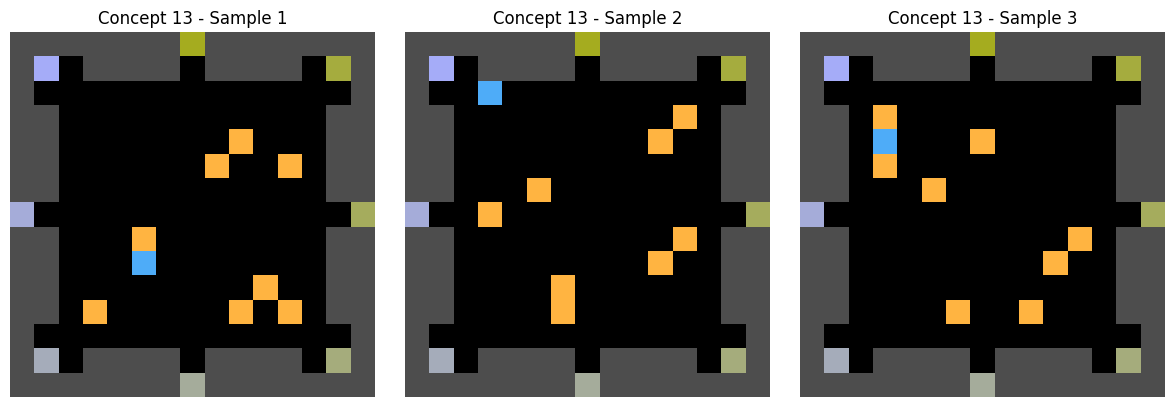

Showing random observations from cluster 14


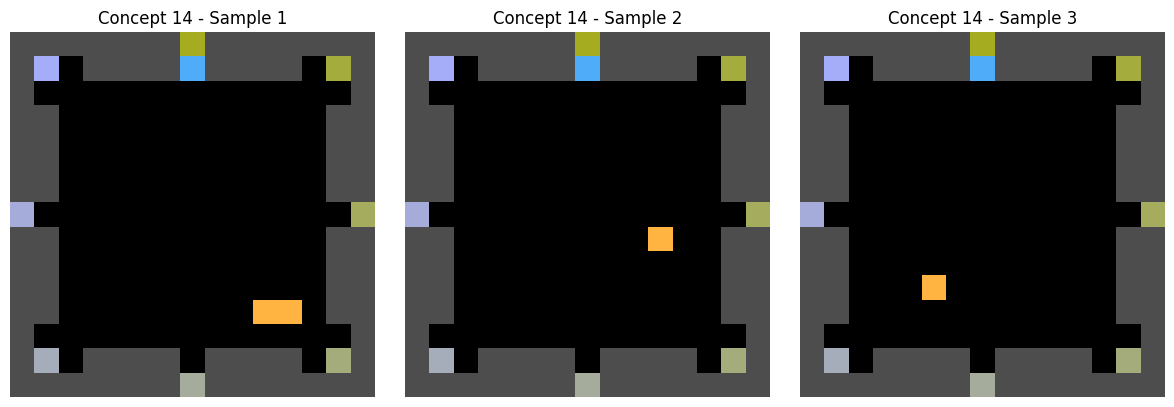

Showing random observations from cluster 15


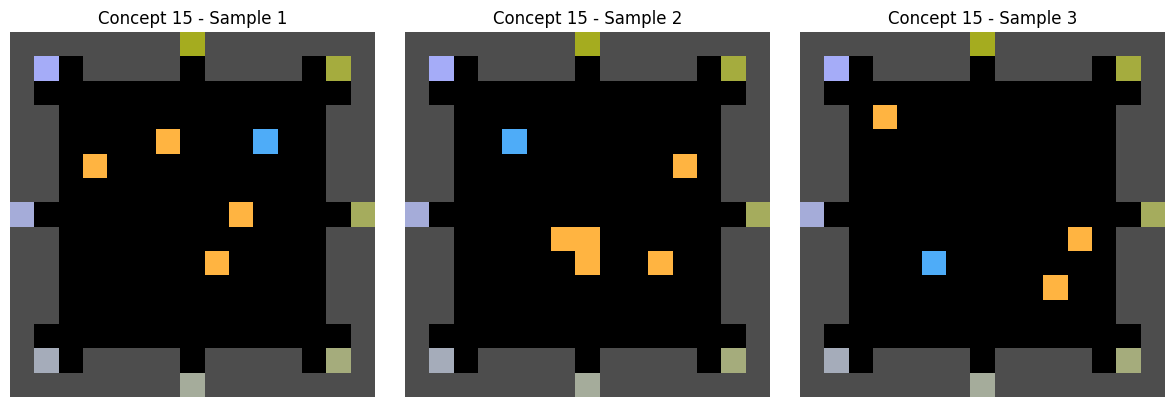

Showing random observations from cluster 17


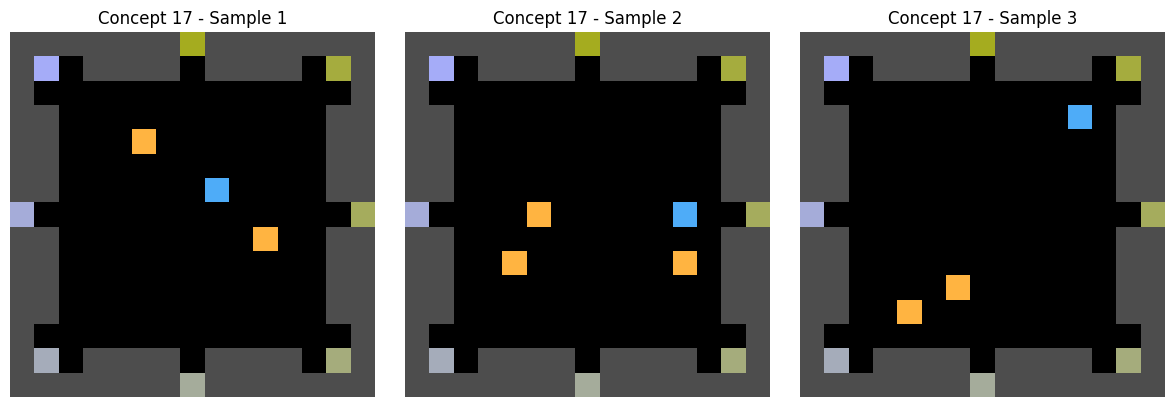

Showing random observations from cluster 21


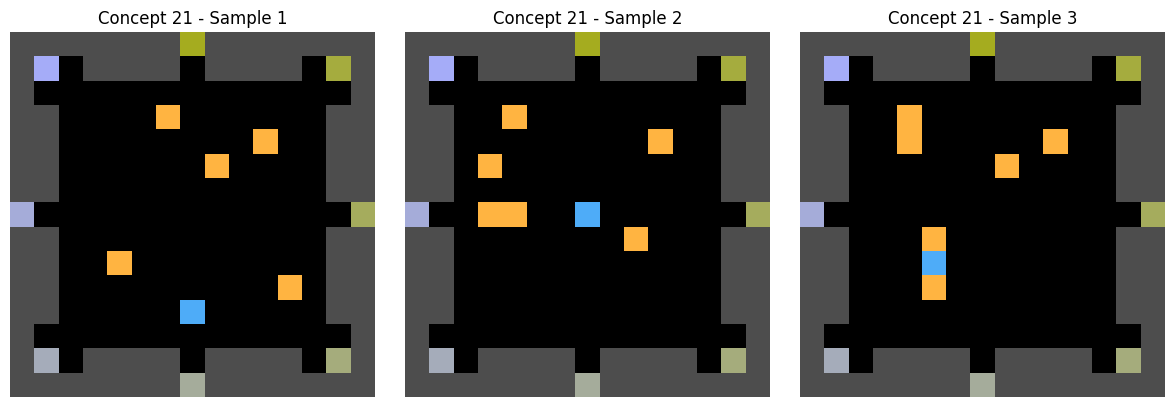

Showing random observations from cluster 25


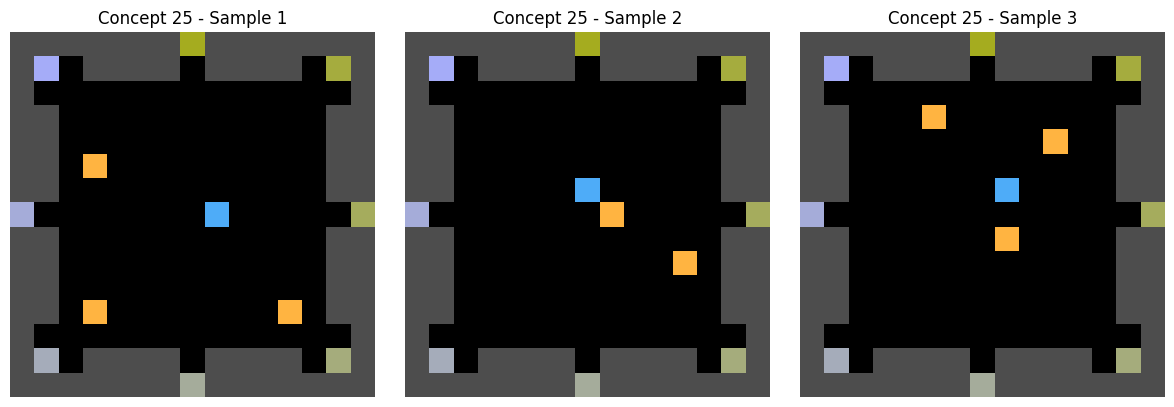

Showing random observations from cluster 30


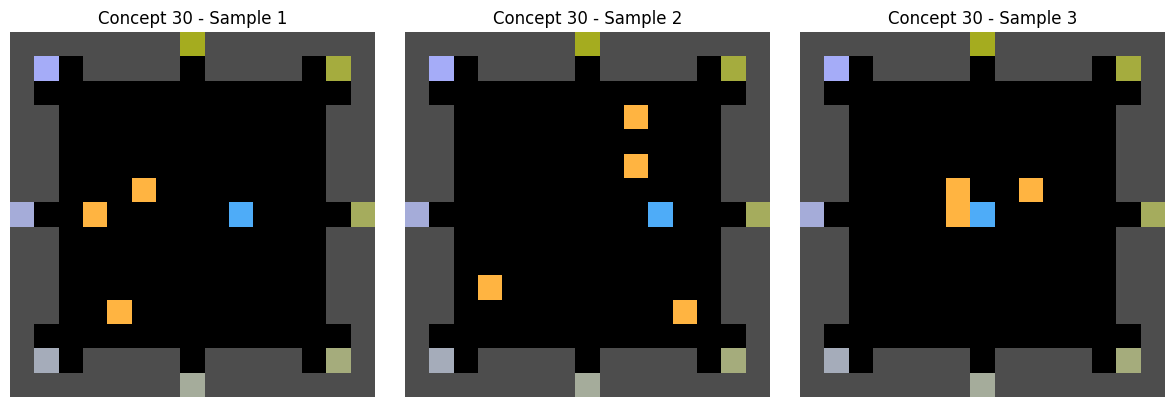

Showing random observations from cluster 36


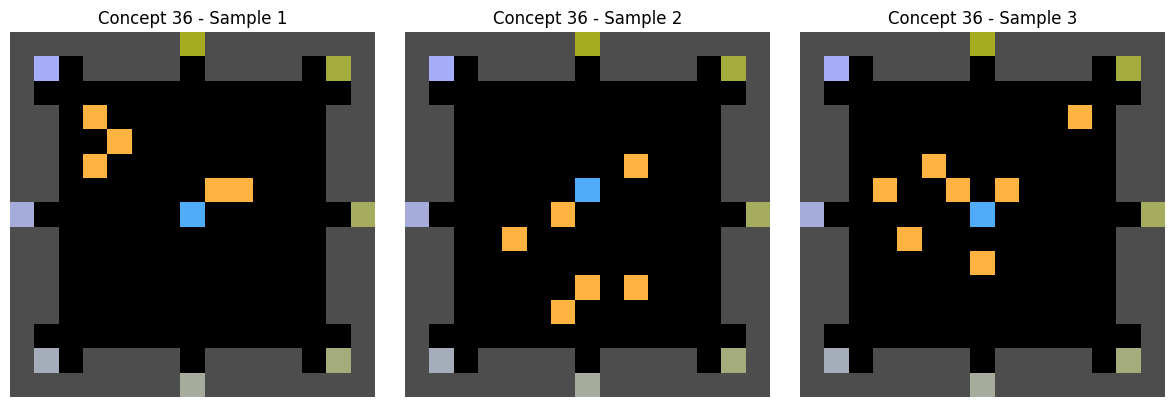

Showing random observations from cluster 40


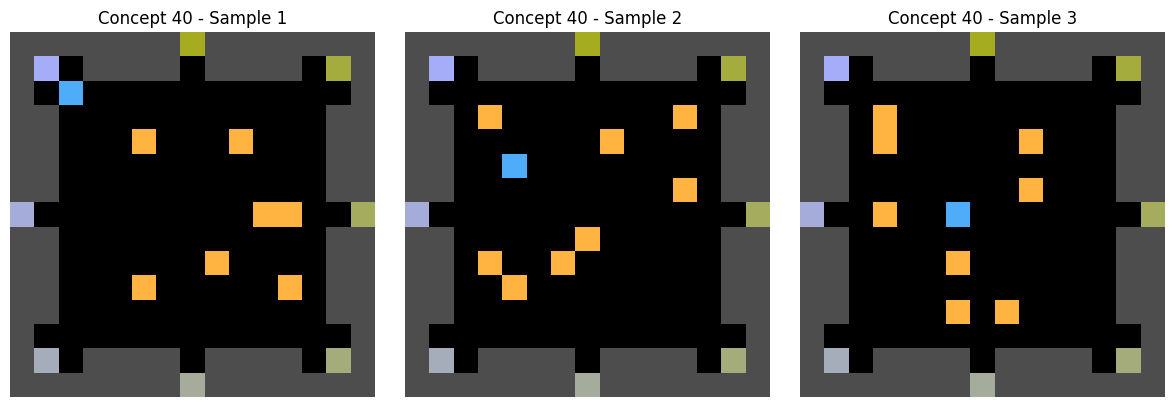

Showing random observations from cluster 41


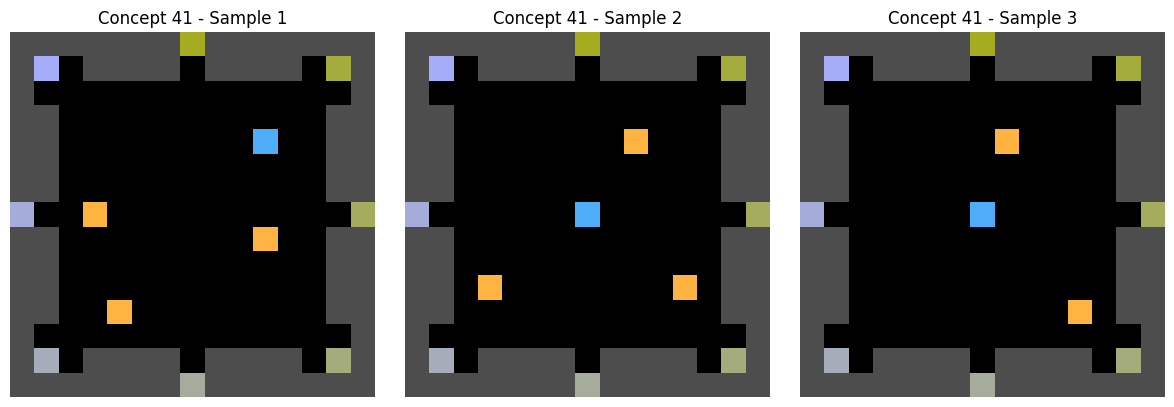

Showing random observations from cluster 44


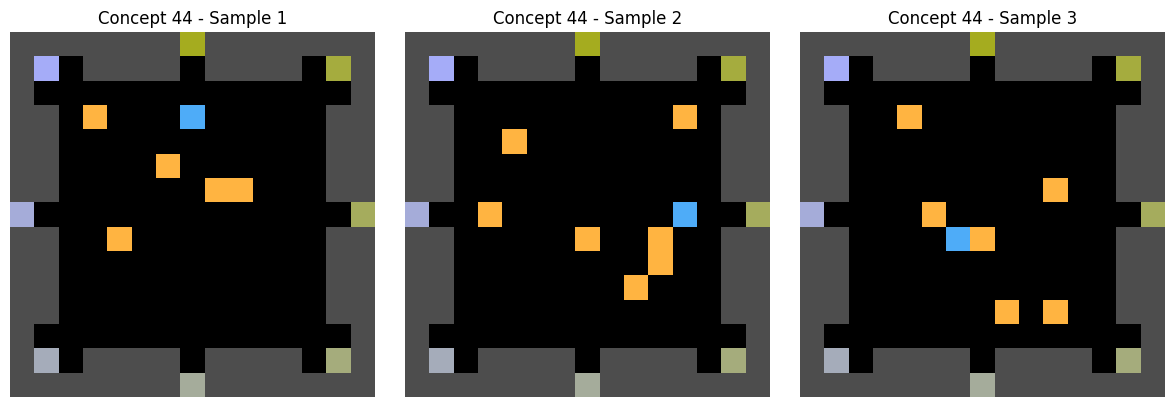

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


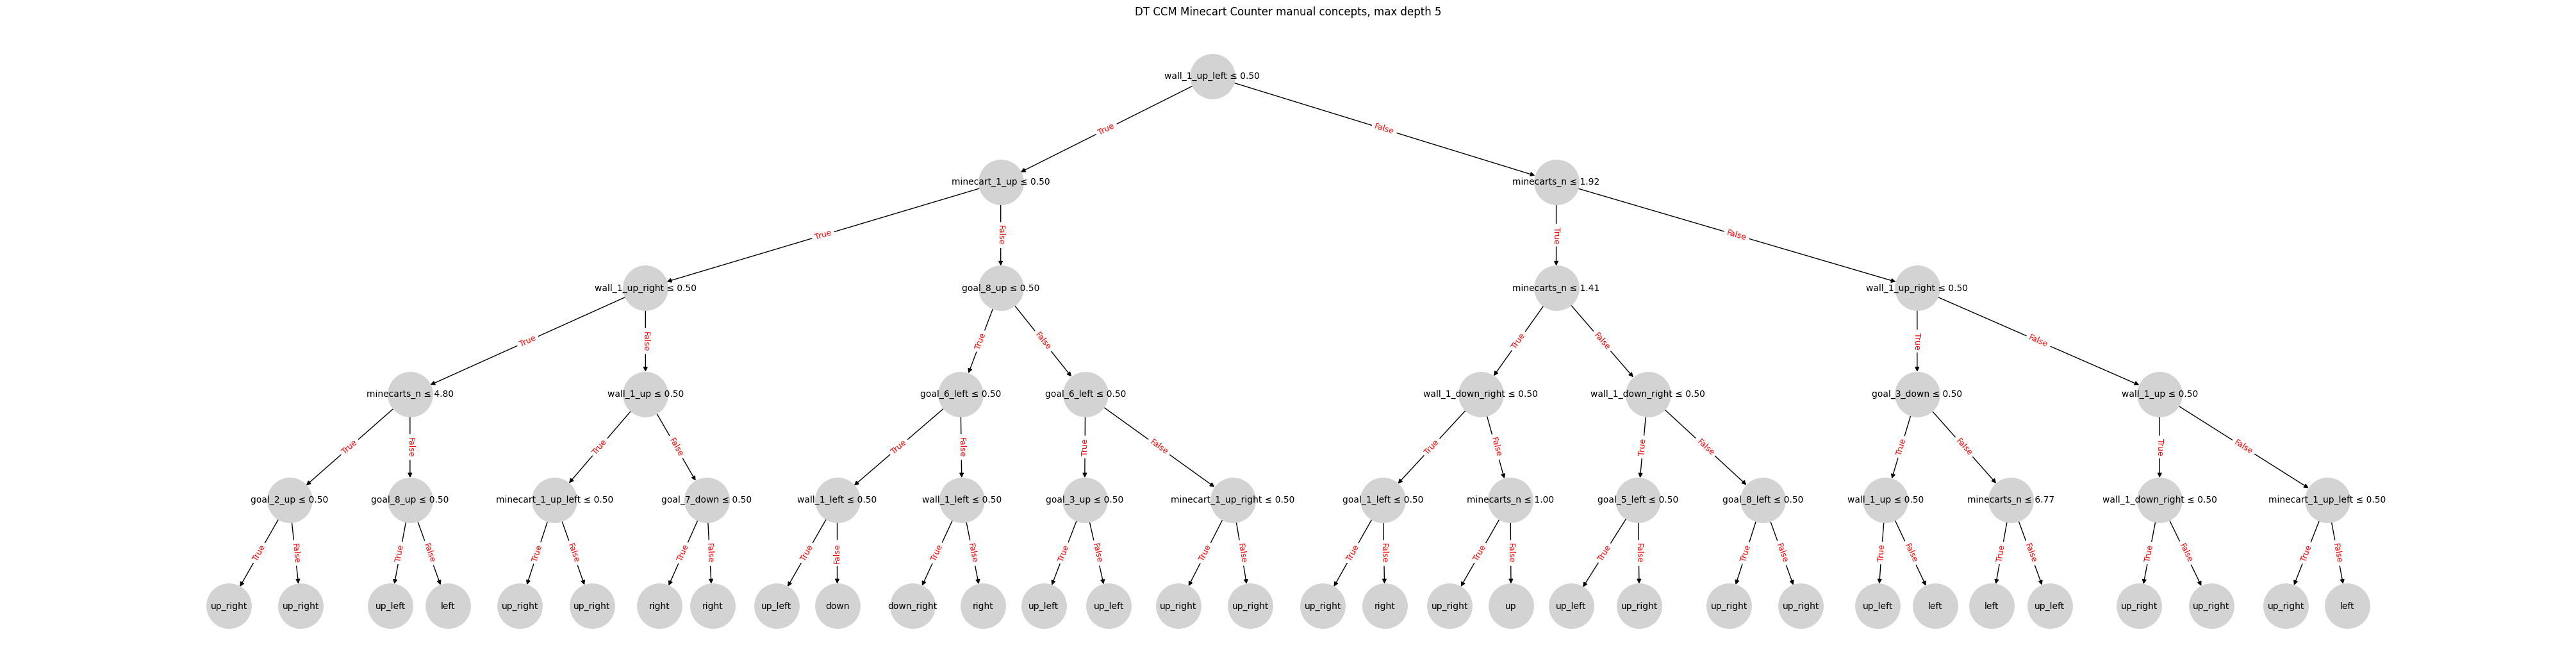

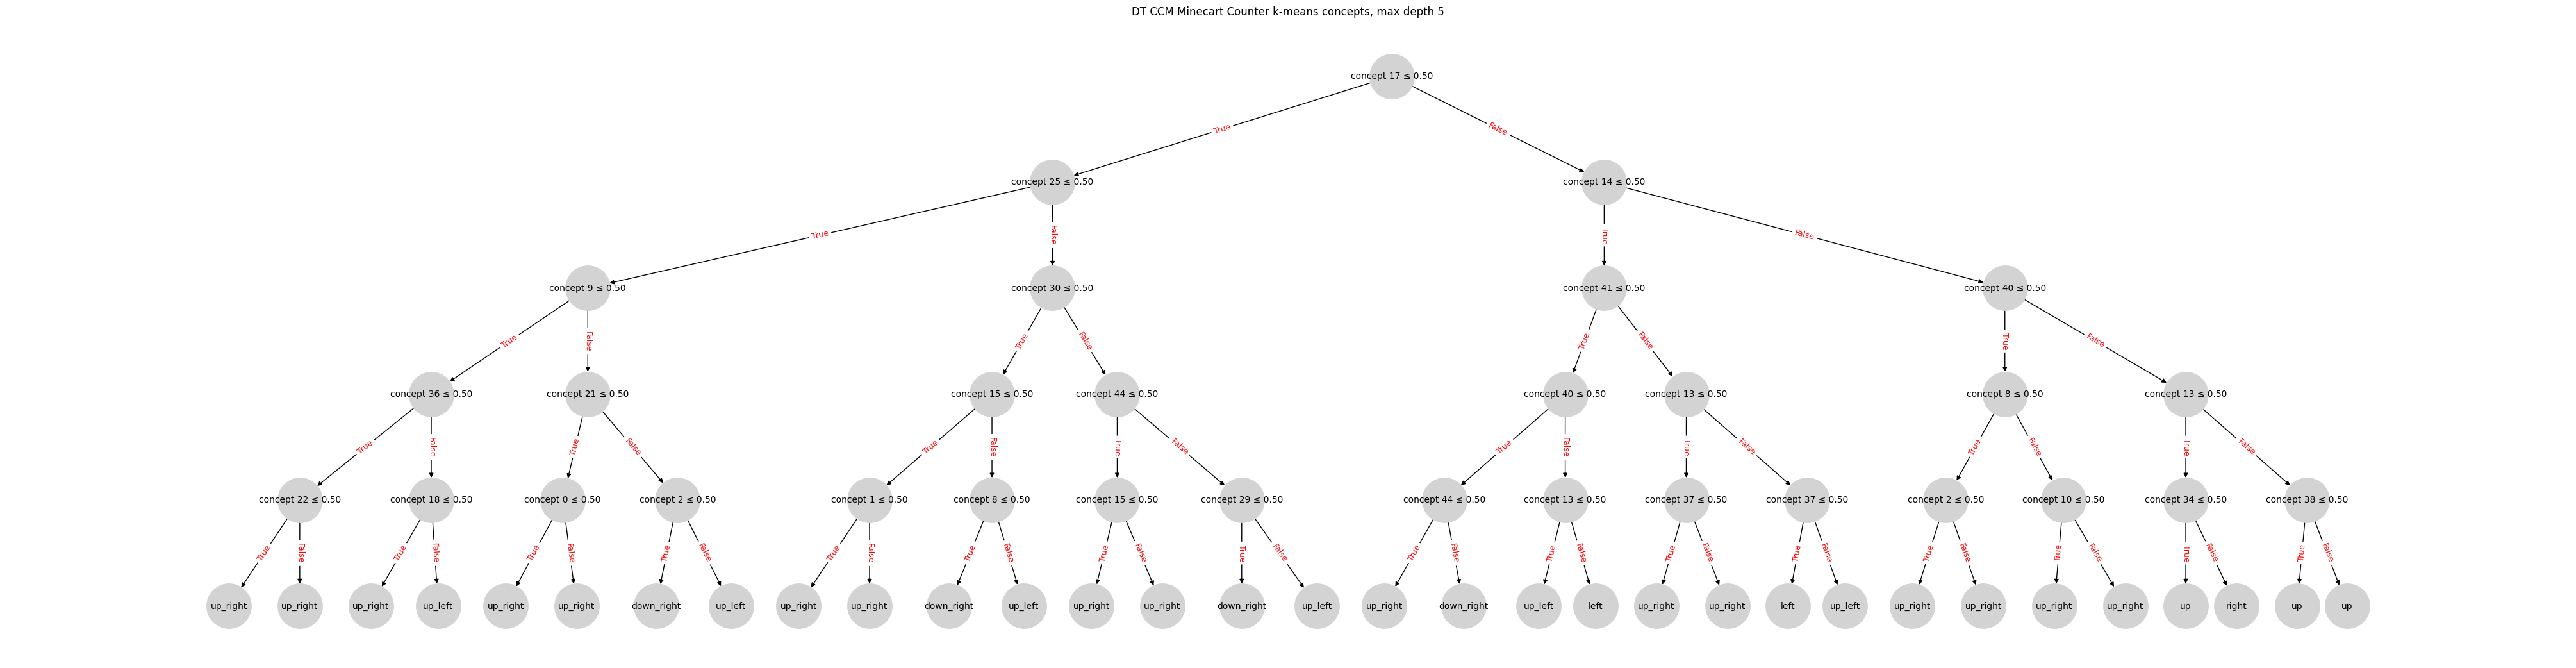

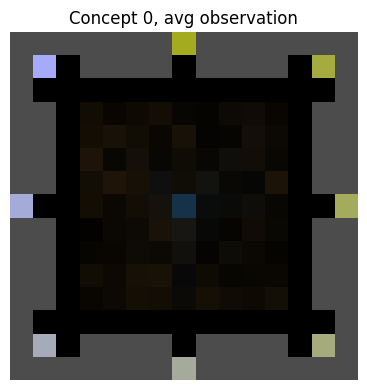

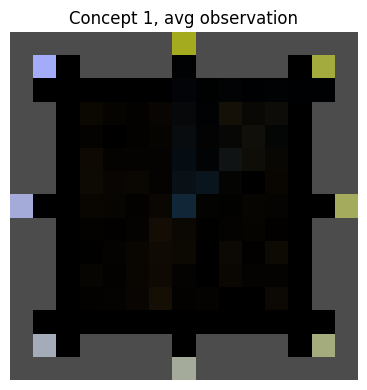

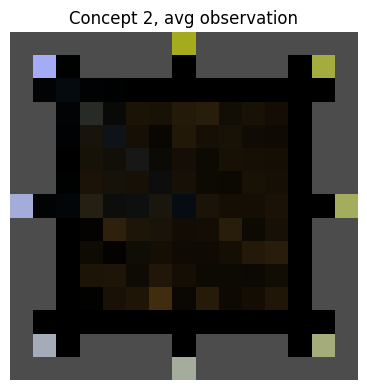

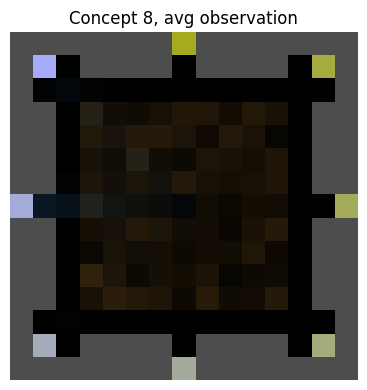

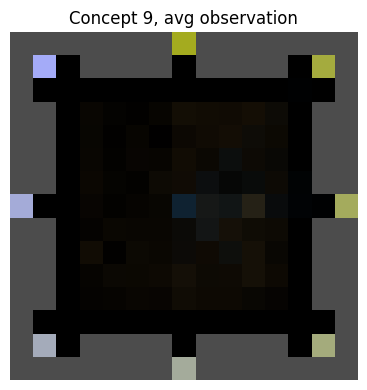

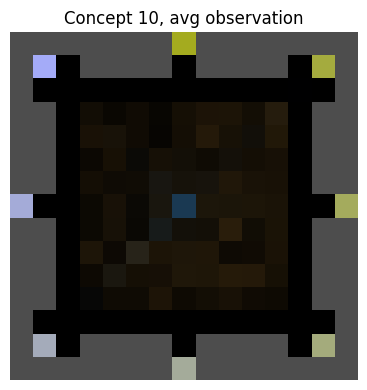

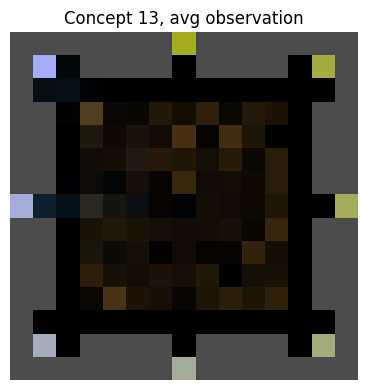

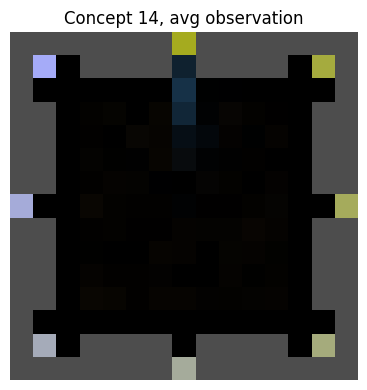

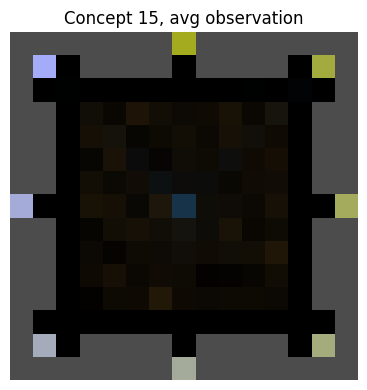

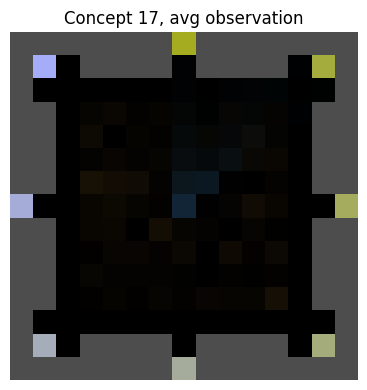

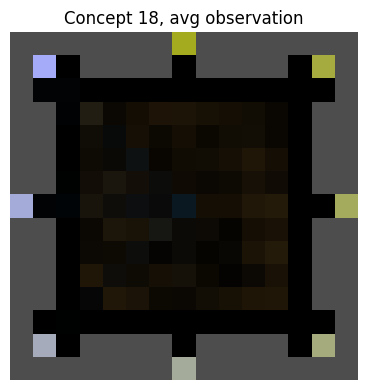

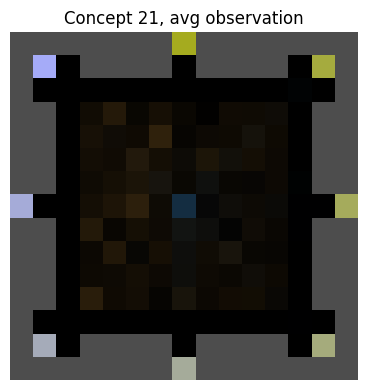

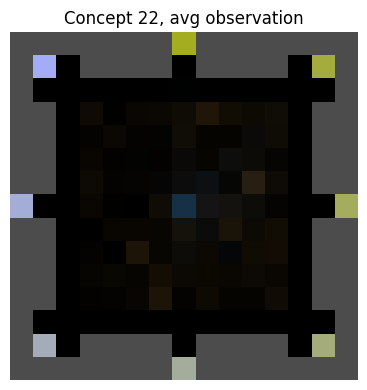

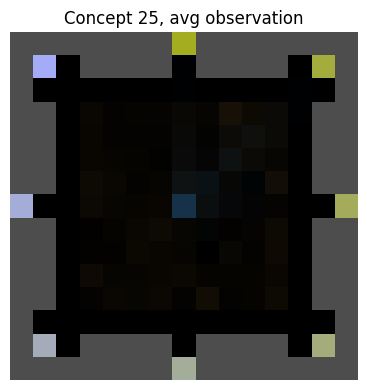

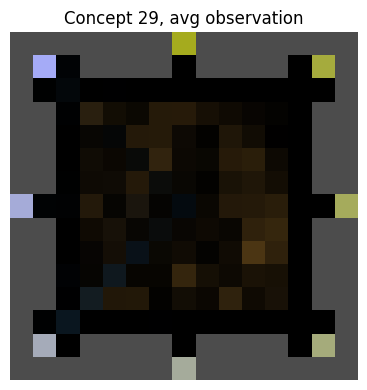

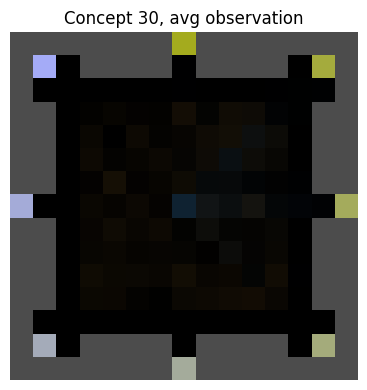

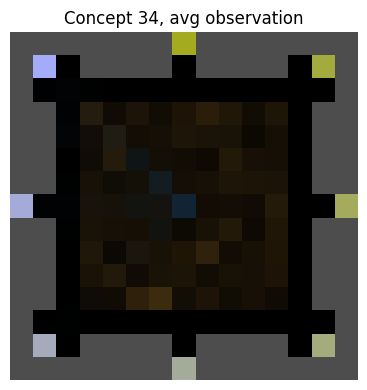

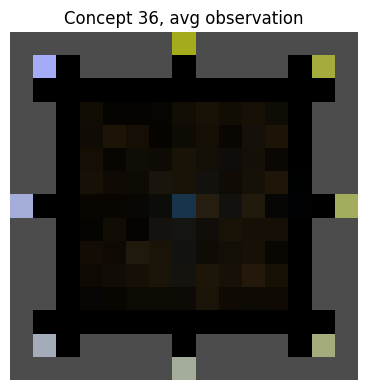

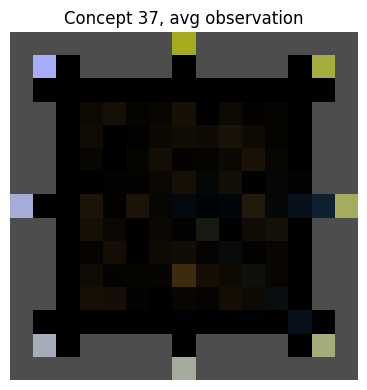

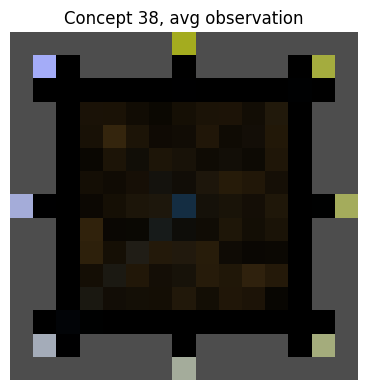

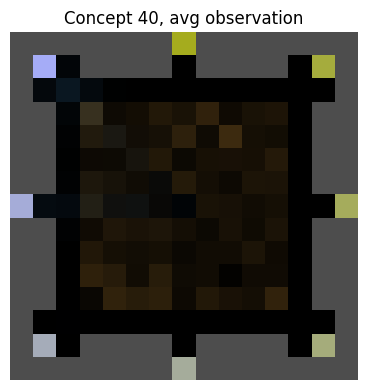

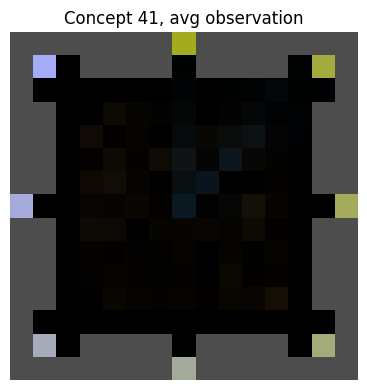

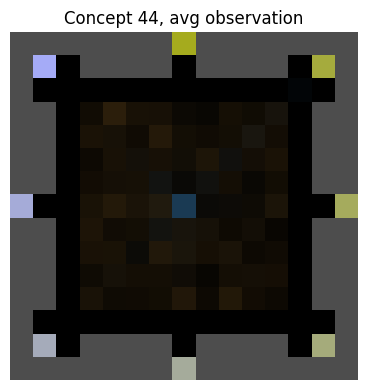

Showing random observations from cluster 0


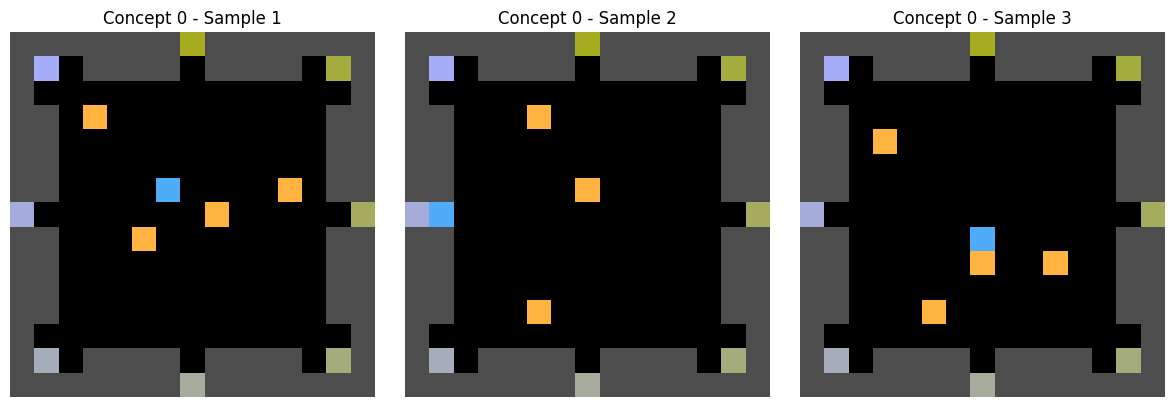

Showing random observations from cluster 1


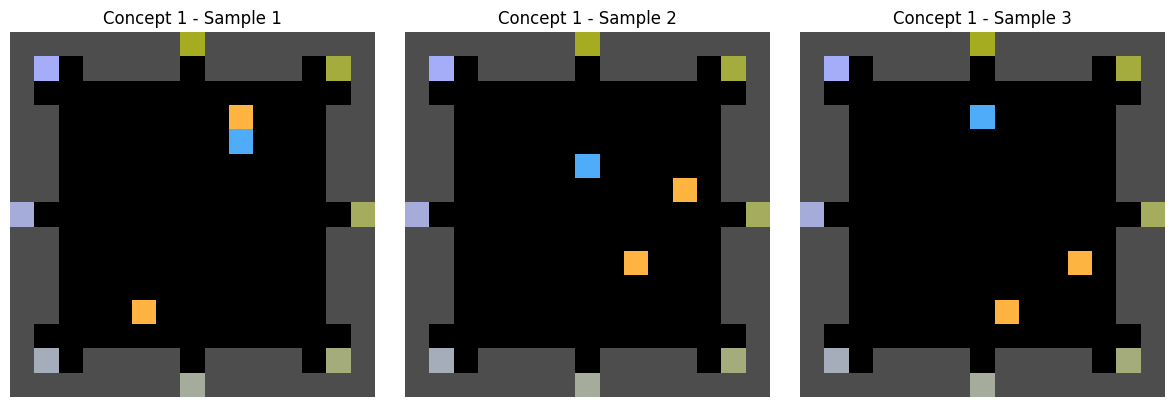

Showing random observations from cluster 2


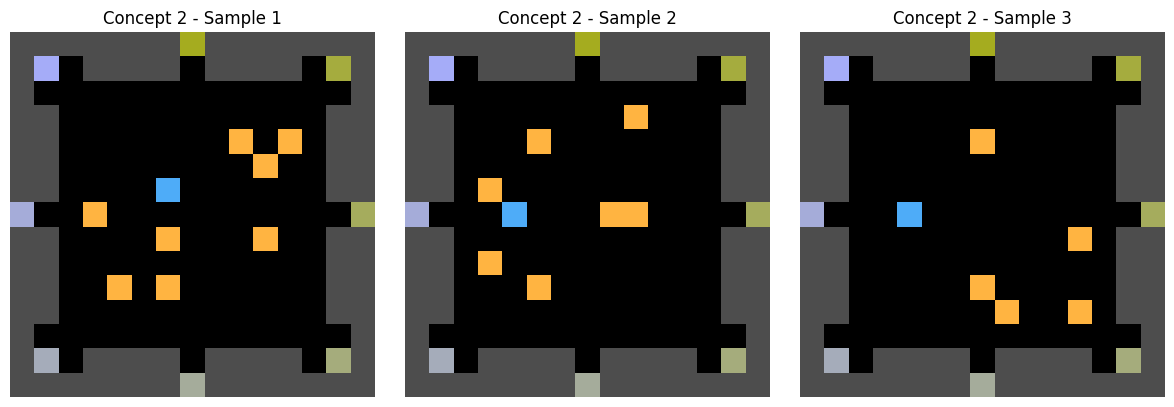

Showing random observations from cluster 8


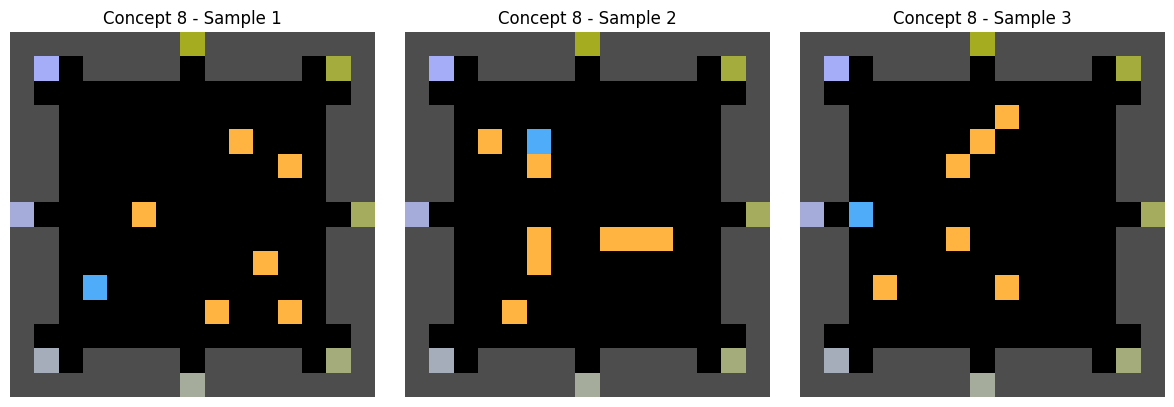

Showing random observations from cluster 9


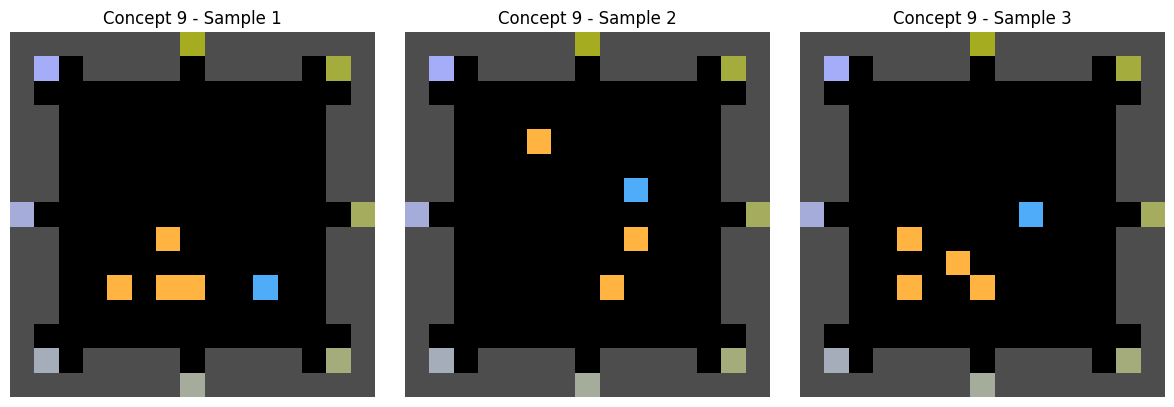

Showing random observations from cluster 10


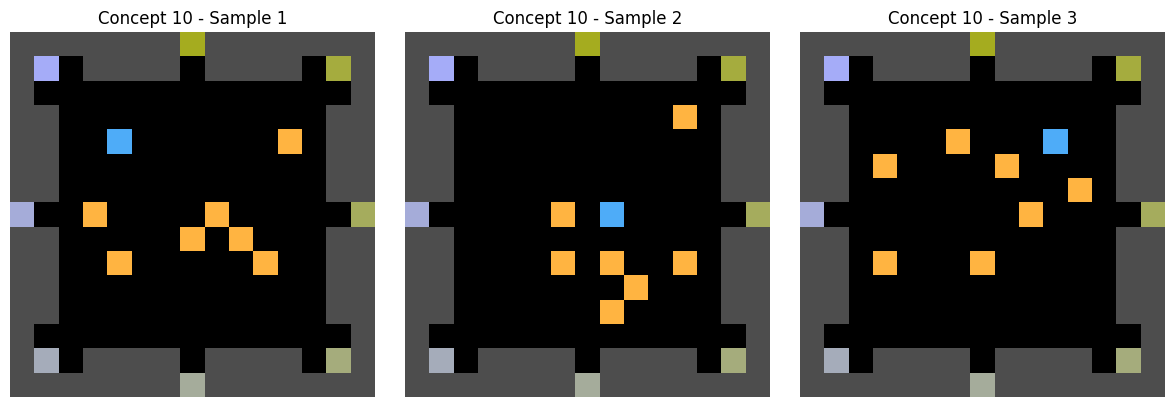

Showing random observations from cluster 13


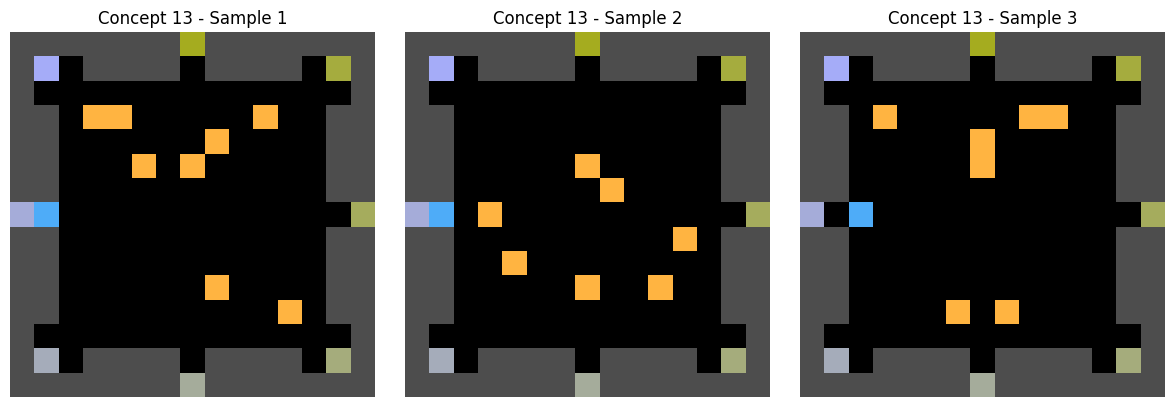

Showing random observations from cluster 14


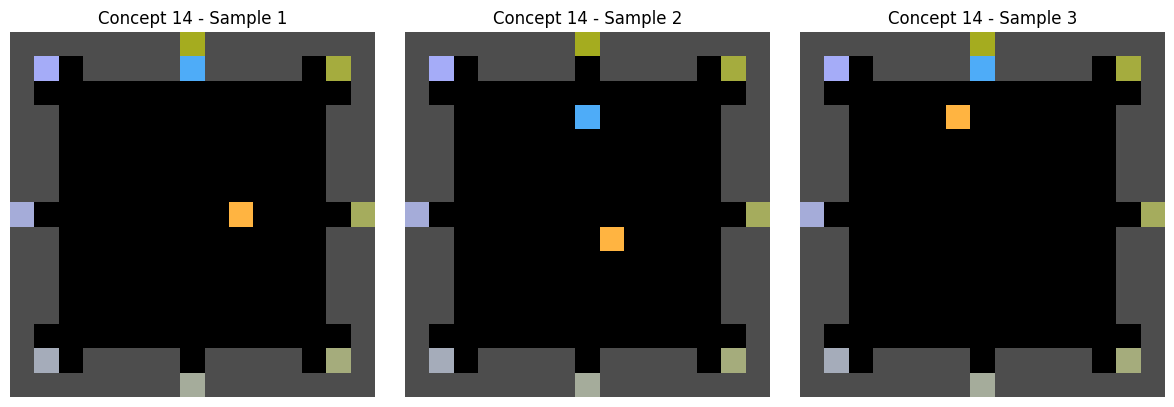

Showing random observations from cluster 15


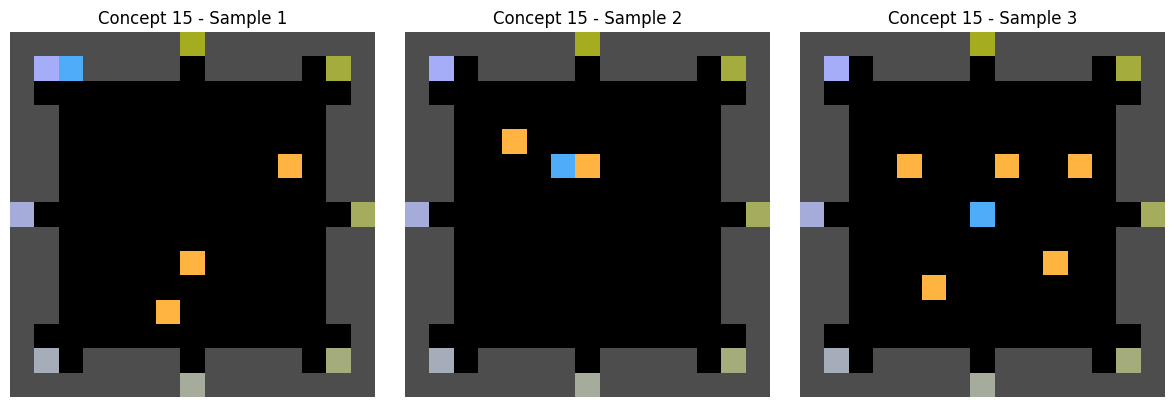

Showing random observations from cluster 17


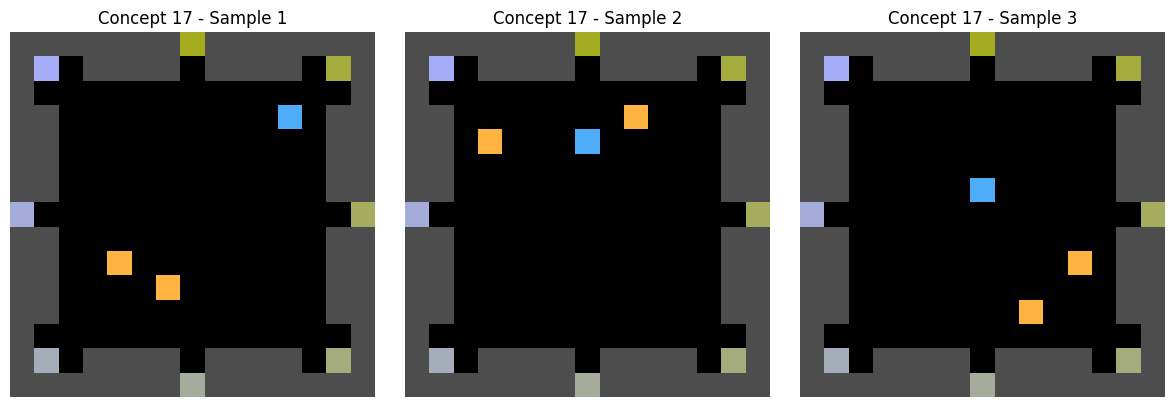

Showing random observations from cluster 18


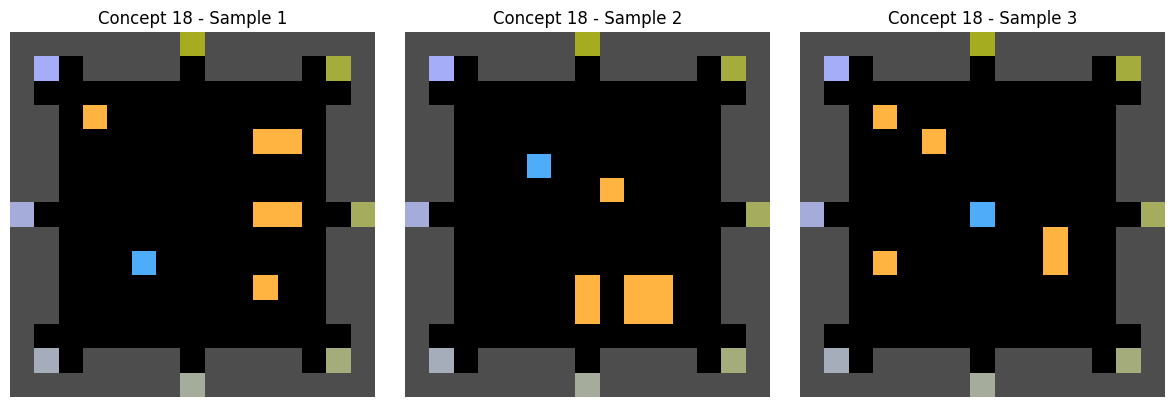

Showing random observations from cluster 21


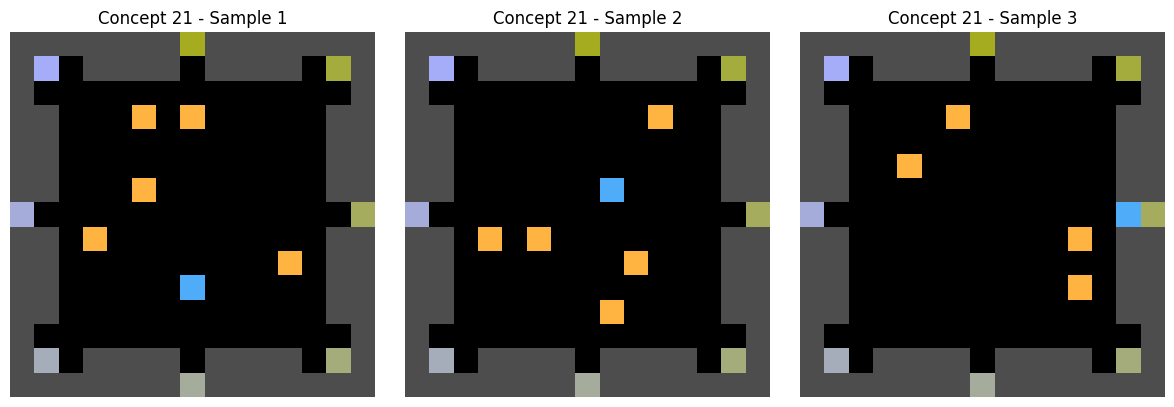

Showing random observations from cluster 22


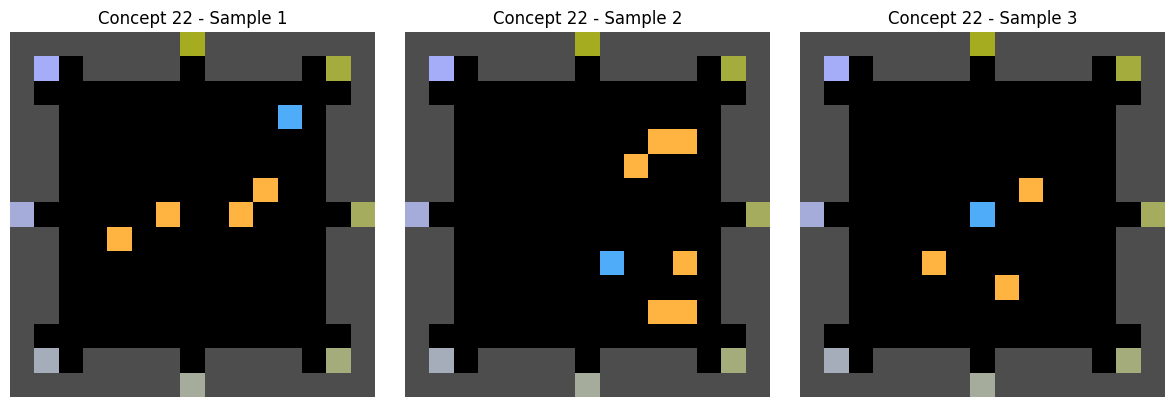

Showing random observations from cluster 25


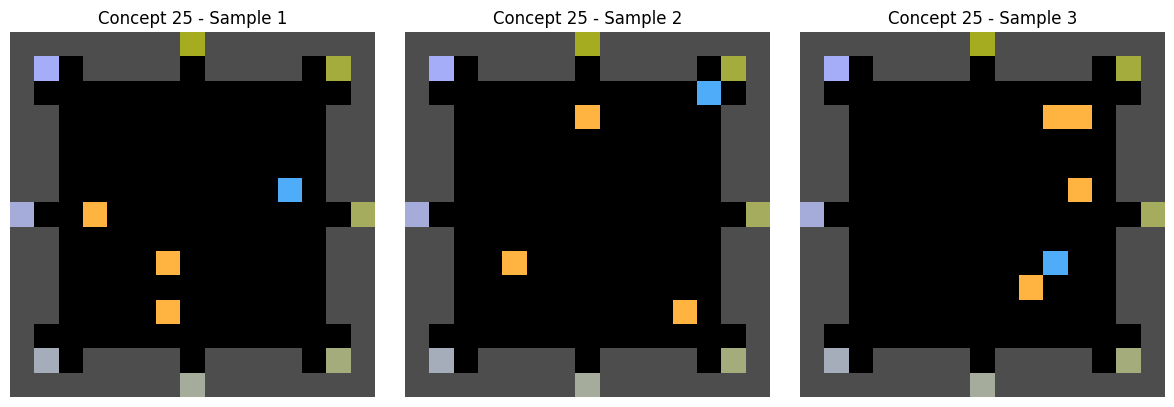

Showing random observations from cluster 29


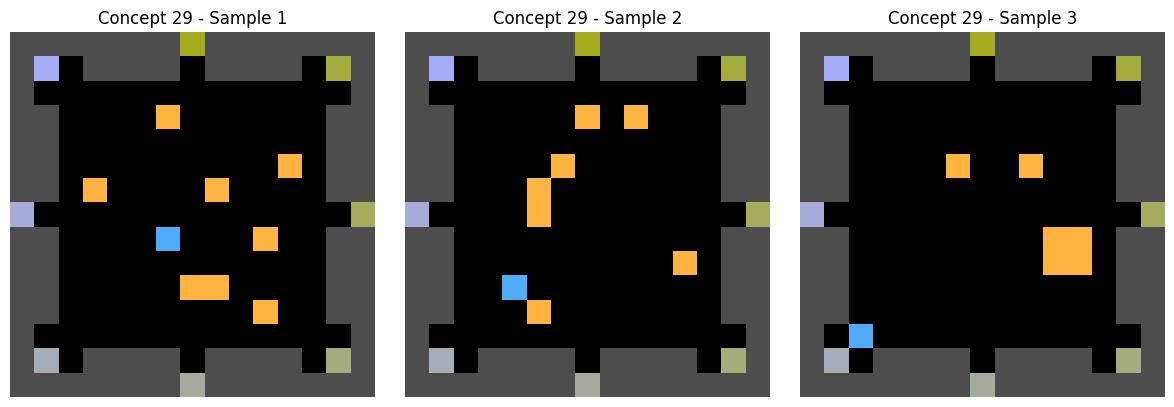

Showing random observations from cluster 30


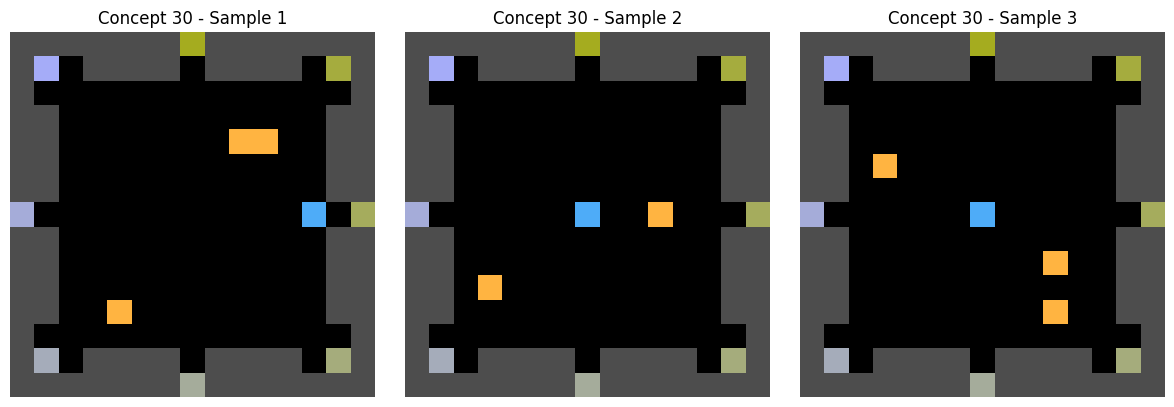

Showing random observations from cluster 34


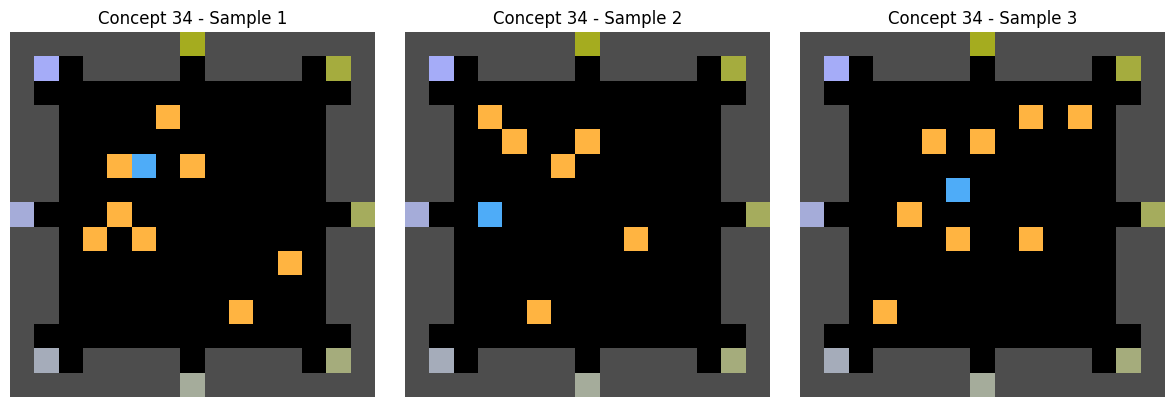

Showing random observations from cluster 36


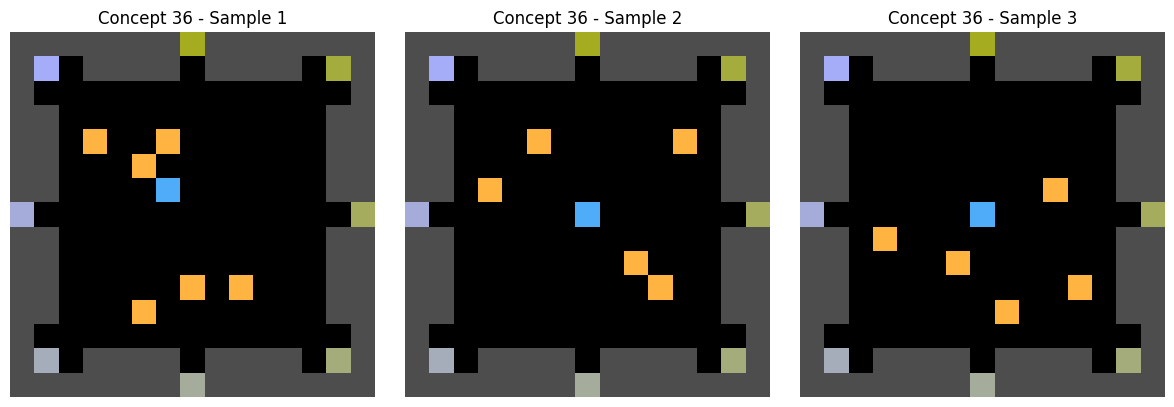

Showing random observations from cluster 37


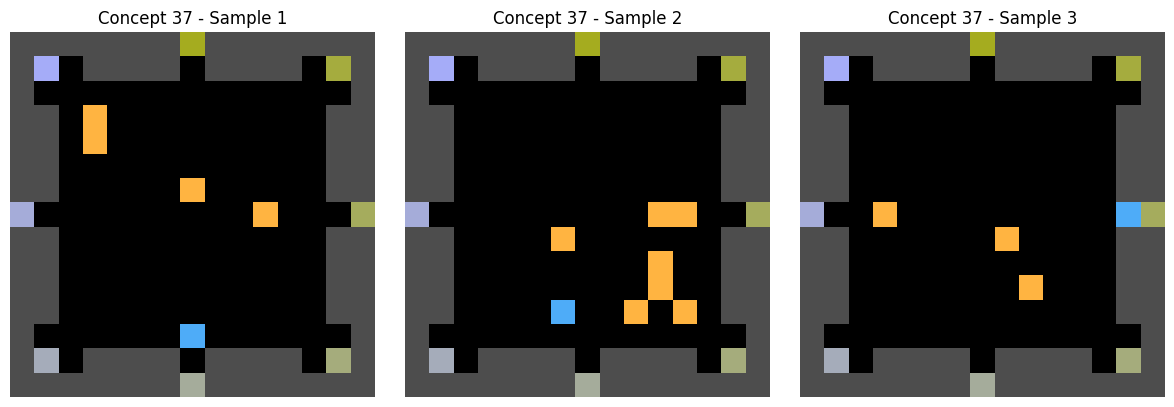

Showing random observations from cluster 38


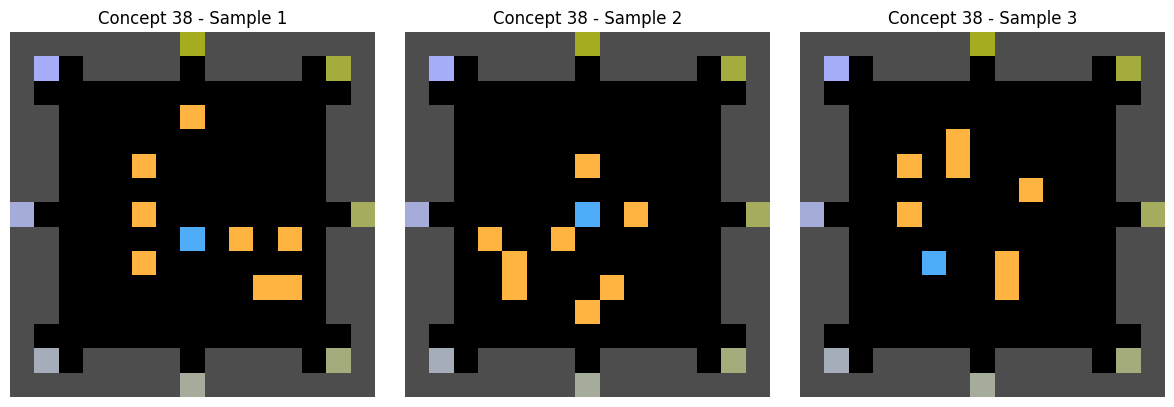

Showing random observations from cluster 40


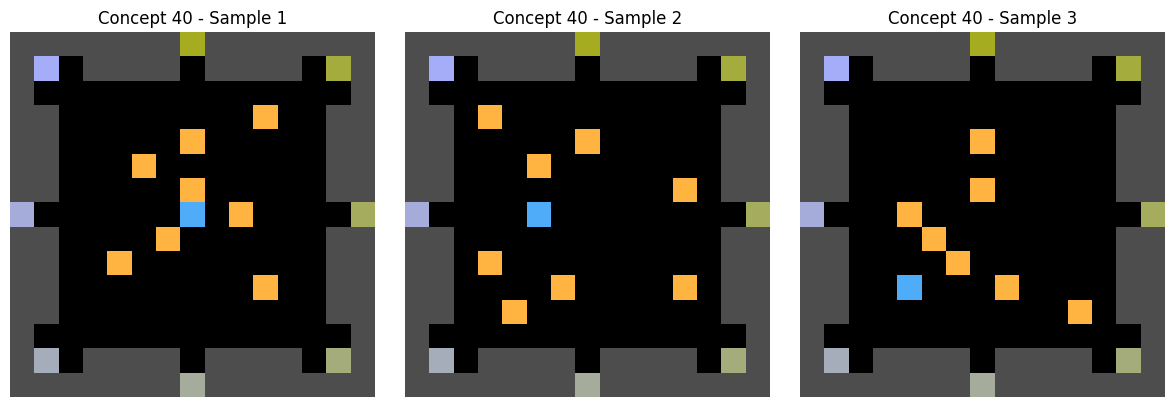

Showing random observations from cluster 41


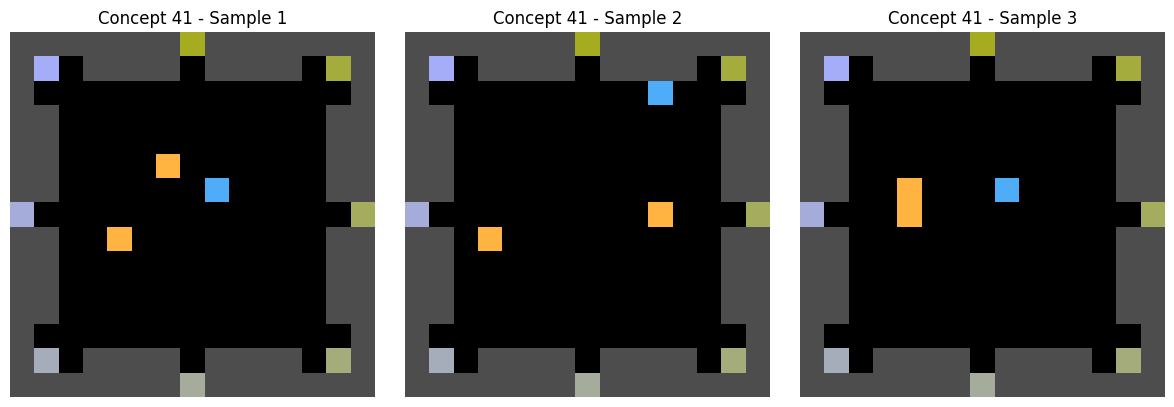

Showing random observations from cluster 44


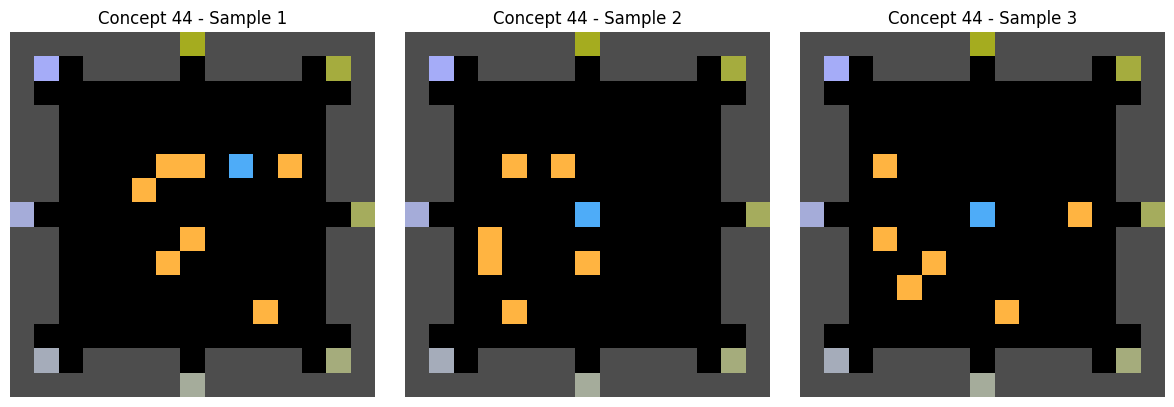

In [4]:
mc_concept_names_manual_dt = pd.read_csv("../../rl_ccm_data/completeness_scores/minecart_counter/kind-cosmos-35/ccm_dt/manual_concepts_used_names.csv").sort_values("feature_index")["concept_name"].tolist()

mc_action_dict = {
            0: "up",
            1: "up_right",
            2: "right",
            3: "down_right",
            4: "down",
            5: "down_left",
            6: "left",
            7: "up_left",
        }

model: Sequential = load_model("../../models/MinecartCounter/scattered/kind-cosmos-35/1740021317_model____0.5122avg____0.9750max___-0.0900min.keras") # type: ignore

mao = ModelActivationObtainer(model=model, input_normalization_type="image")

mc_clustered_obs = np.load("../../rl_concept_discovery_data/class_datasets_model_of_interest/minecart_counter/target_class_balanced_30000_shuffled_examples.npy")
mc_k_means_clustered_labels = np.load("../../rl_ace_data/concept_examples/k_means/minecart_counter/model_of_interest_target_class_balanced_observations/layer_5/k_45_cluster_labels.npy")

mc_clustered_obs_activations = mao.get_layer_activations(layer_index=5, model_inputs=mc_clustered_obs, flatten=True)
mc_k_means_clustered_controids = np.load("../../rl_ace_data/concept_examples/k_means/minecart_counter/model_of_interest_target_class_balanced_observations/layer_5/k_45_cluster_centroids.npy")

mc_k_means_clustered_distances = np.array([
    norm(mc_clustered_obs_activations[i] - mc_k_means_clustered_controids[label])
    for i, label in enumerate(mc_k_means_clustered_labels)
])

for max_depth in range(3, 6):
    mc_manual_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/minecart_counter/kind-cosmos-35/ccm_dt/best_ccm_manual_layer_5_c_33_all_q_max_depth_{max_depth}.joblib")
    mc_k_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/minecart_counter/kind-cosmos-35/ccm_dt/best_ccm_k_means_layer_5_k_45_all_q_max_depth_{max_depth}.joblib")
    mc_fc_means_concepts_dt: DecisionTreeRegressor = joblib.load(f"../../rl_ccm_data/completeness_scores/minecart_counter/kind-cosmos-35/ccm_dt/best_ccm_fc_means_layer_5_c_25_all_q_max_depth_{max_depth}.joblib")

    graph = build_custom_graph(mc_manual_concepts_dt.tree_, mc_action_dict, mc_concept_names_manual_dt)
    draw_custom_tree(graph, max_depth, f"DT CCM Minecart Counter manual concepts, max depth {max_depth}")

    graph = build_custom_graph(mc_k_means_concepts_dt.tree_, mc_action_dict)
    draw_custom_tree(graph, max_depth, f"DT CCM Minecart Counter k-means concepts, max depth {max_depth}")

    used_clusters = np.unique(mc_k_means_concepts_dt.tree_.feature) # type: ignore
    used_clusters = used_clusters[used_clusters != -2] 

    visualize_avg_cluster_observation(clustered_observations=mc_clustered_obs,
    clustered_observations_labels=mc_k_means_clustered_labels,
    distances=mc_k_means_clustered_distances,
    clusters_to_show=used_clusters,
    show=True,
    )

    for cluster_id in used_clusters:
        print(f"Showing random observations from cluster {cluster_id}")
        cluster_indices = np.where(mc_k_means_clustered_labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            continue  # skip if no examples (just in case)

        # Select up to 3 random indices
        selected_indices = random.sample(list(cluster_indices), min(3, len(cluster_indices)))
        selected_images = mc_clustered_obs[selected_indices]

        fig, axes = plt.subplots(1, len(selected_images), figsize=(4 * len(selected_images), 4))
        if len(selected_images) == 1:
            axes = [axes]

        for i, img in enumerate(selected_images):
            axes[i].imshow(img.astype(np.uint8))
            axes[i].set_title(f"Concept {cluster_id} - Sample {i+1}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

    #graph = build_custom_graph(mc_fc_means_concepts_dt.tree_, mc_action_dict)
    #draw_custom_tree(graph, max_depth, f"DT CCM Minecart Counter fuzzy c-means concepts, max depth {max_depth}")